In [2]:

import MDAnalysis as mda
#from MDAnalysisData import datasets
from MDAnalysis.analysis import rms, align
from MDAnalysis.analysis import contacts
# import nglview as nv
import numpy as np
from MDAnalysis.lib import distances
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor



import warnings

gro_file = "vars/output_no_water.gro"
xtc_file = "vars/output_no_water.xtc"
u=mda.Universe(gro_file, xtc_file)

NUM_RES = 59
NUM_PROTEINS = 30
PROTEIN_LEN = 986
RNA_LEN = 707 # indicates the rna length
NUM_RNA = 30
NUM_RES_RNA = 22 #how many RESIDUES (nucleotide bases) in one rna
rna_start = NUM_PROTEINS * PROTEIN_LEN
RNA_START_INDEX = NUM_PROTEINS * PROTEIN_LEN

i = 10

start_index = rna_start + 1 + i*RNA_LEN
end_index = rna_start+(i+1)*RNA_LEN

In [3]:
def contacts_prot_rna_job_traj(gro_file, xtc_file, start_index, end_index, radius=20):
    u = mda.Universe(gro_file, xtc_file)
    # Create an array with length equal to the number of frames
    is_in_contact = np.zeros(len(u.trajectory), dtype=int)
    
    # Select atoms for proteins and RNA
    prot = u.select_atoms(f"bynum {start_index}:{end_index}")
    rnas = u.select_atoms(f"bynum {RNA_START_INDEX+1}:{RNA_START_INDEX+RNA_LEN*NUM_RNA}")

    for frame_index, ts in enumerate(u.trajectory):
        # Calculate centers-of-mass for each residue (protein and RNA)
        com_prot = prot.center_of_mass(compound='residues')
        com_rna = rnas.center_of_mass(compound='residues')
        
        # Compute the pairwise distances
        dists = distances.distance_array(com_prot, com_rna, box=u.dimensions)
        
        for i in range(NUM_RNA):
            for j in range(NUM_RES_RNA):
                found = False  # Reset flag for each j iteration
                for k in range(NUM_RES):
                    if dists[k][j + i * NUM_RES_RNA] < radius:
                        is_in_contact[frame_index] += 1
                        found = True
                        break  # Break out of k-loop
                if found:
                    break  # Break out of j-loop as well
                
    return is_in_contact

def contacts_prot_rna_job(gro_file, xtc_file, start_index, end_index, radius=20):
    u = mda.Universe(gro_file, xtc_file)
    # Create an array with length equal to the number of frames
    res_num_prot_contact = np.zeros((NUM_RNA, NUM_RES_RNA), dtype=int)
    
    # Select atoms for proteins and RNA
    prot = u.select_atoms(f"bynum {start_index}:{end_index}")
    rnas = u.select_atoms(f"bynum {RNA_START_INDEX+1}:{RNA_START_INDEX+RNA_LEN*NUM_RNA}")

    for frame_index, ts in enumerate(u.trajectory):
        # Calculate centers-of-mass for each residue (protein and RNA)
        com_prot = prot.center_of_mass(compound='residues')
        com_rna = rnas.center_of_mass(compound='residues')
        
        # Compute the pairwise distances
        dists = distances.distance_array(com_prot, com_rna, box=u.dimensions)
        
        for i in range(NUM_RNA):
            for j in range(NUM_RES_RNA):
                found = False  # Reset flag for each j iteration
                for k in range(NUM_RES):
                    if dists[k][j + i * NUM_RES_RNA] < radius:
                        res_num_prot_contact[i][j] += 1

    return res_num_prot_contact


# Main function to generate contact map
def generate_contact_map(gro_file, xtc_file, num_proteins, protein_len, radius):
    from concurrent.futures import ProcessPoolExecutor, as_completed

    # Preallocate a list of length num_proteins
    results = [None] * num_proteins

    # Dictionary to map futures to their index
    future_to_index = {}
    
    with ProcessPoolExecutor(max_workers=32) as executor:
        for i in range(num_proteins):
            start_index = i * protein_len + 1
            end_index = (i + 1) * protein_len
            # Submit job and map the future to index i
            future = executor.submit(contacts_prot_rna_job, gro_file, xtc_file, start_index, end_index, radius)
            future_to_index[future] = i

        # As futures complete, store the result at the corresponding index
        for future in as_completed(future_to_index):
            index = future_to_index[future]
            results[index] = future.result()
    
    final_results = np.sum(results, axis=0) / len(u.trajectory)
    return final_results

rna_protein_neighbors = generate_contact_map(gro_file, xtc_file, NUM_PROTEINS, PROTEIN_LEN, 8)

print(rna_protein_neighbors.shape)


(30, 22)


In [4]:
import MDAnalysis as mda
from MDAnalysis.coordinates.XTC import XTCWriter
from MDAnalysis.coordinates.GRO import GROWriter

def extract_rna(rna_index):
    # Load the full system from GROMACS files
    gro_file = "vars/output_no_water.gro"
    xtc_file = "vars/output_no_water.xtc"
    u = mda.Universe(gro_file, xtc_file)
    start_i = rna_start + 1 + rna_index*RNA_LEN
    end_i = rna_start+(rna_index+1)*RNA_LEN

    # Define RNA backbone selection
    rna_sel = f"bynum {start_i}:{end_i}"
    rna = u.select_atoms(rna_sel)

    # Create a new Universe for just the RNA backbone
    ref_u = mda.Merge(rna)  # Creates a new universe with only the selected atoms

    # Save the cleaned-up GRO file (first frame structure)
    output_gro = f"vars/cleaned_rna{rna_index}.gro"
    with GROWriter(output_gro) as gro_writer:
        gro_writer.write(ref_u)

    # Write a new cleaned trajectory
    output_xtc = f"vars/cleaned_rna{rna_index}.xtc"
    with XTCWriter(output_xtc, n_atoms=len(rna)) as writer:
        for ts in u.trajectory:
            ref_u.atoms.positions = rna.positions  # Update the new universe positions
            writer.write(ref_u.atoms)

<>:87: SyntaxWarning: invalid escape sequence '\A'
<>:87: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_460247/3056645482.py:87: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/pytho

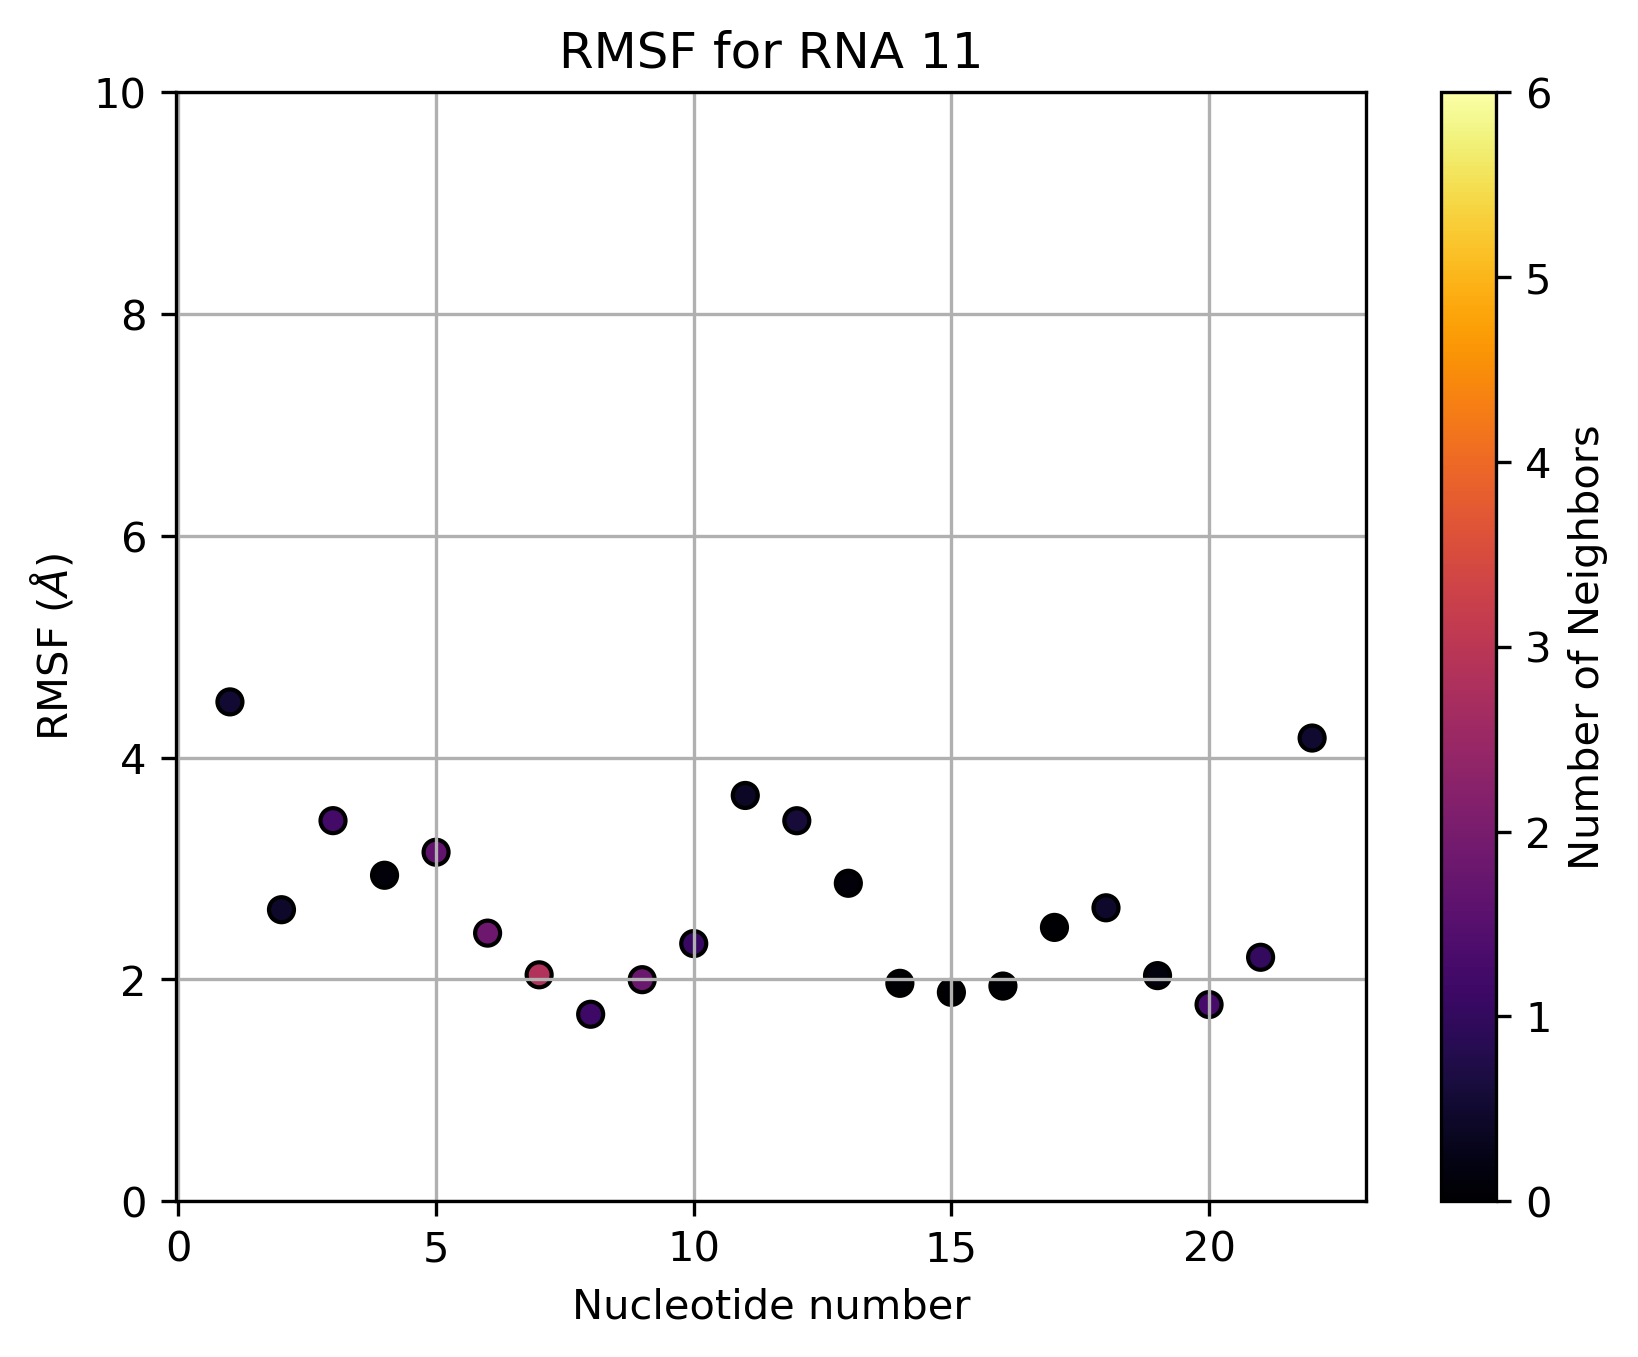

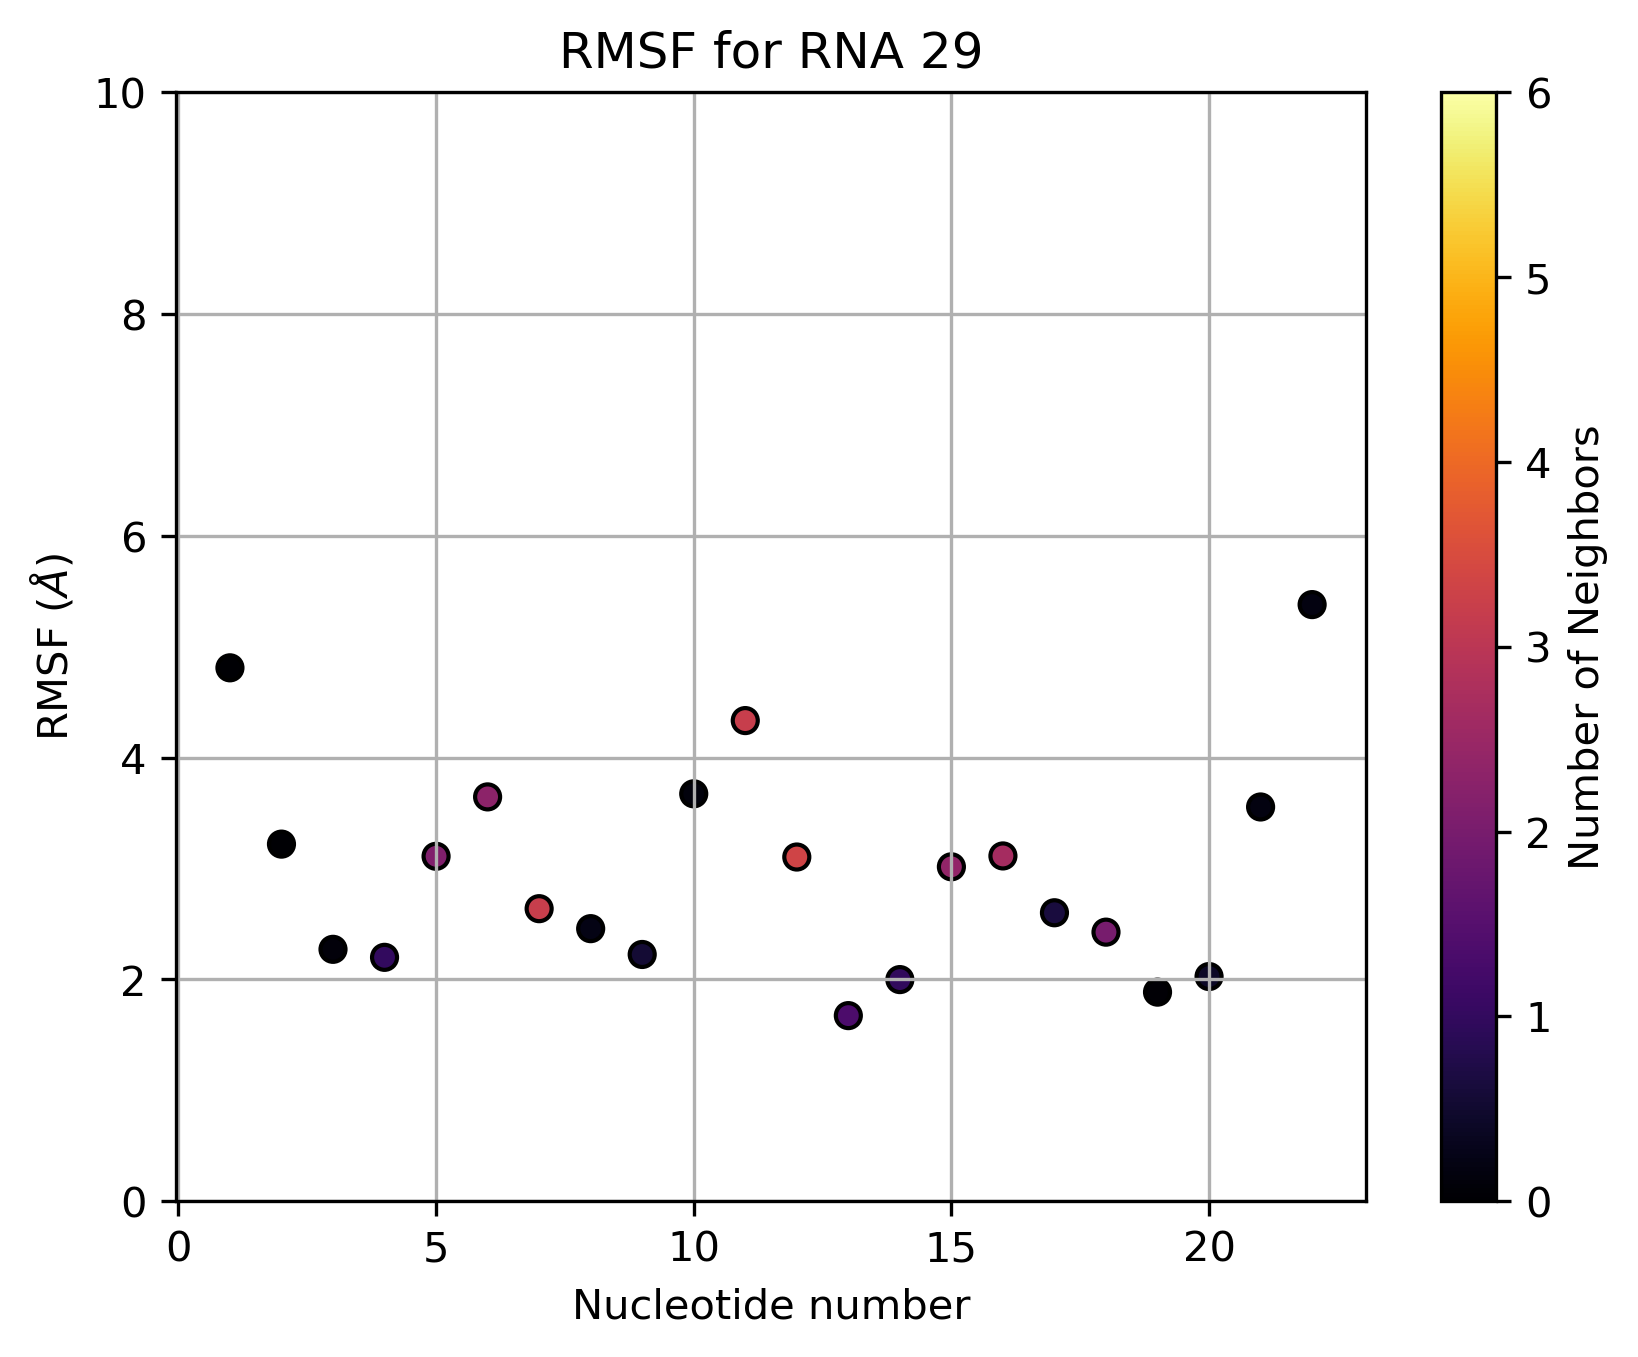

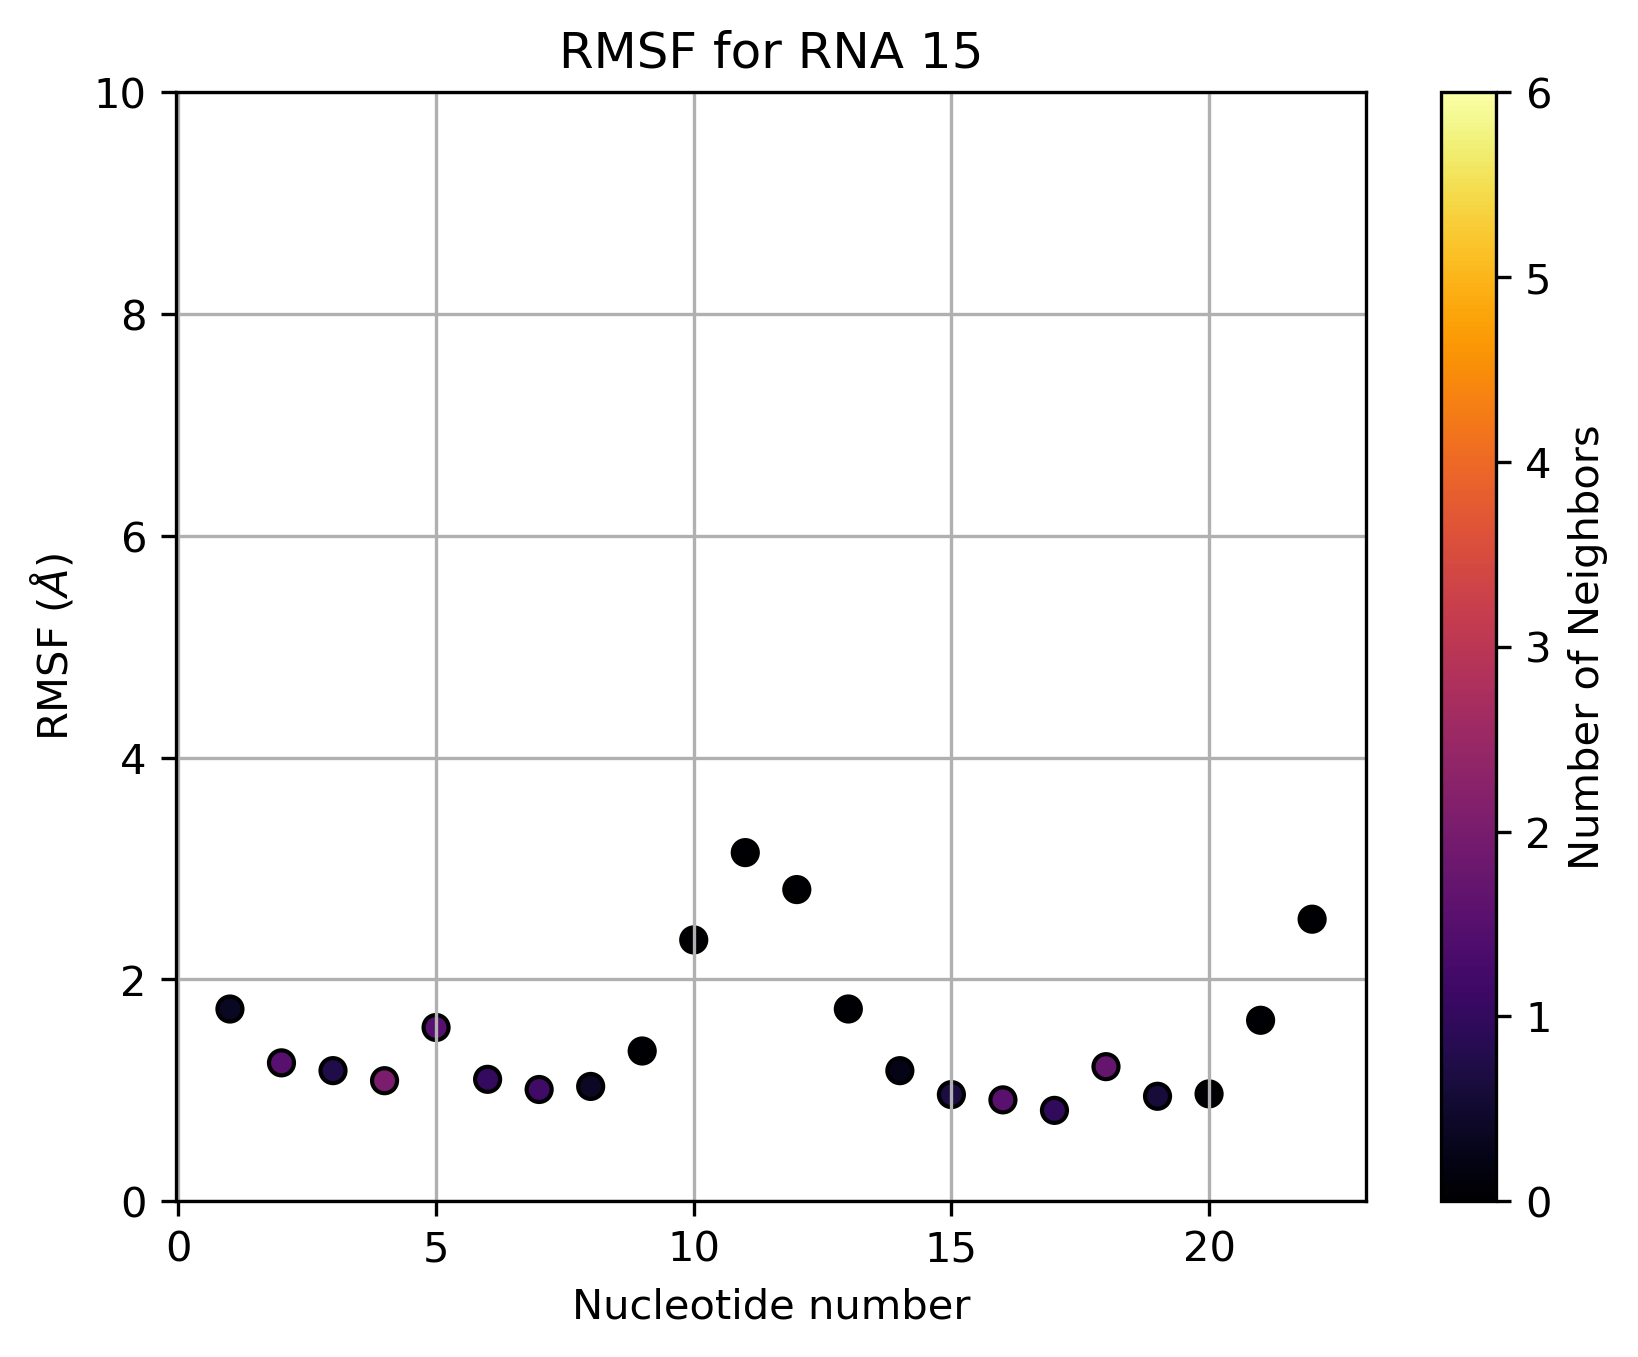

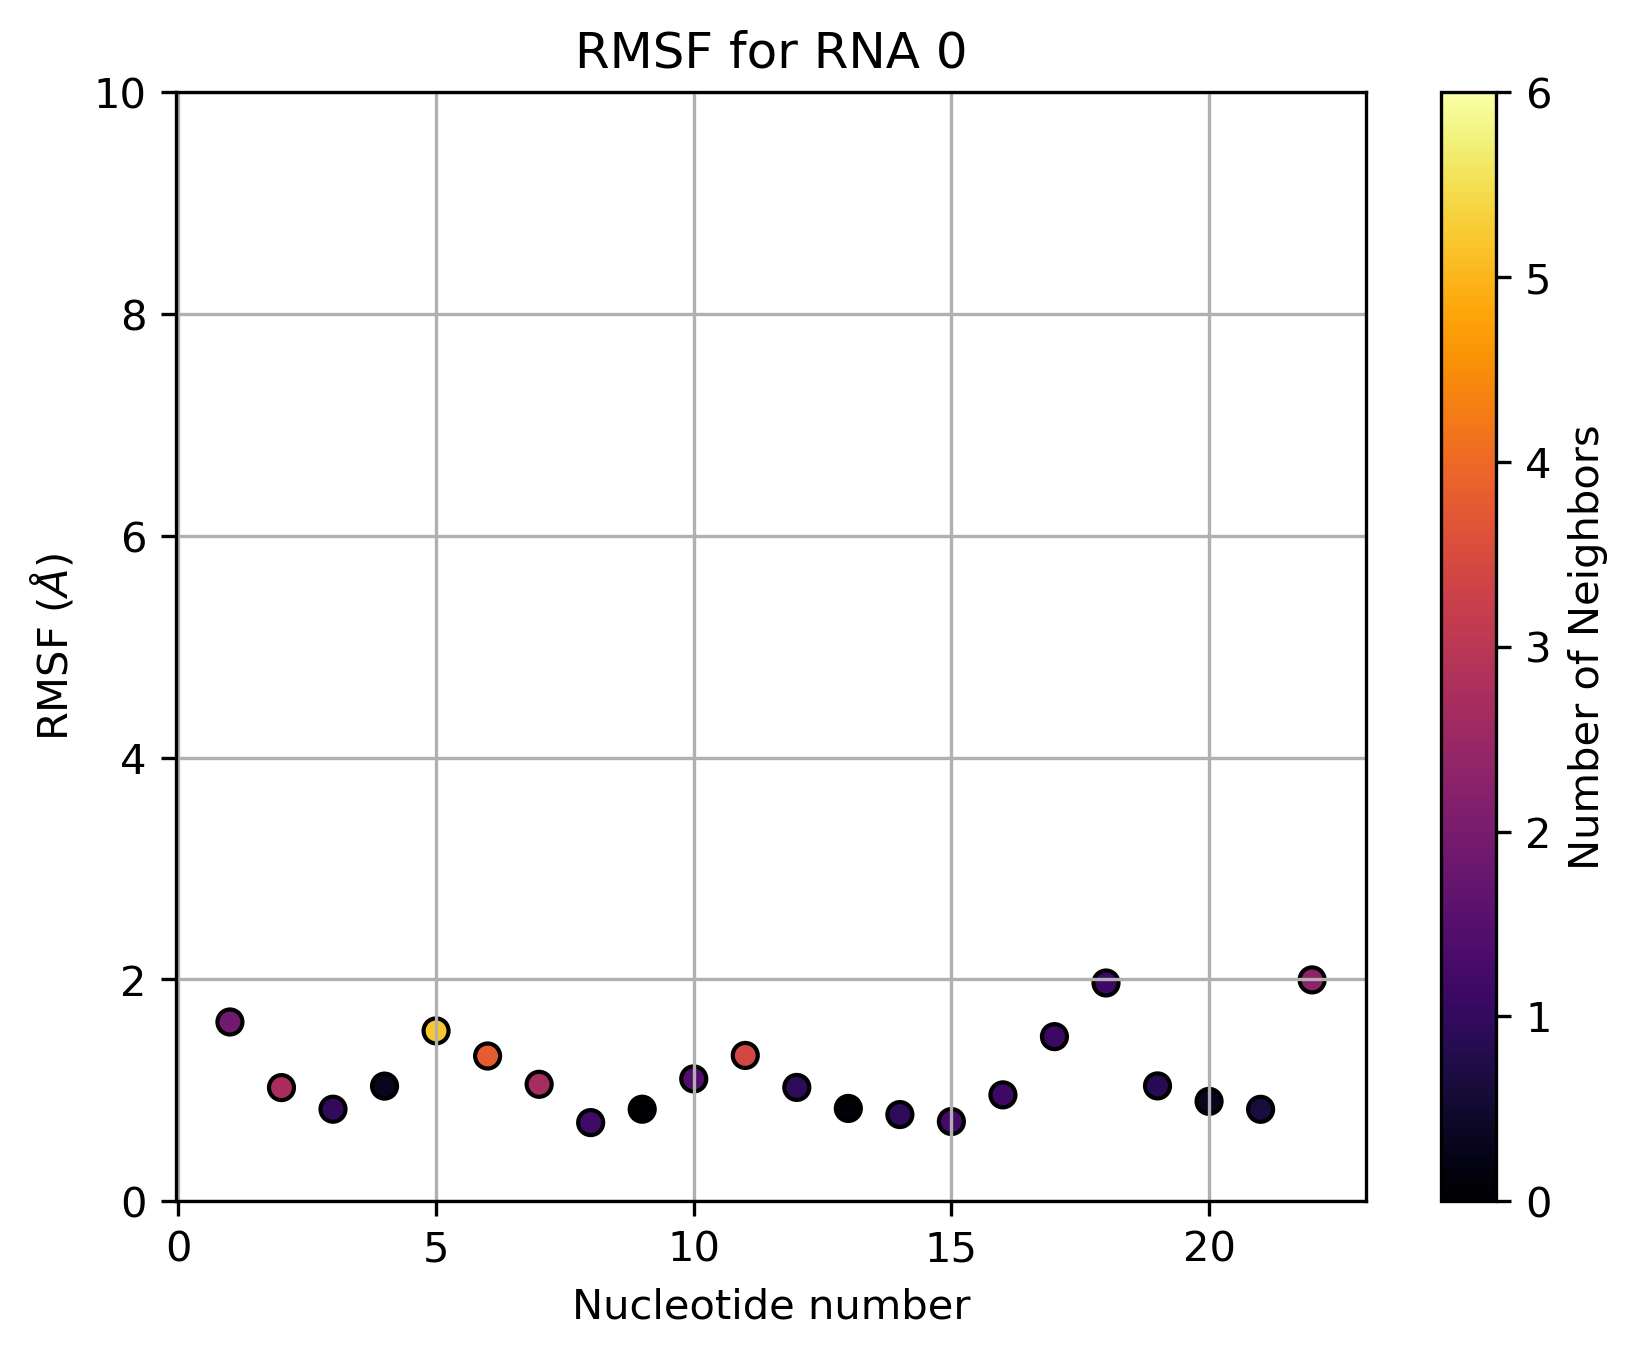

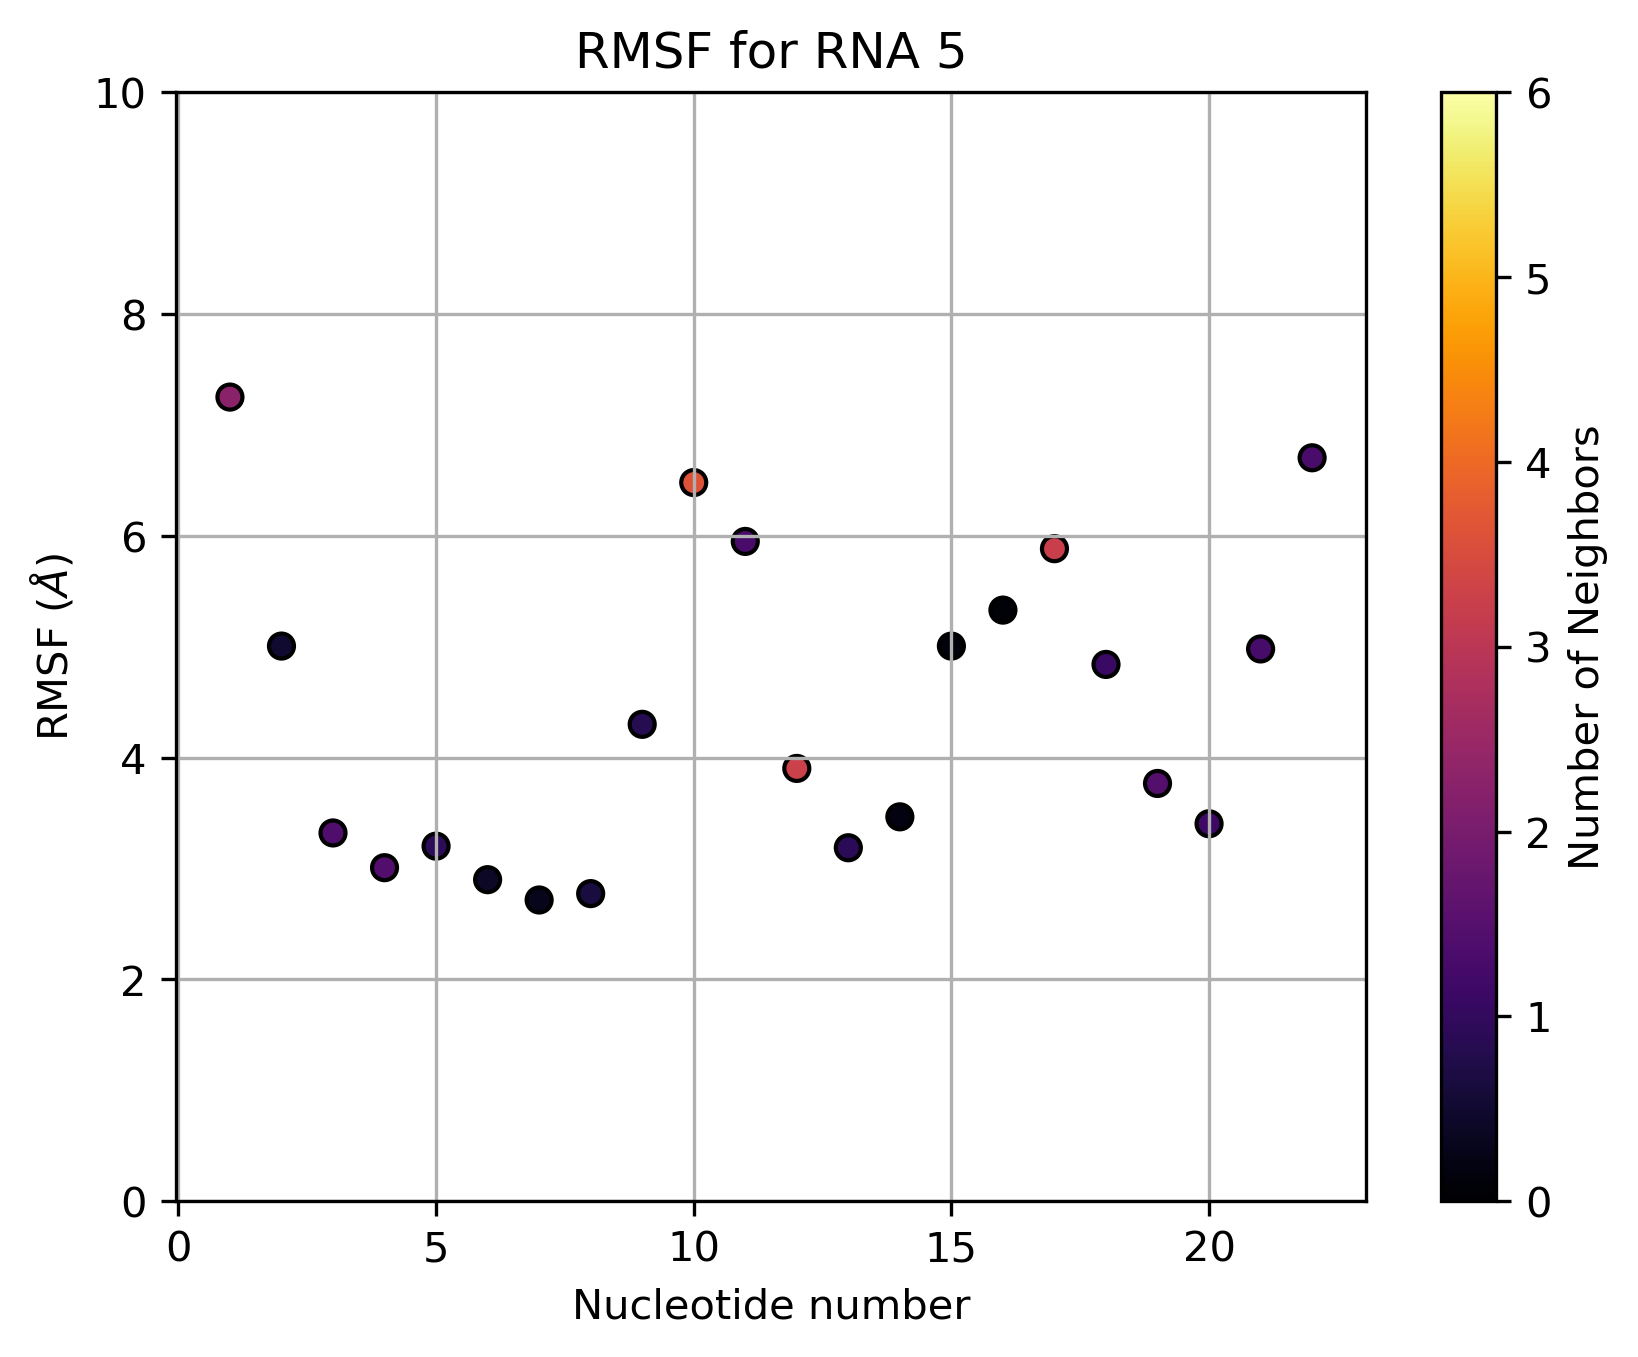

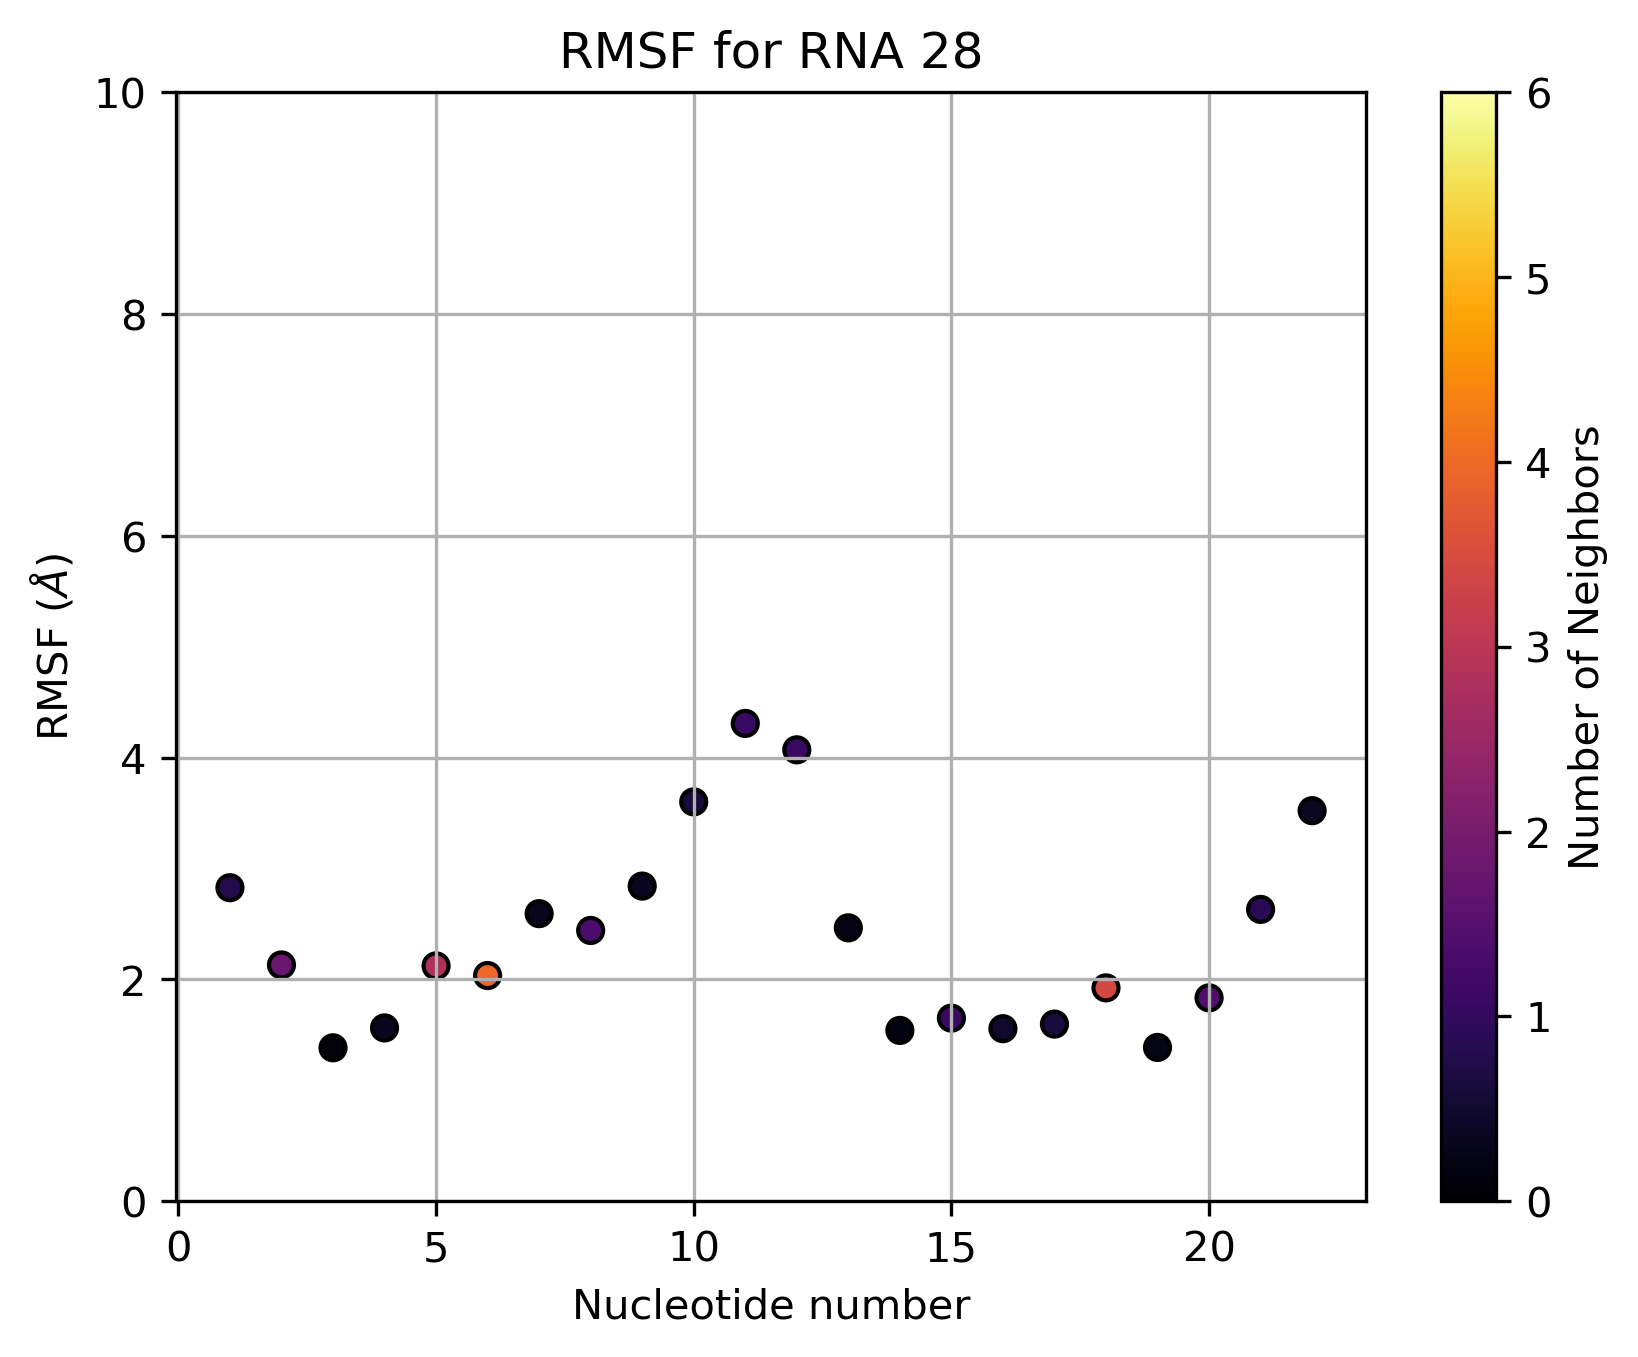

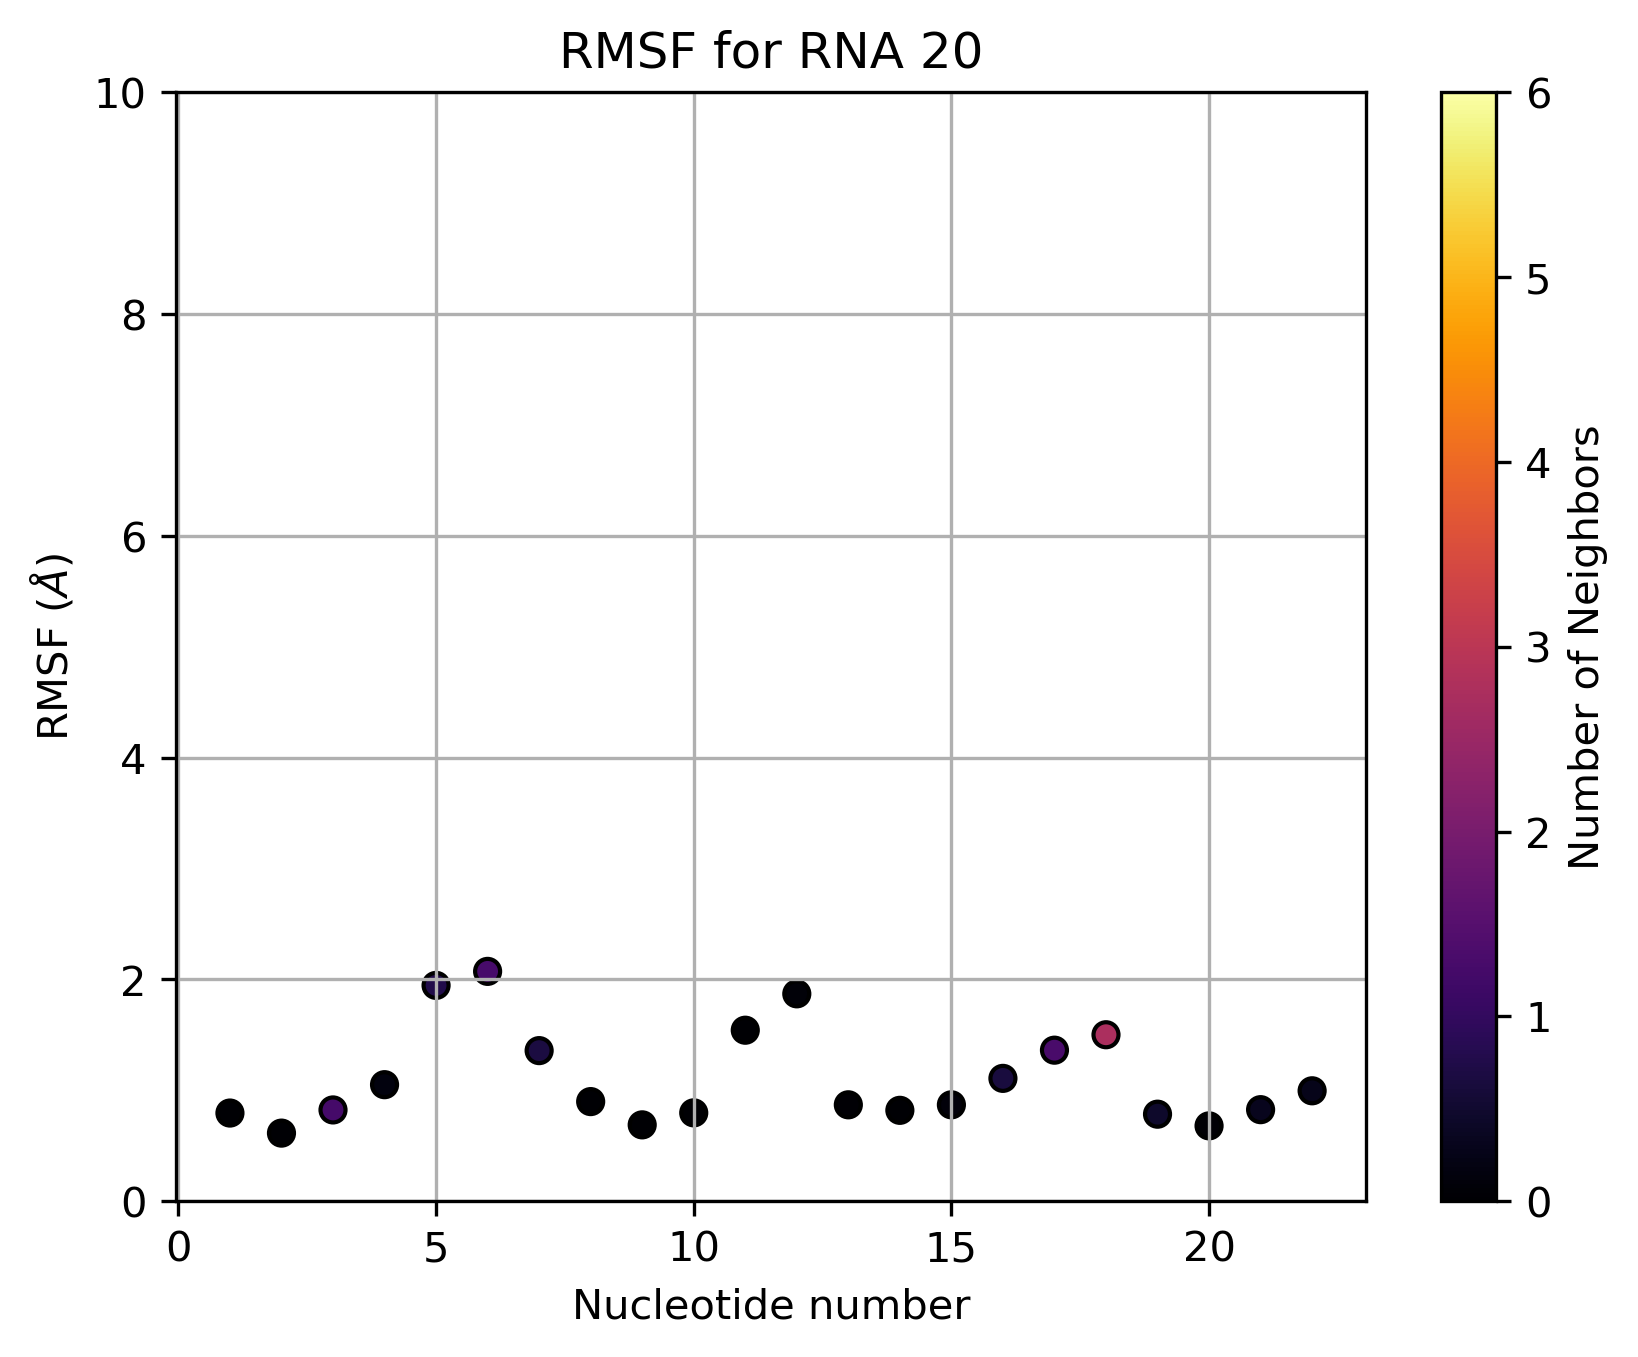

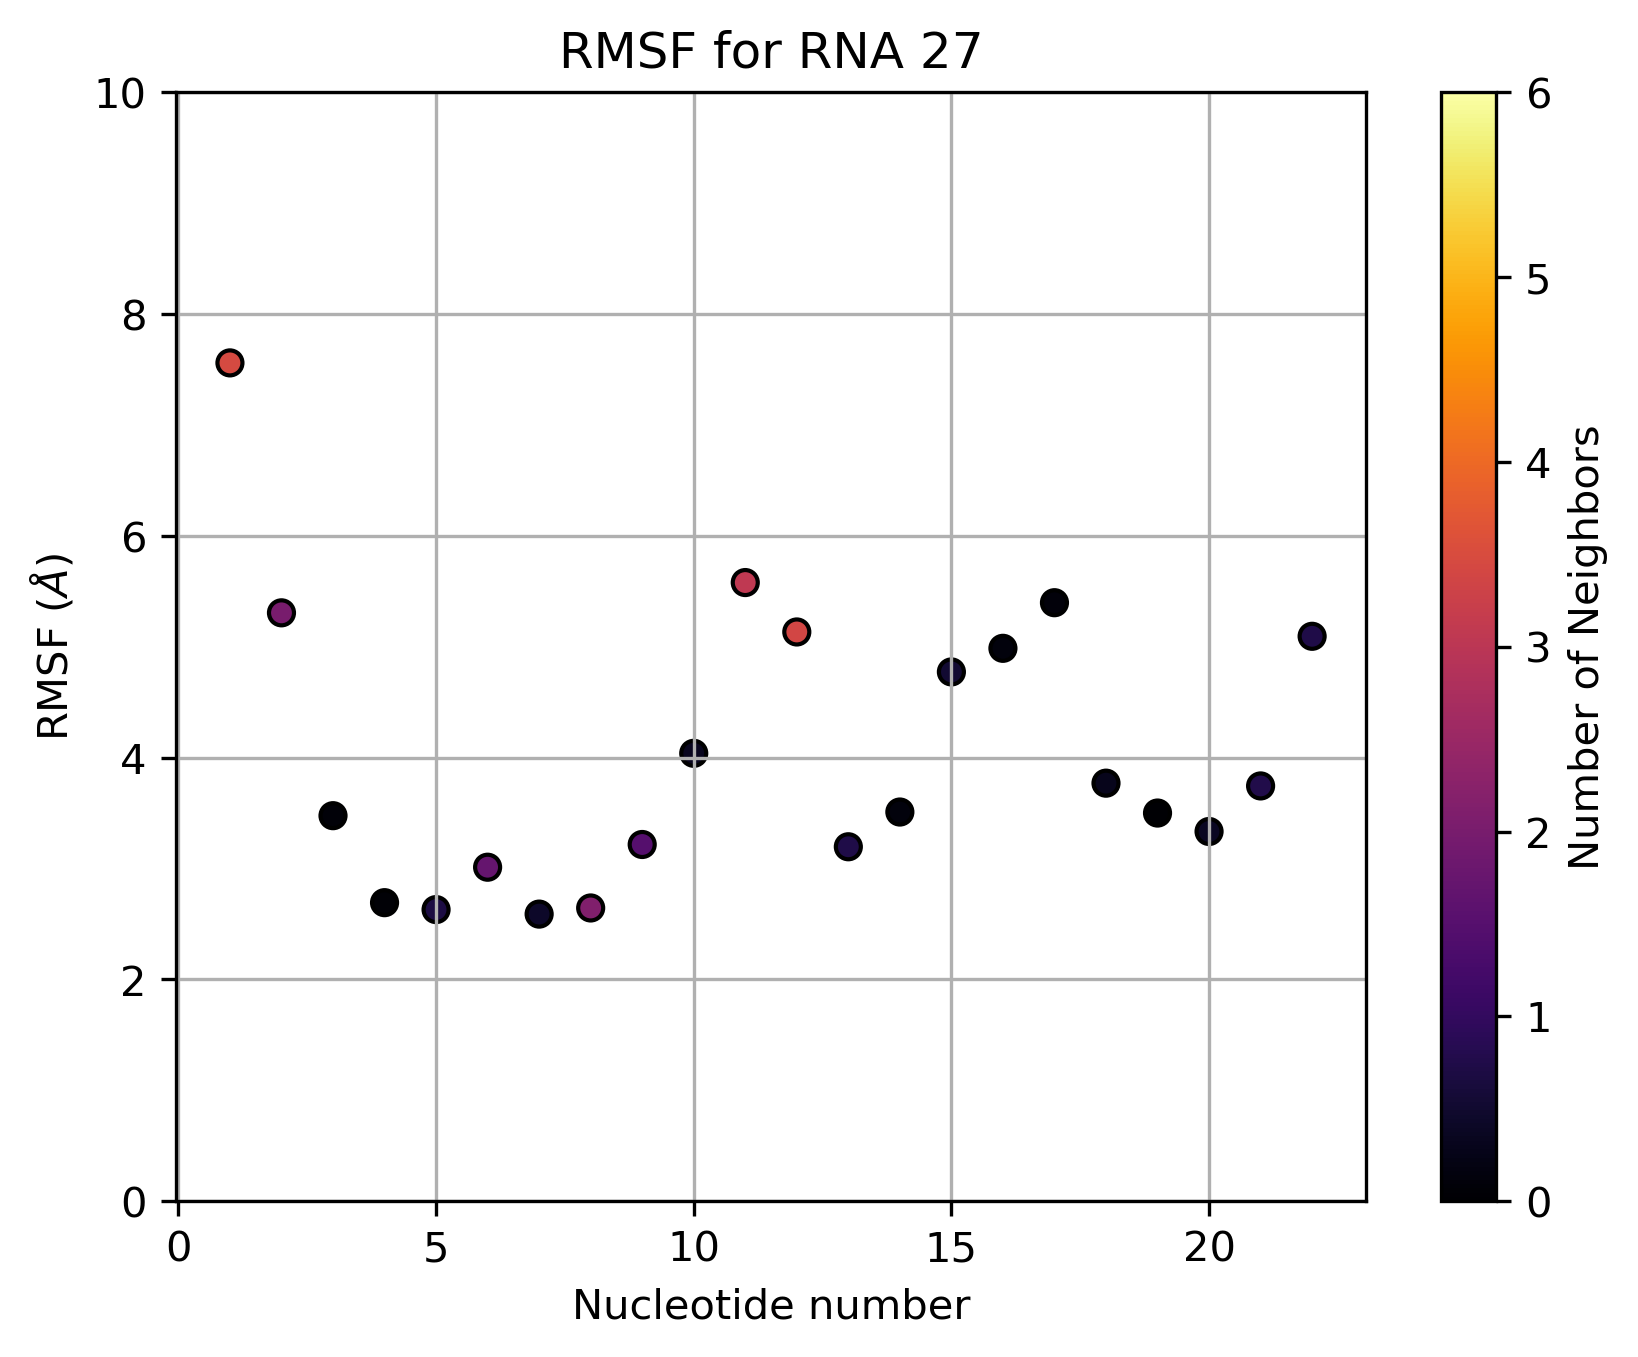

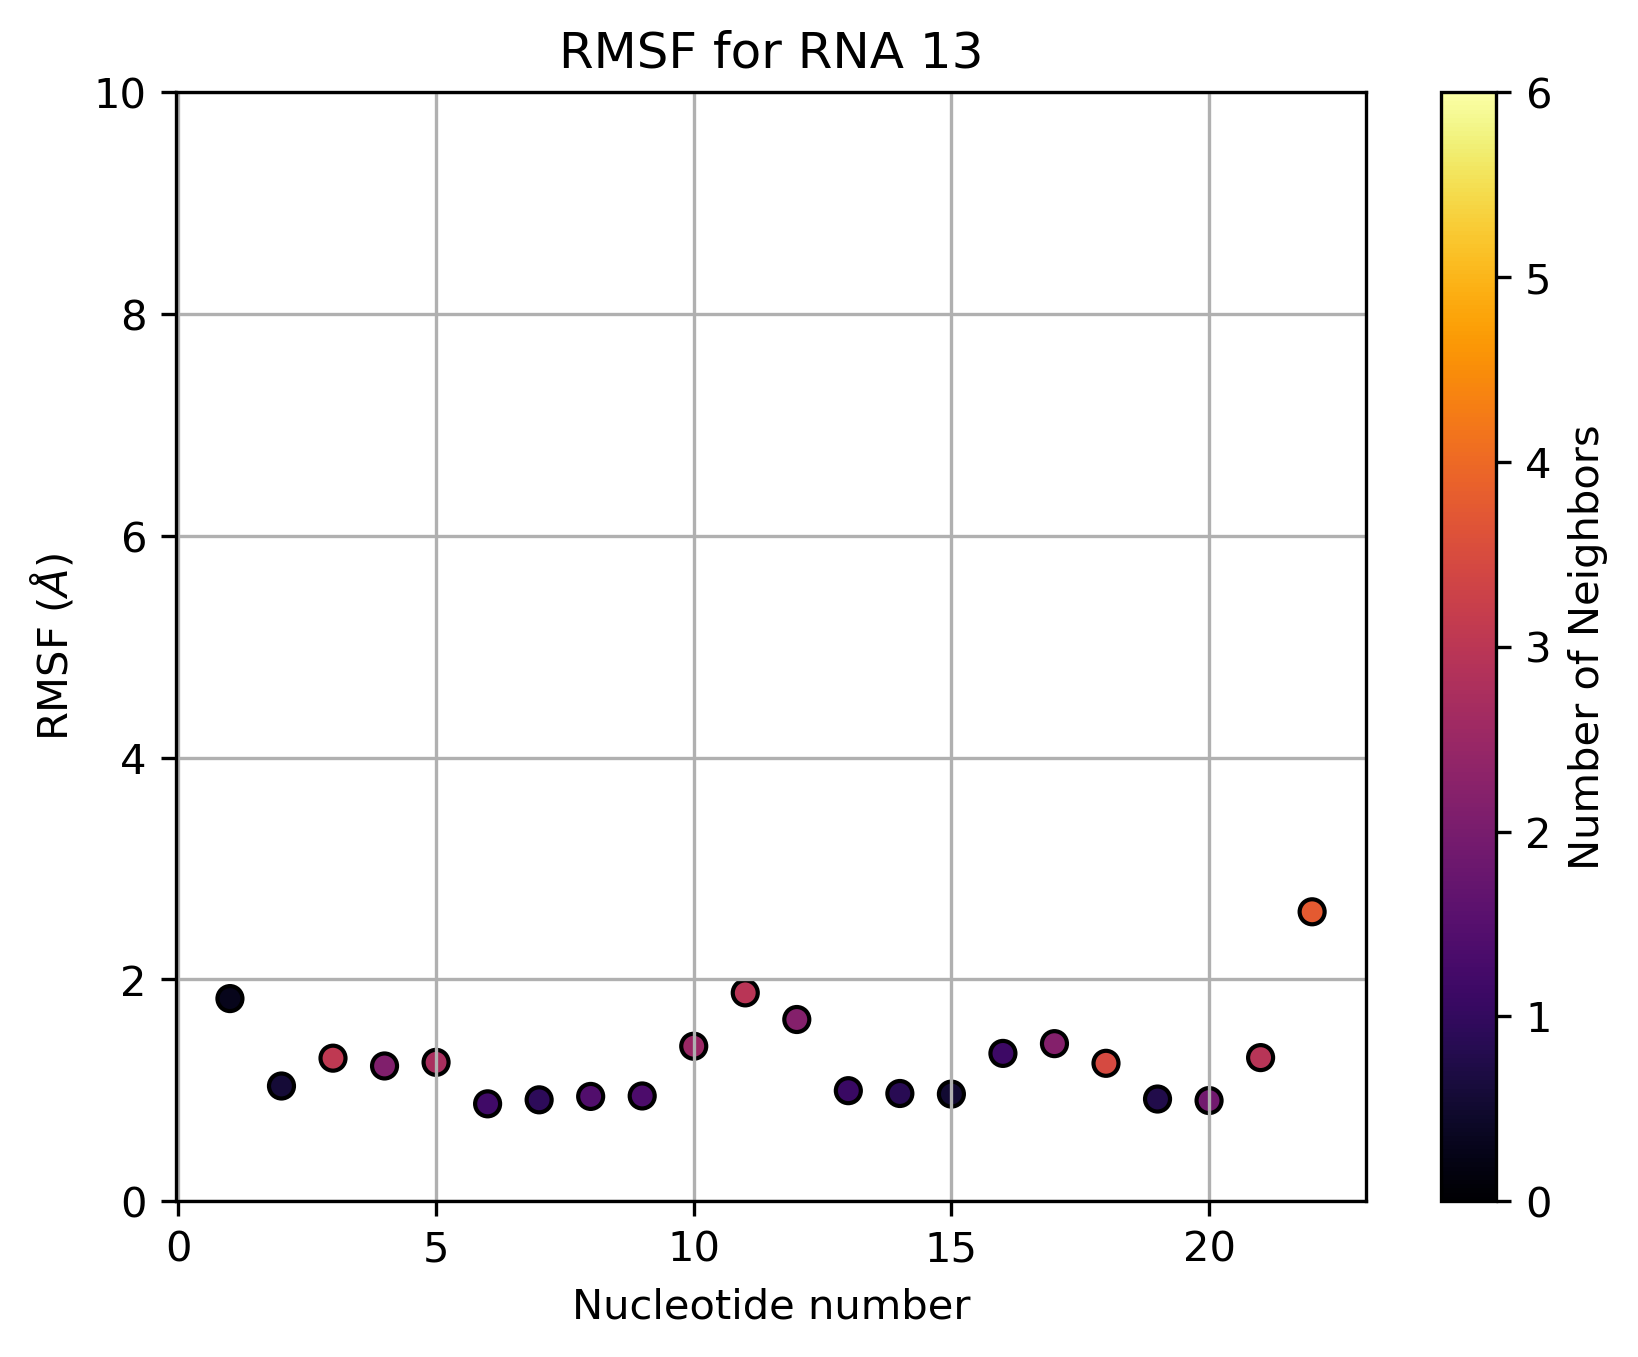

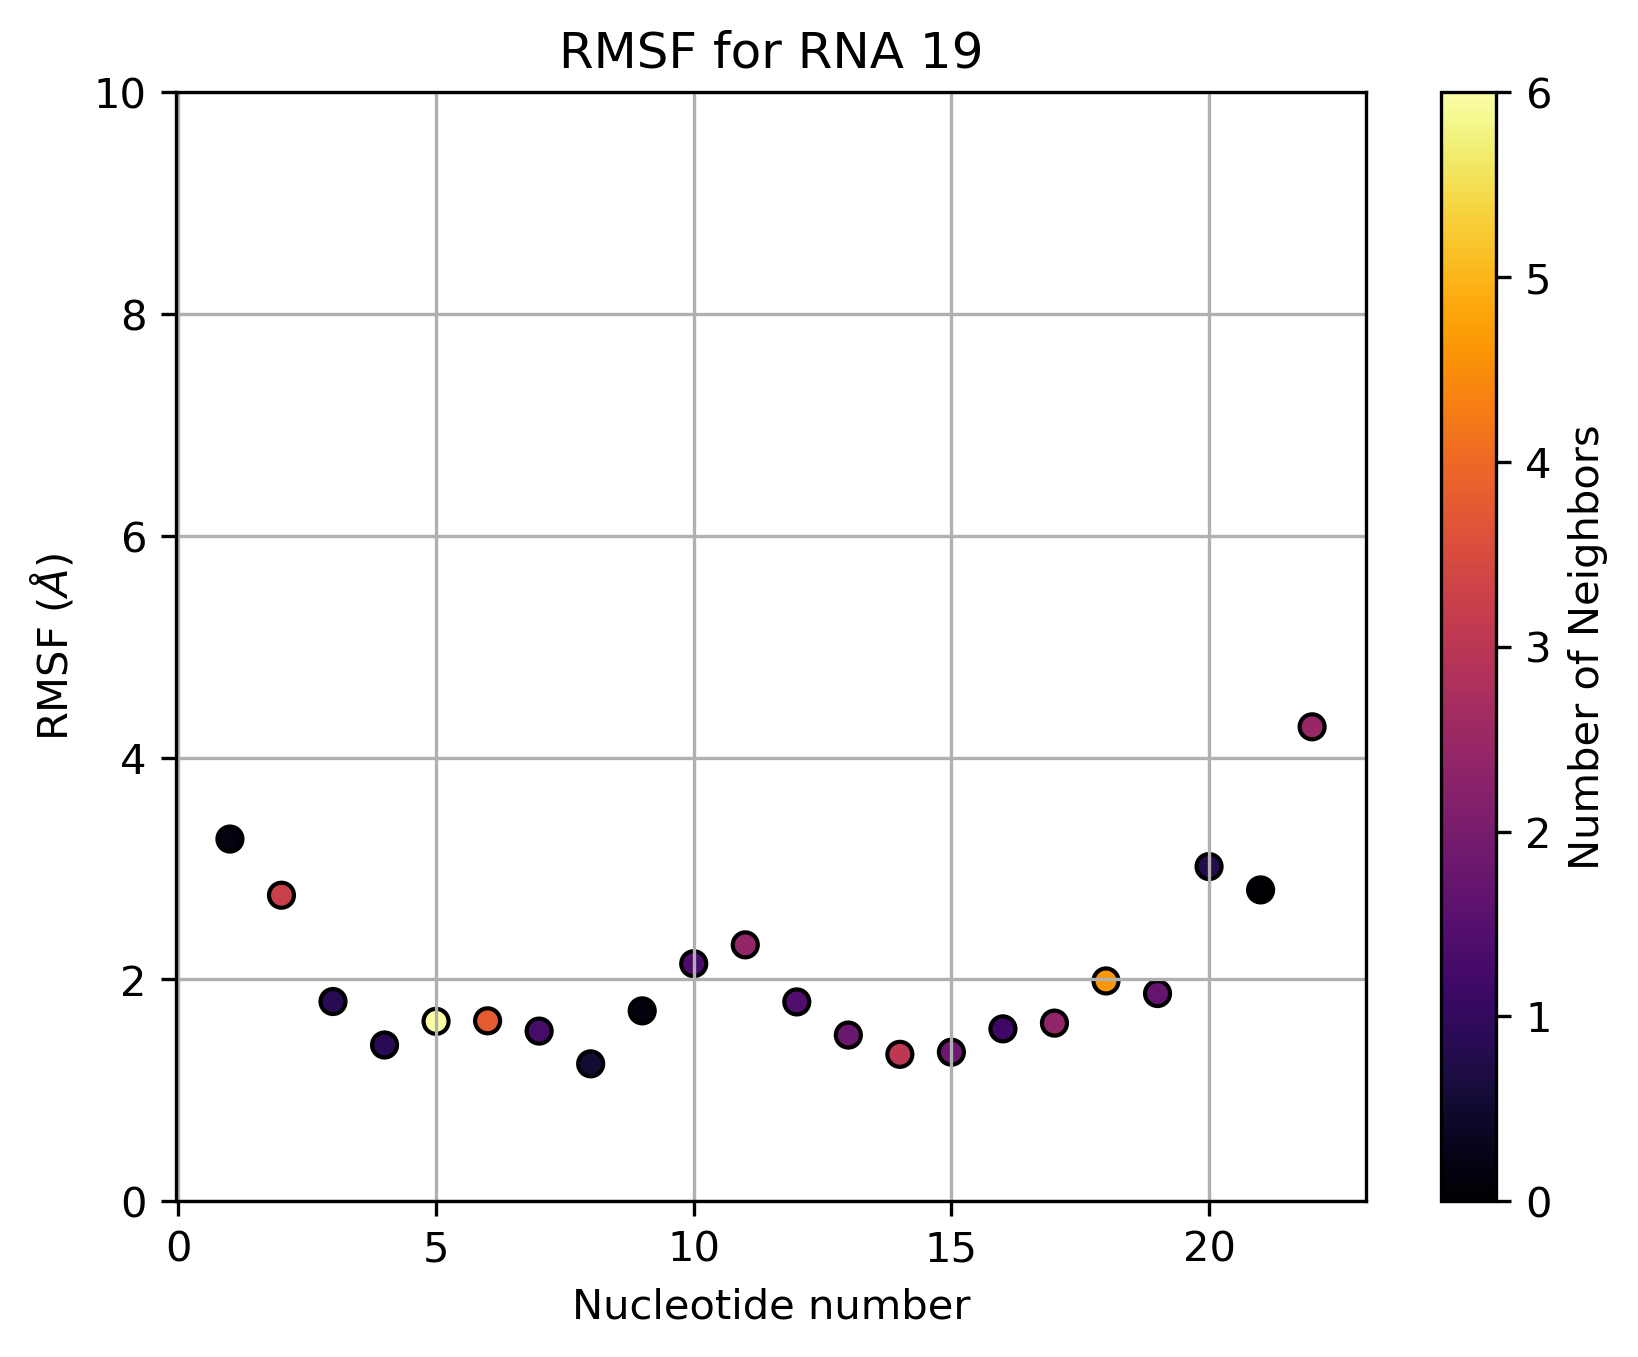

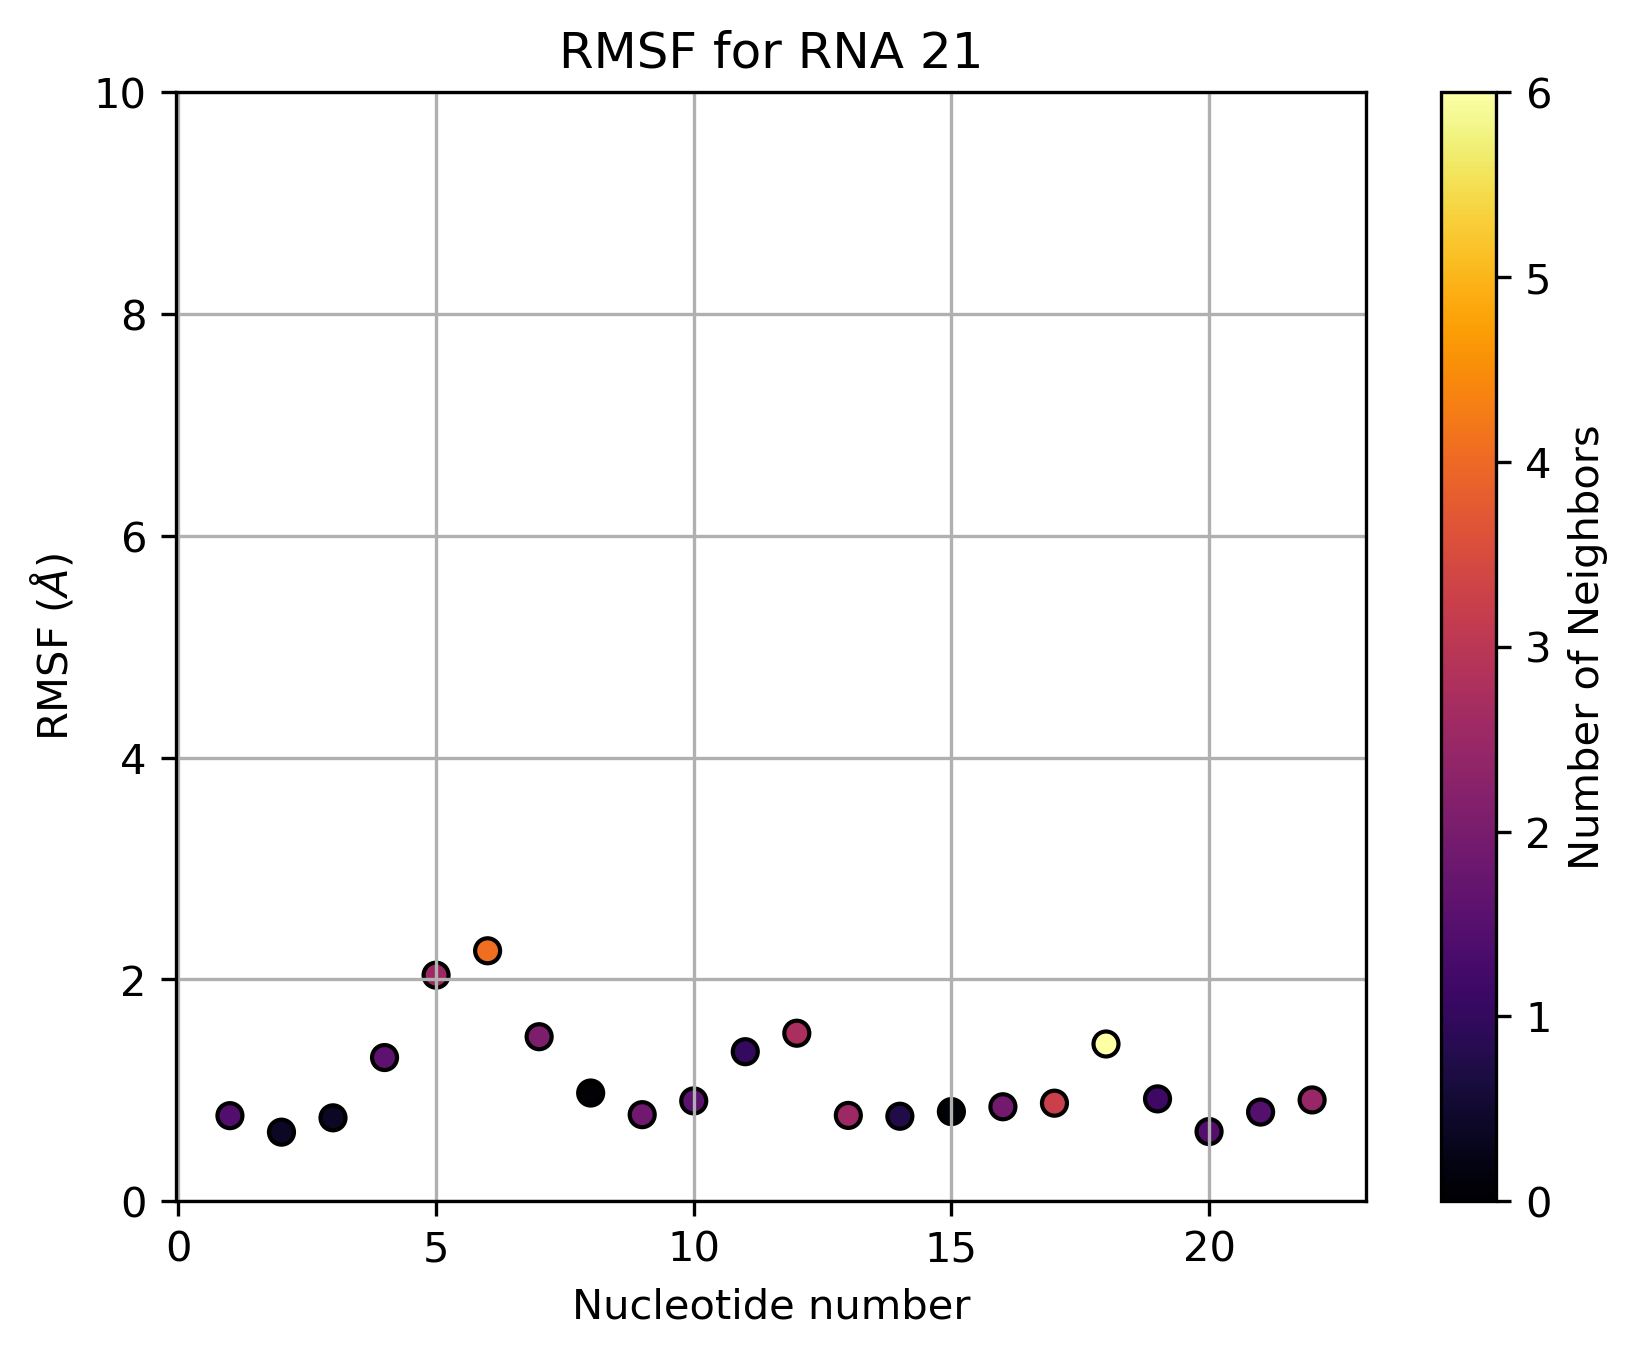

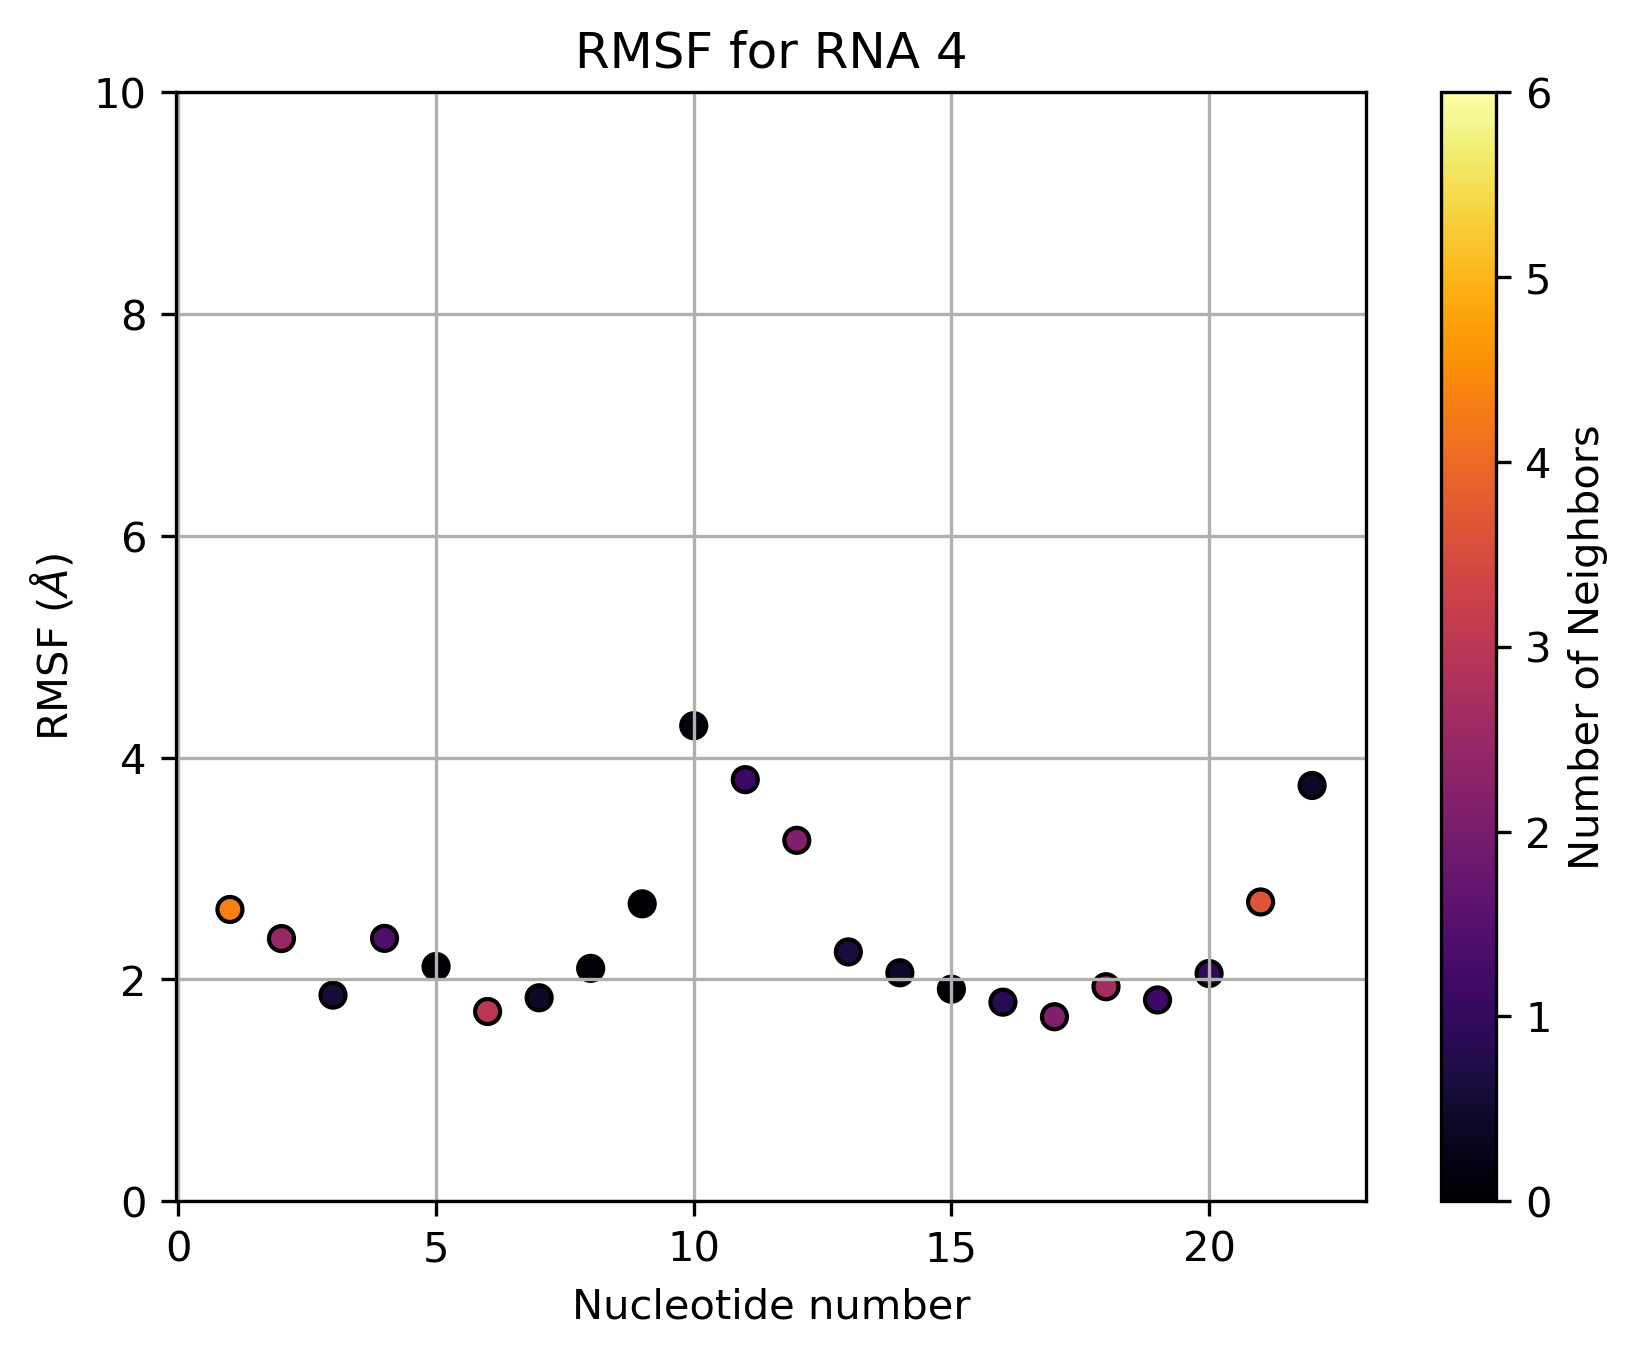

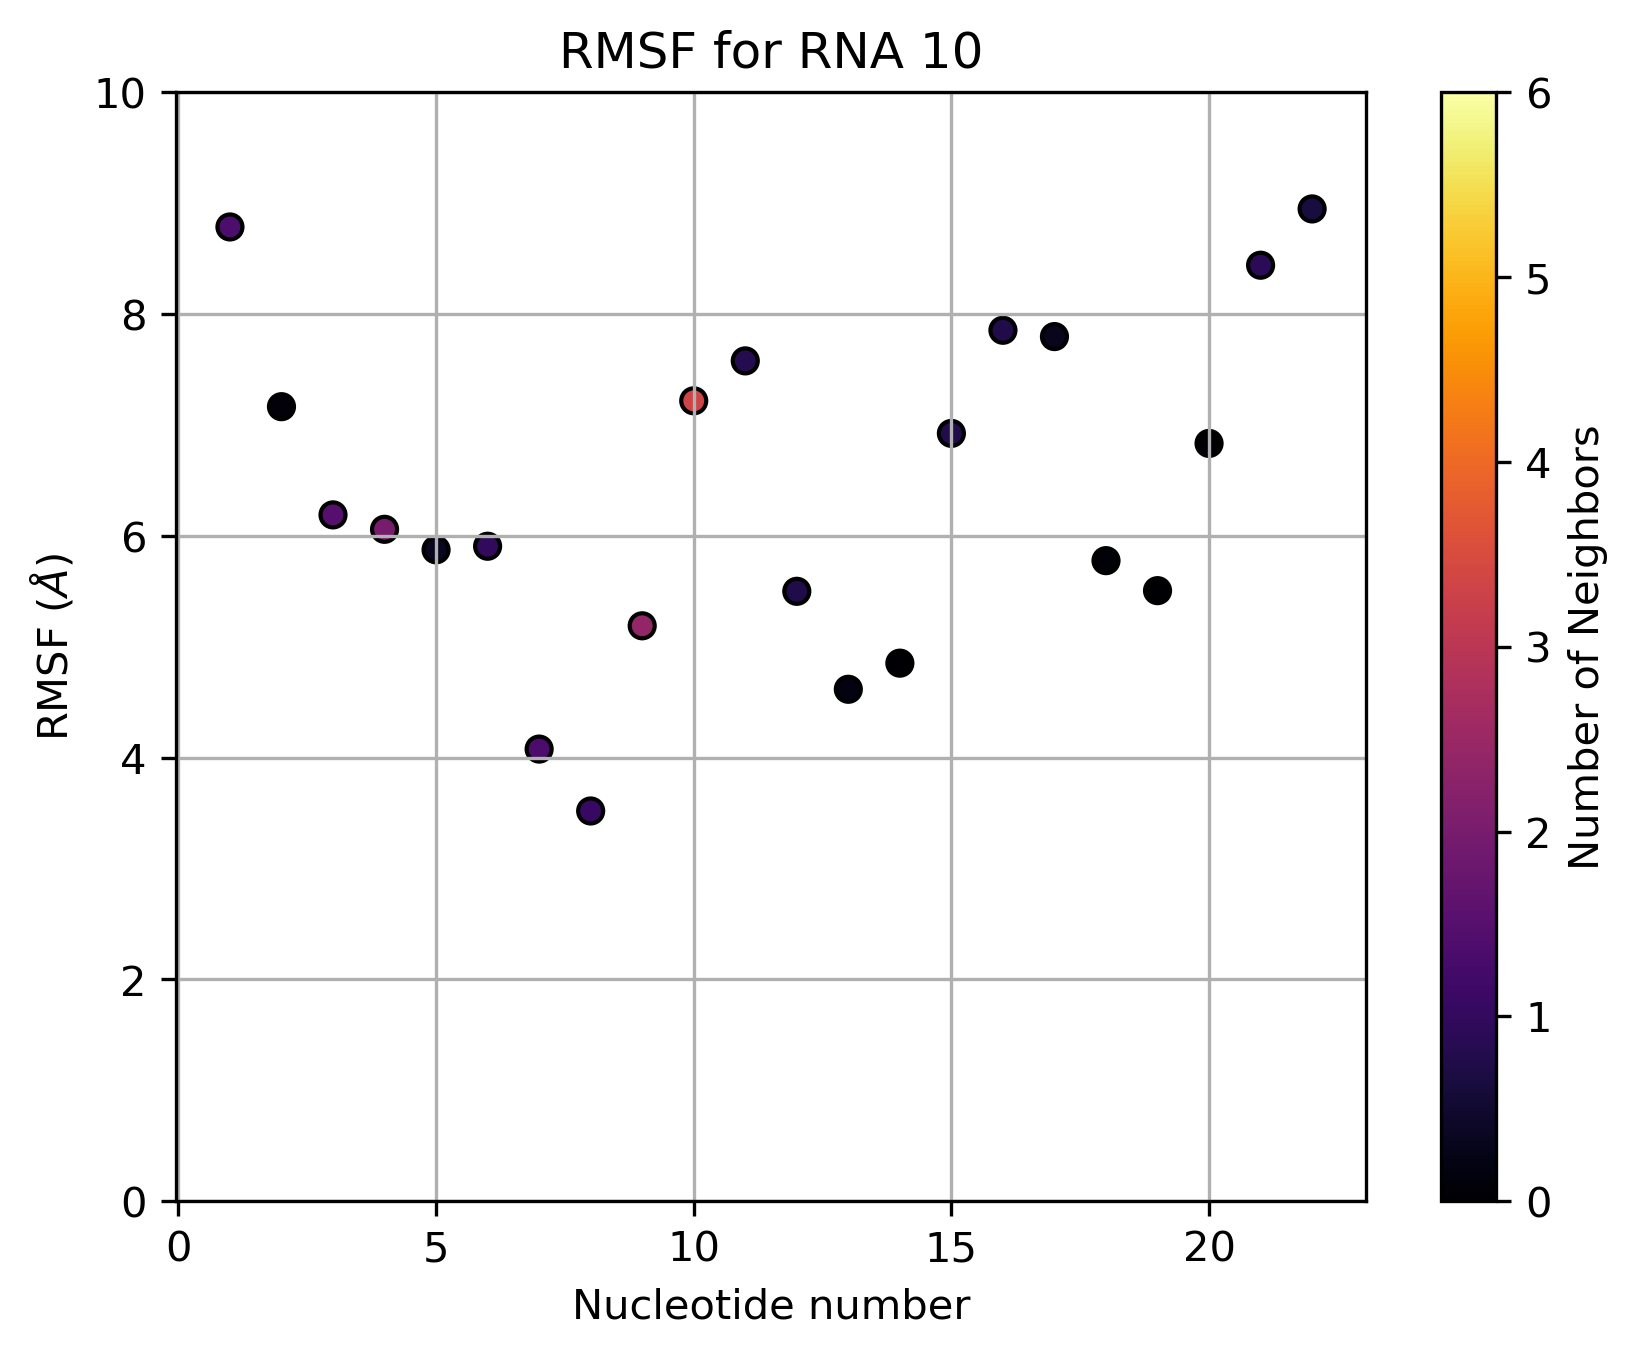

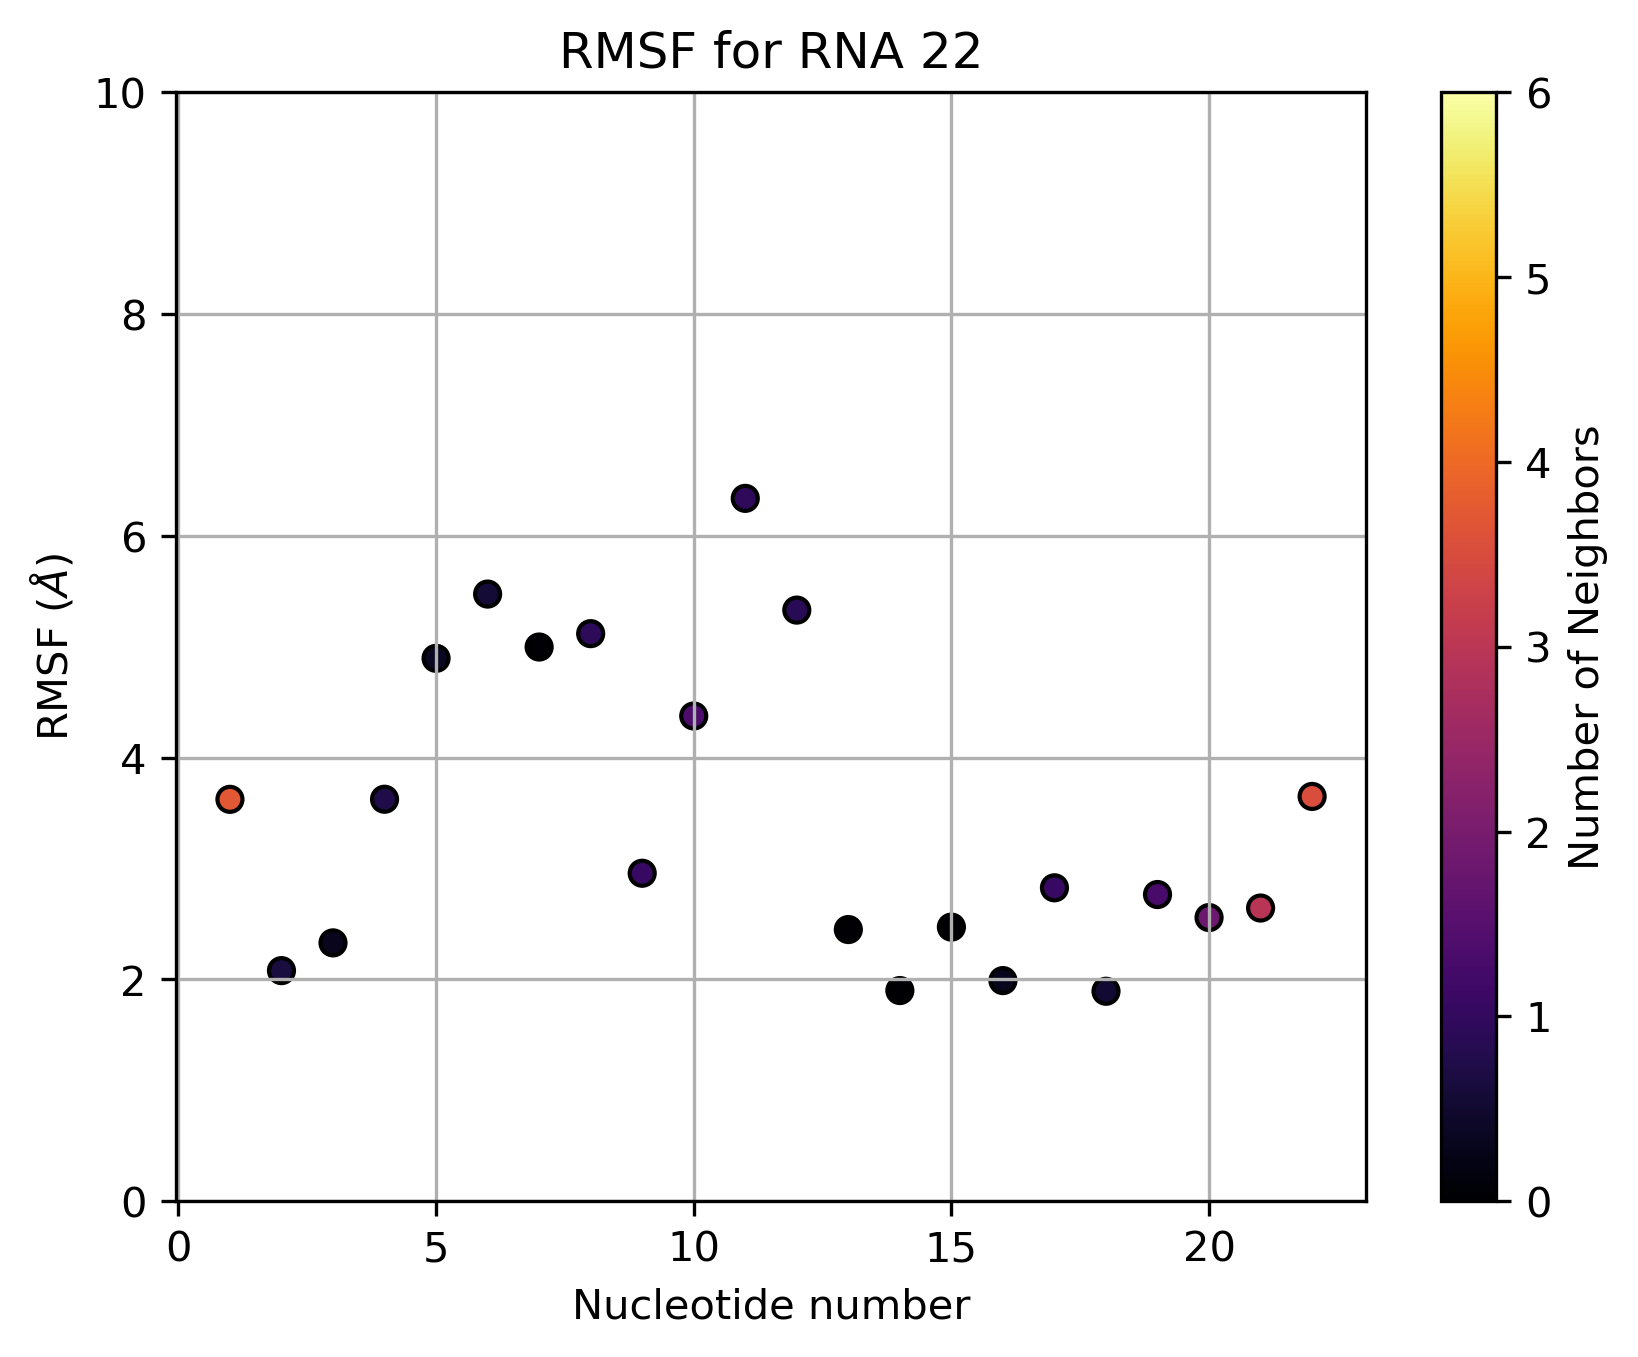

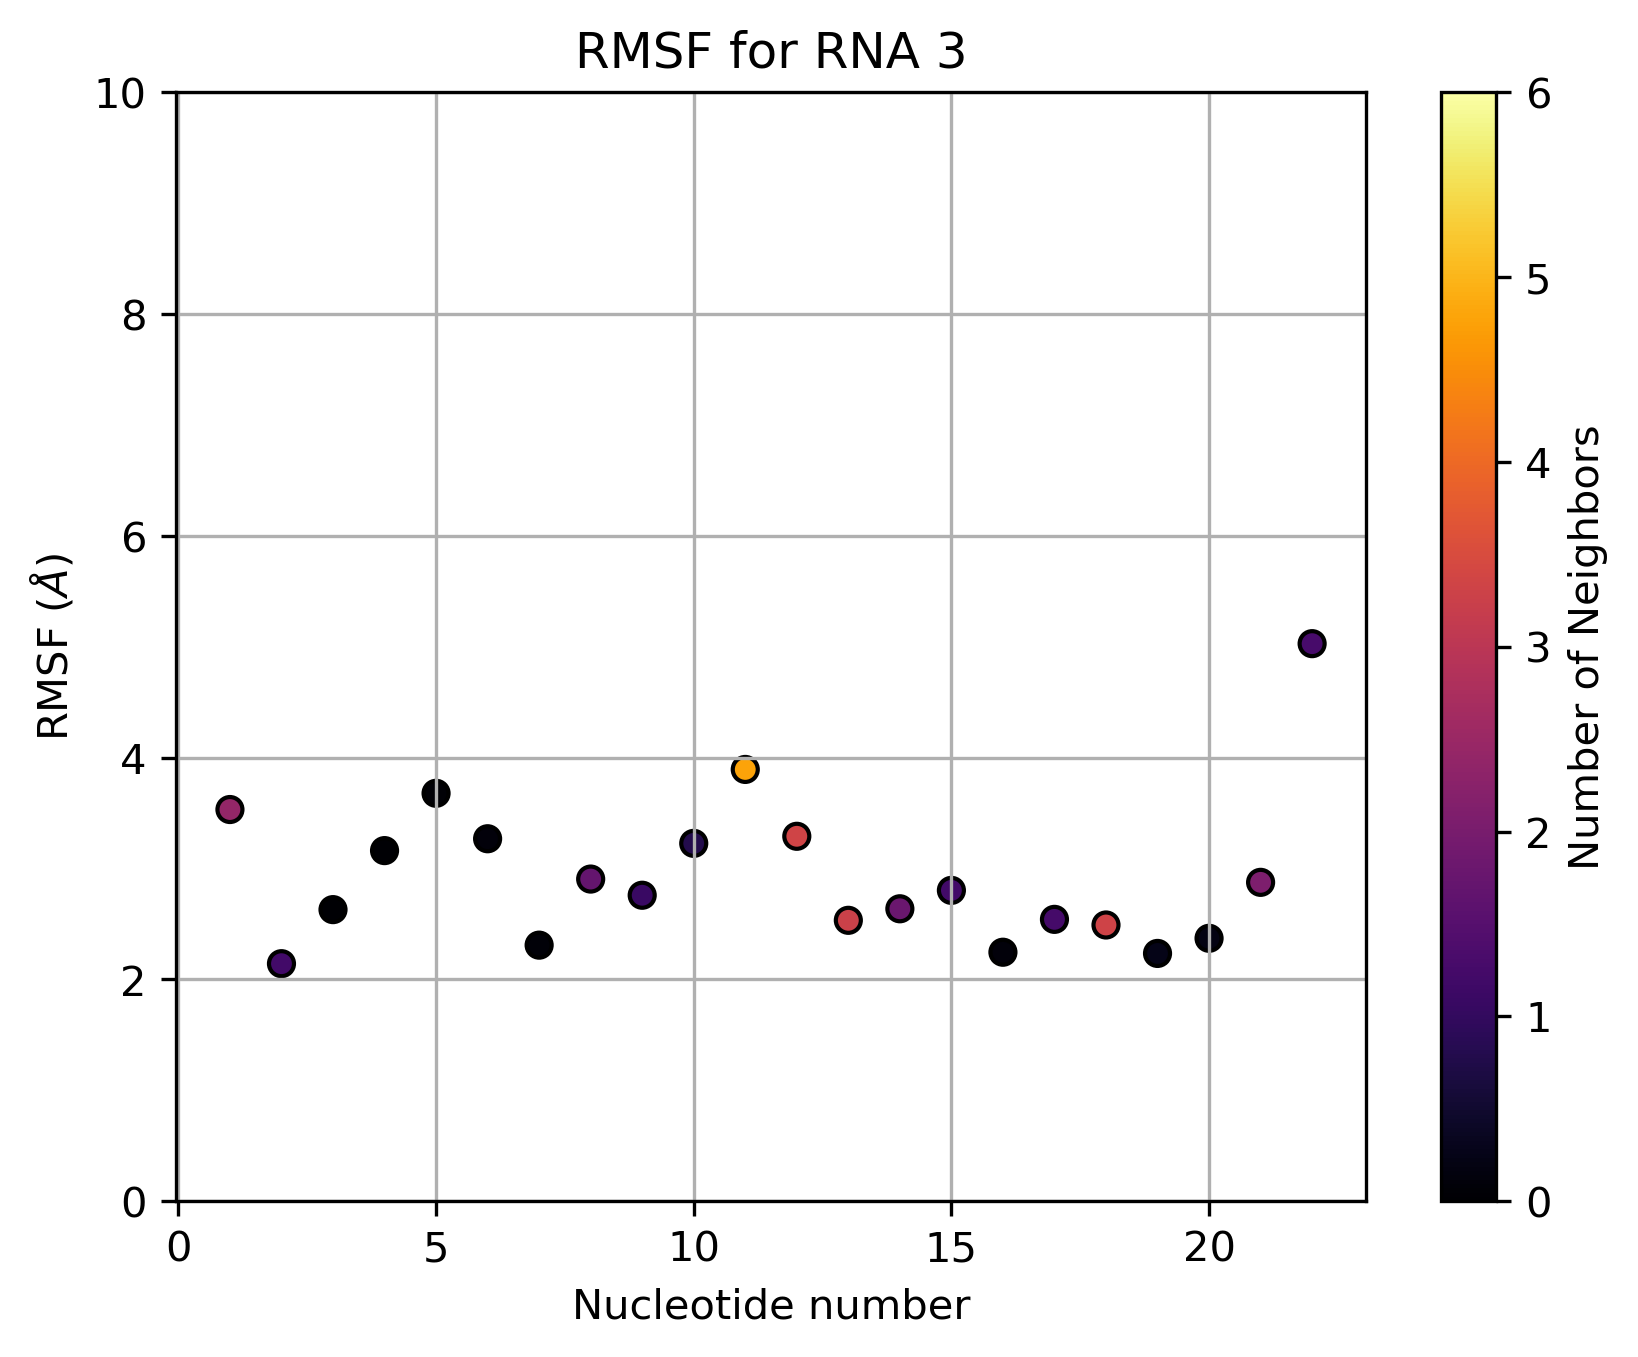

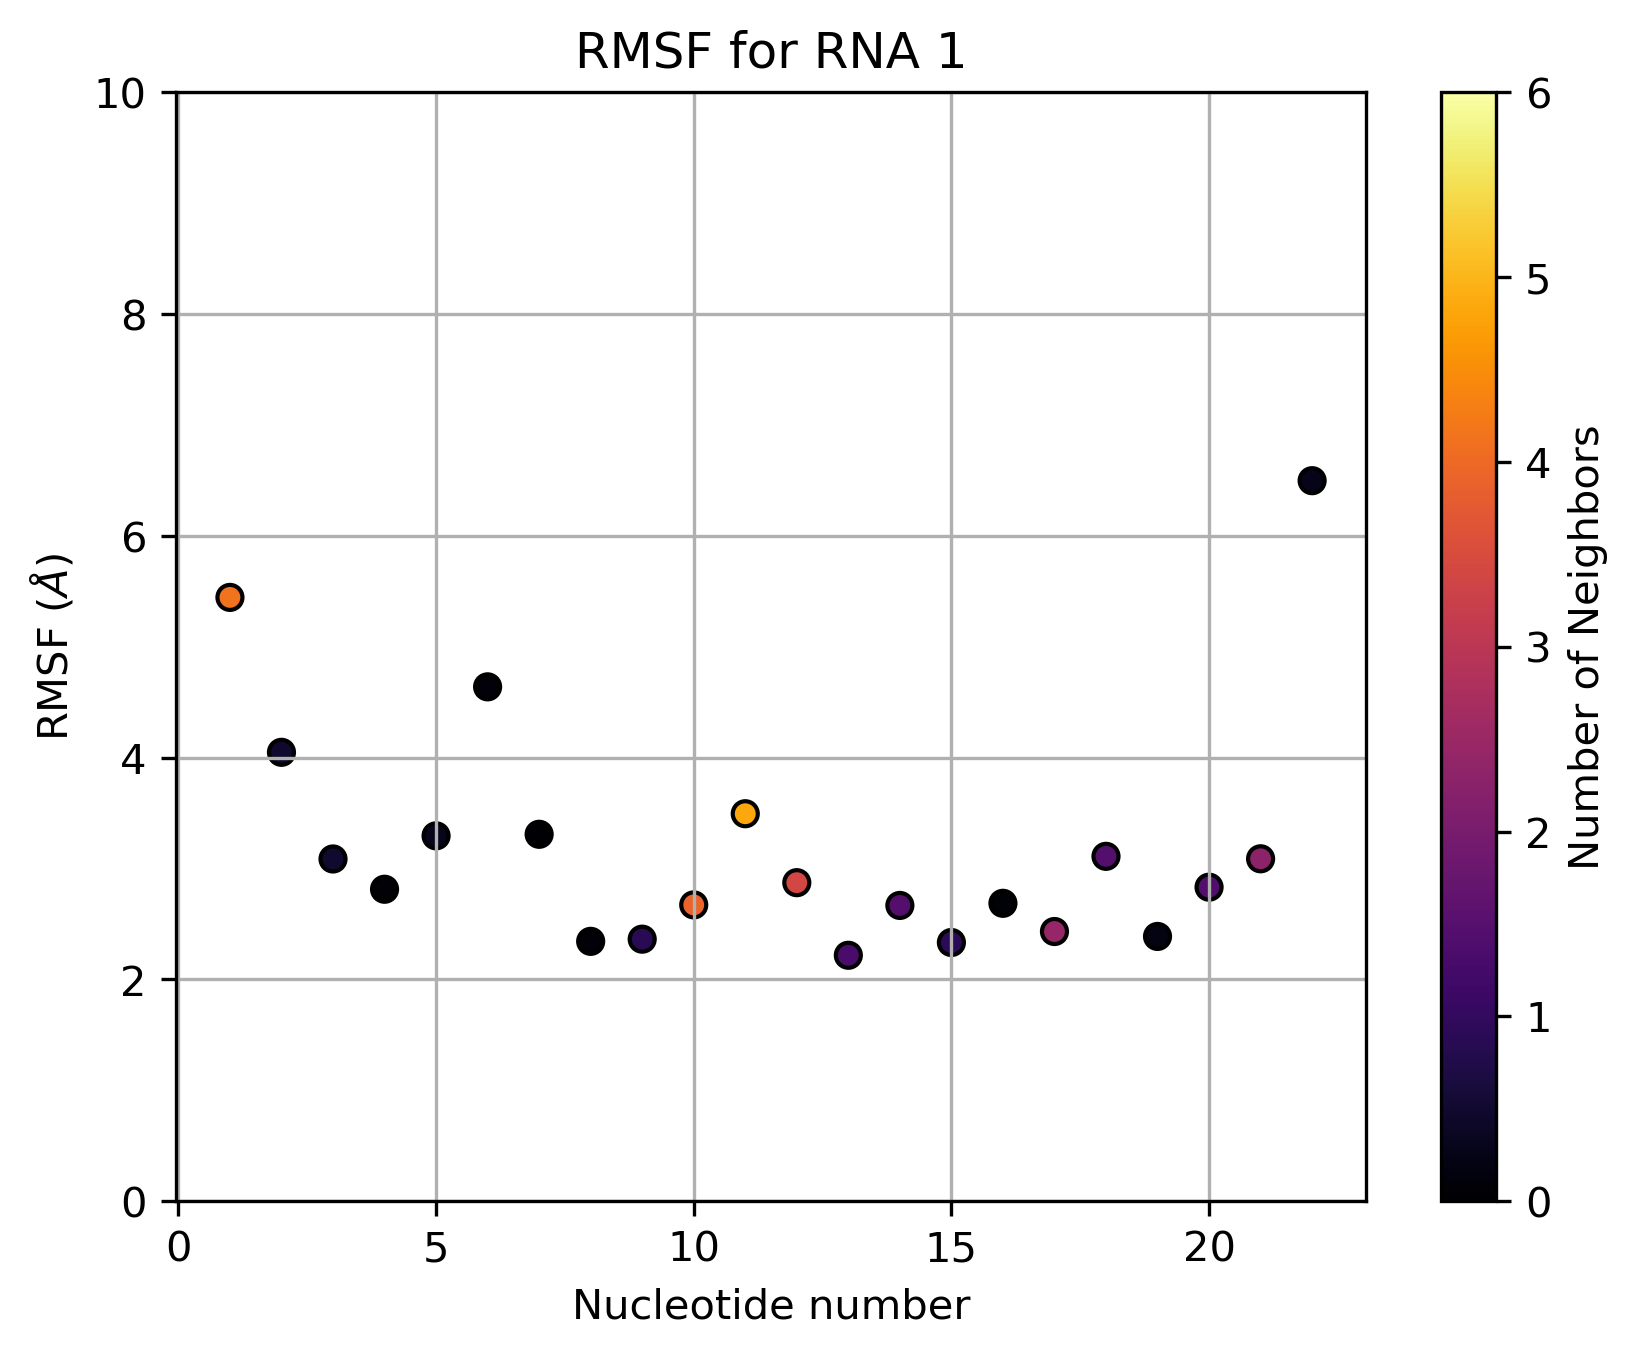

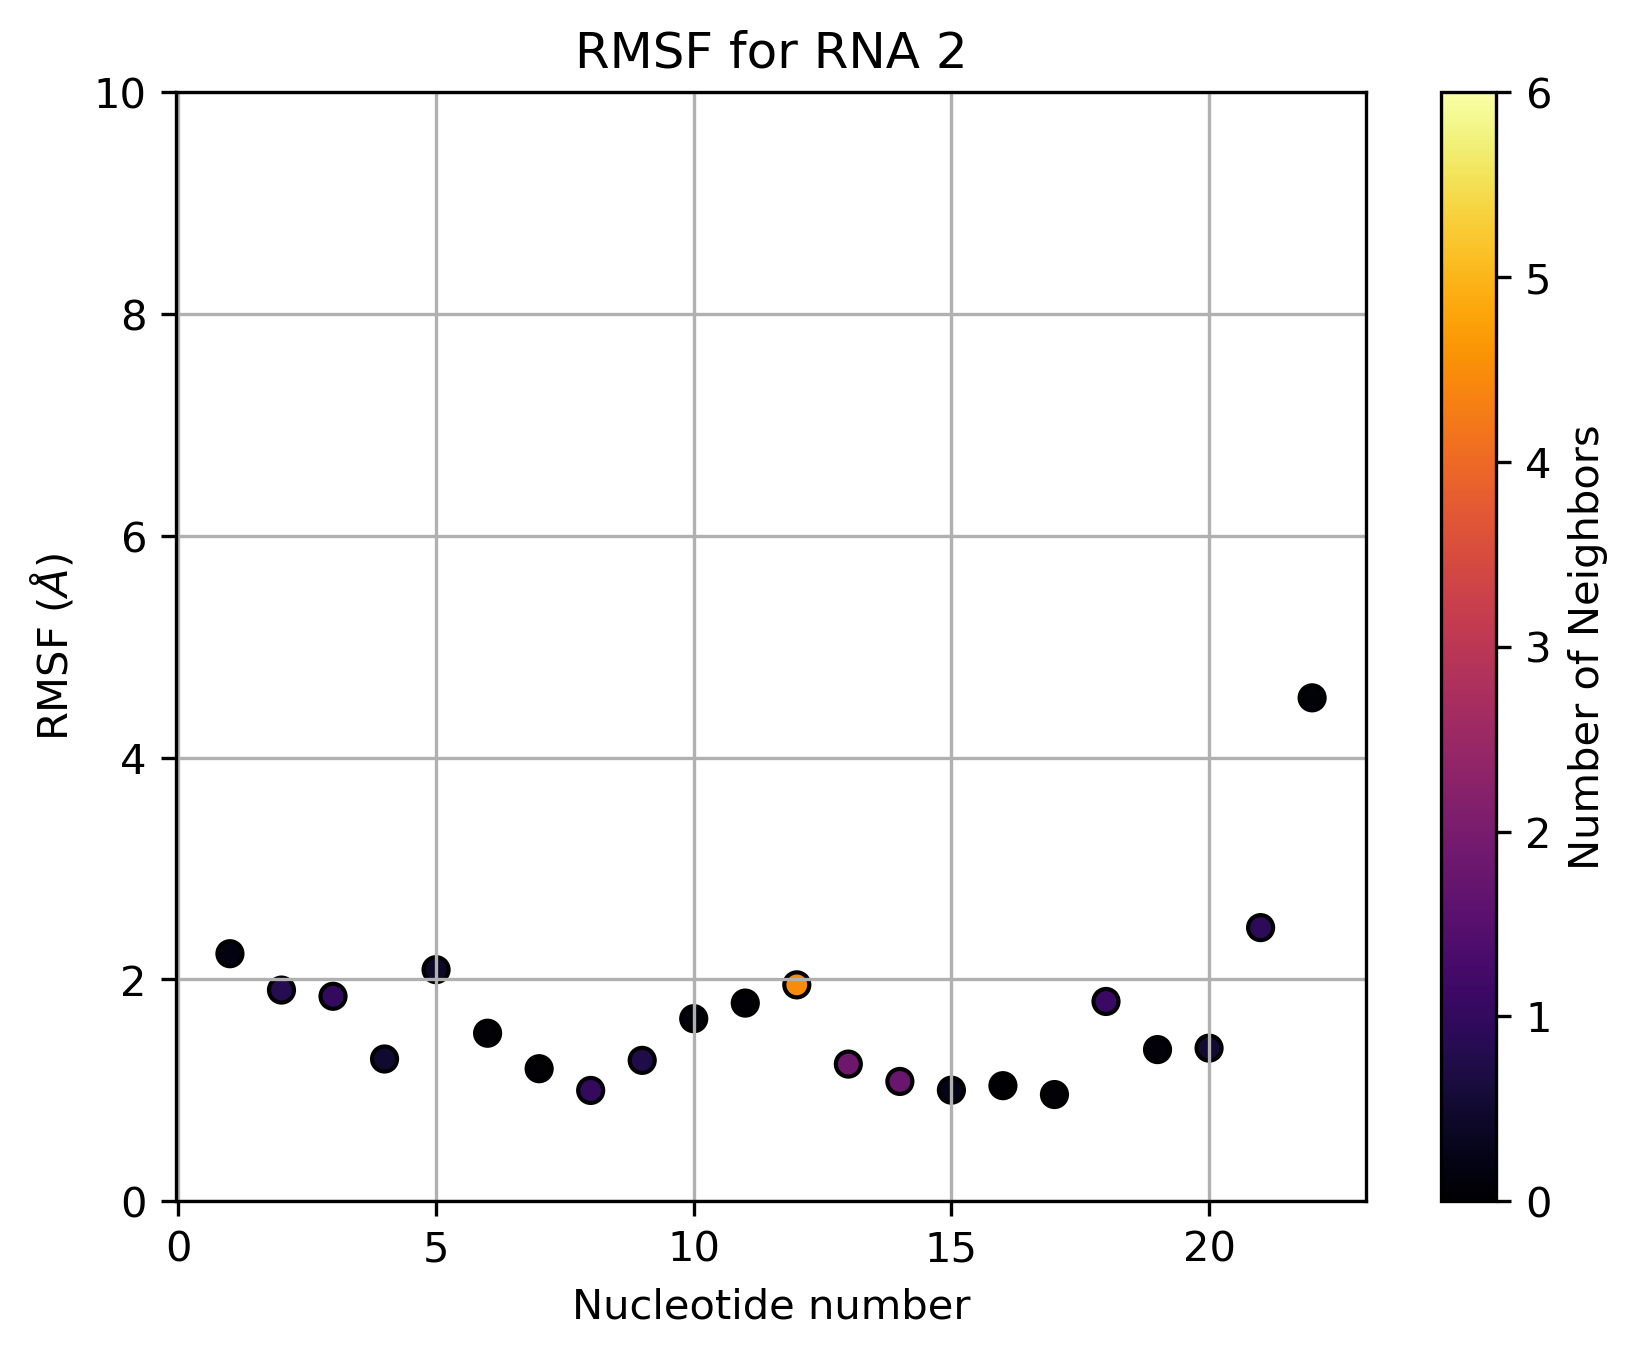

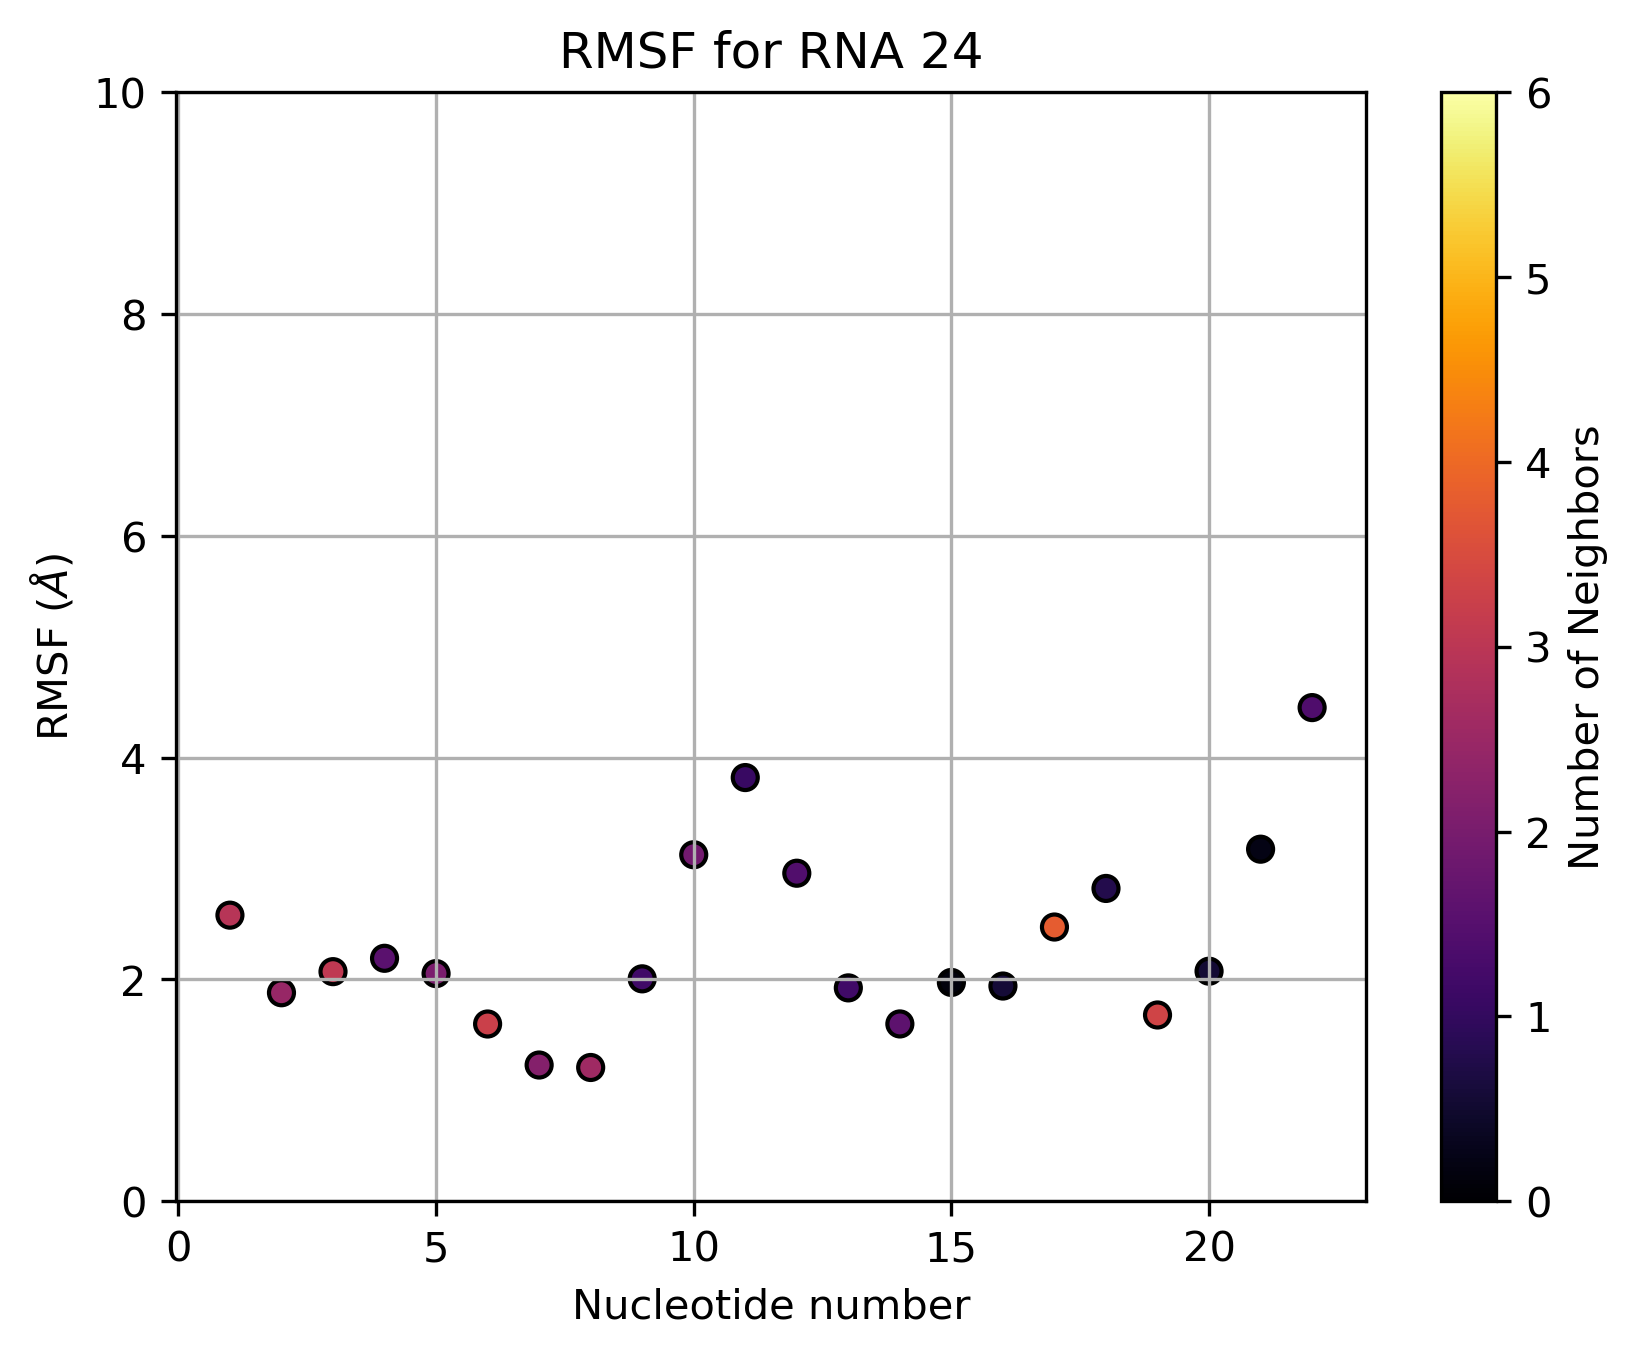

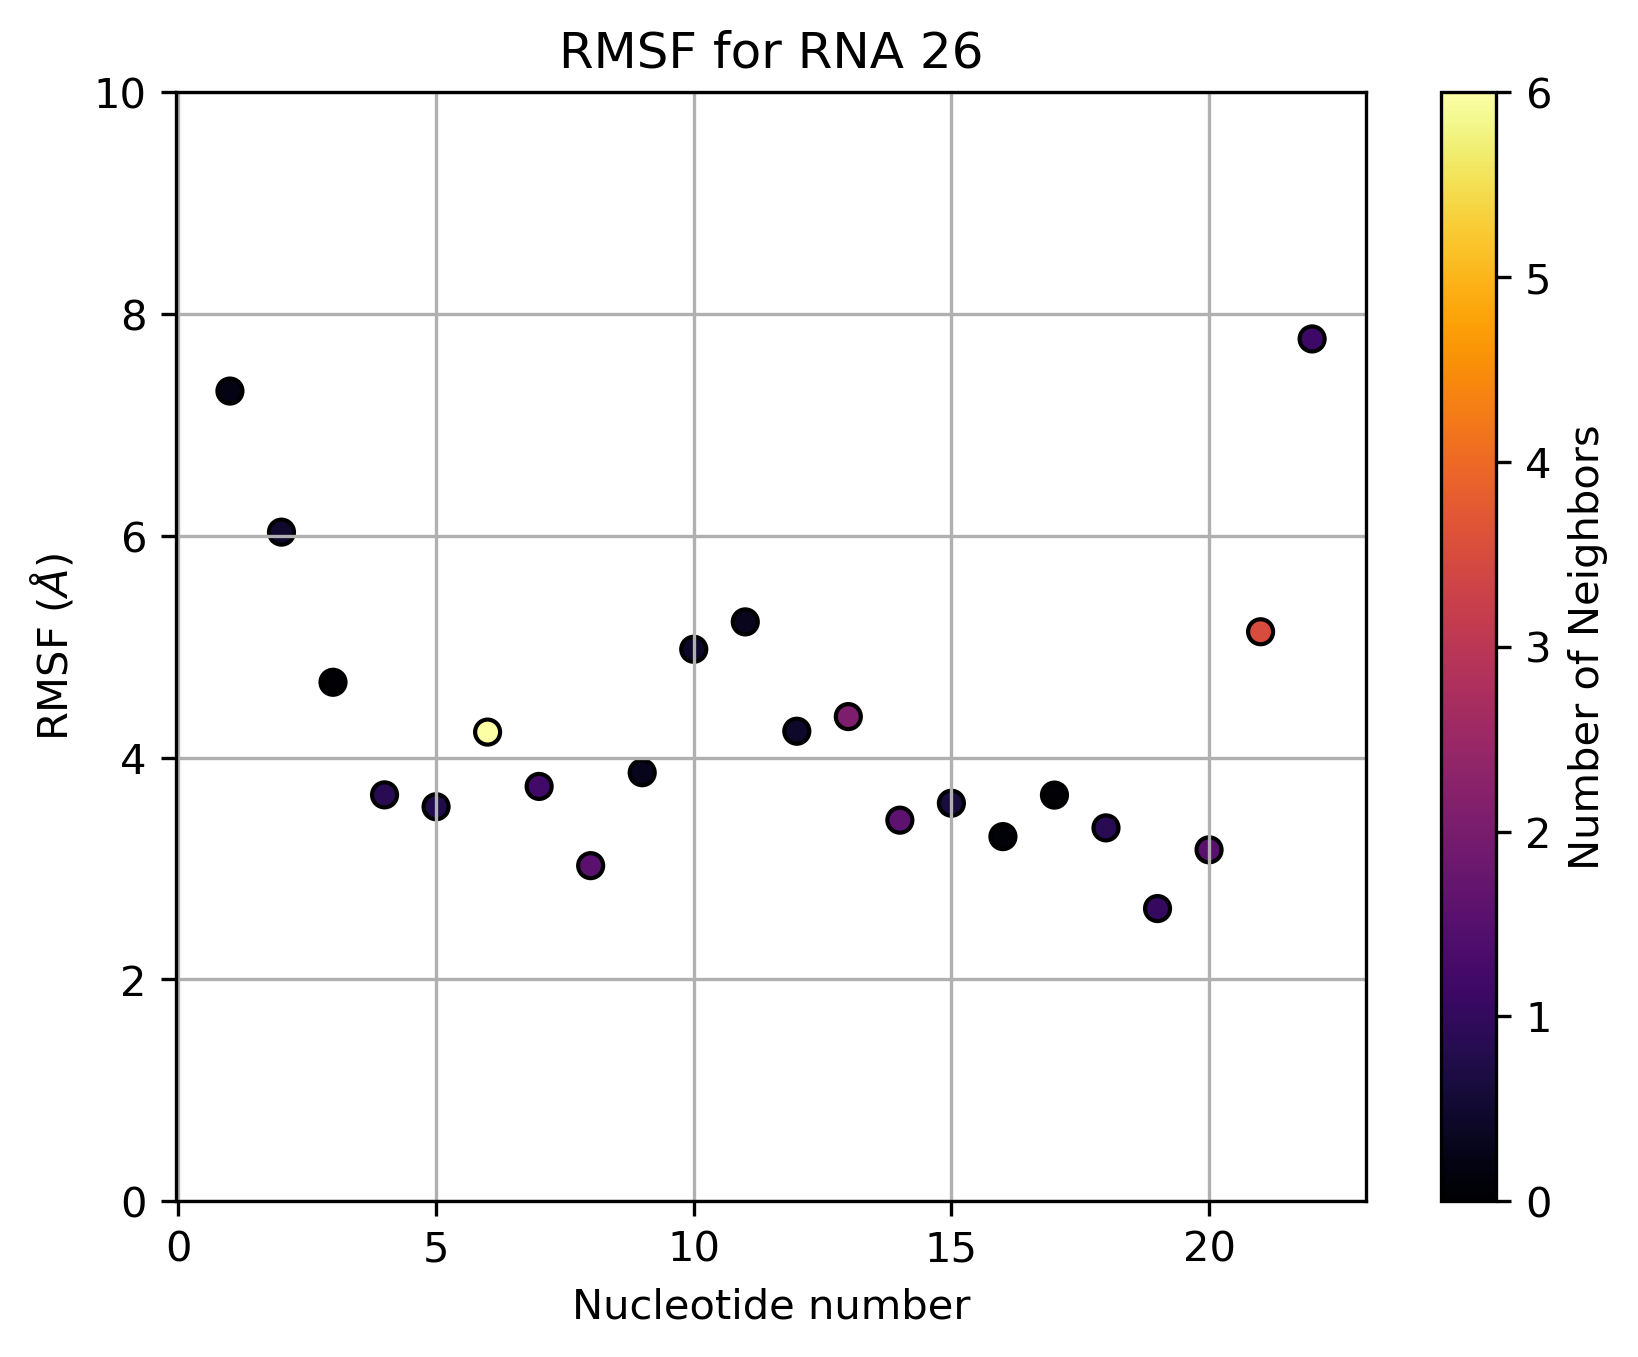

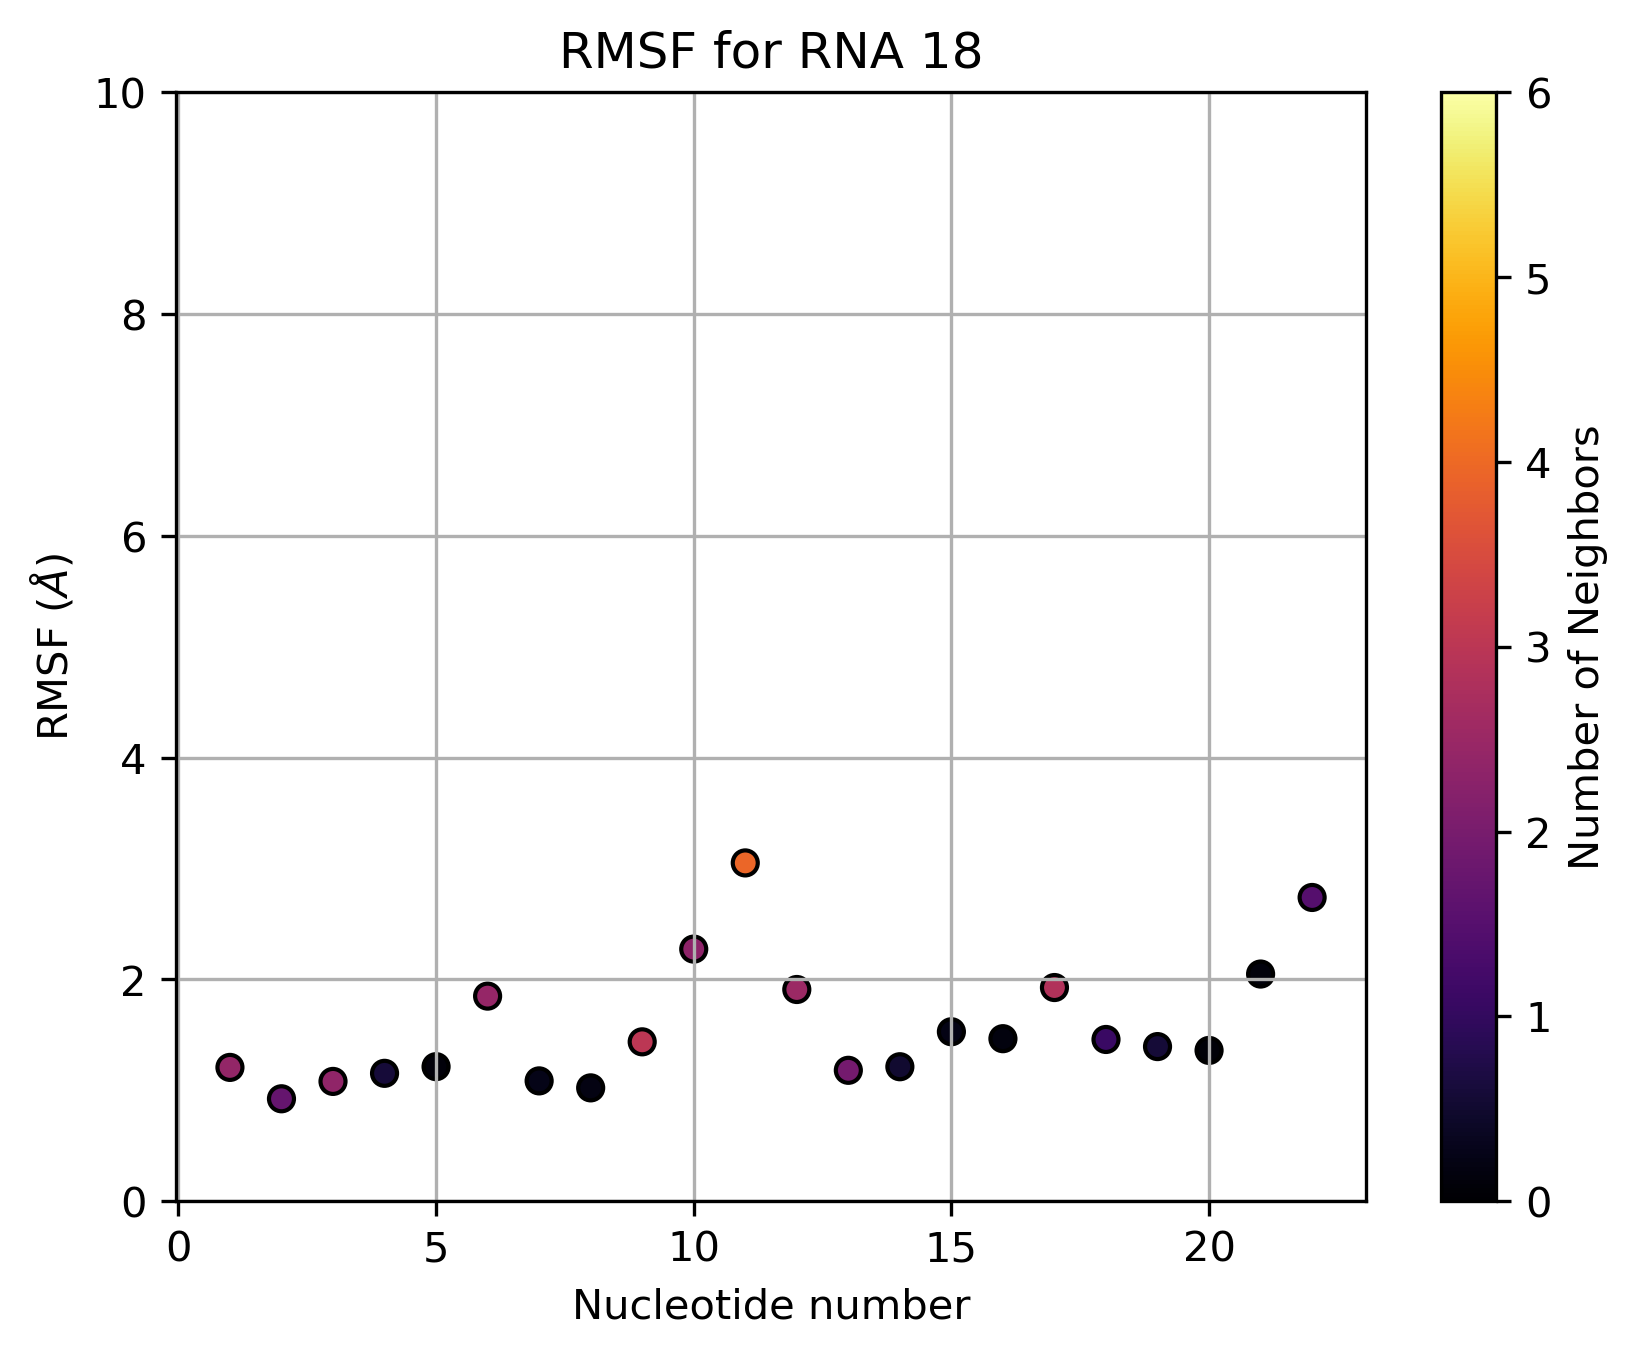

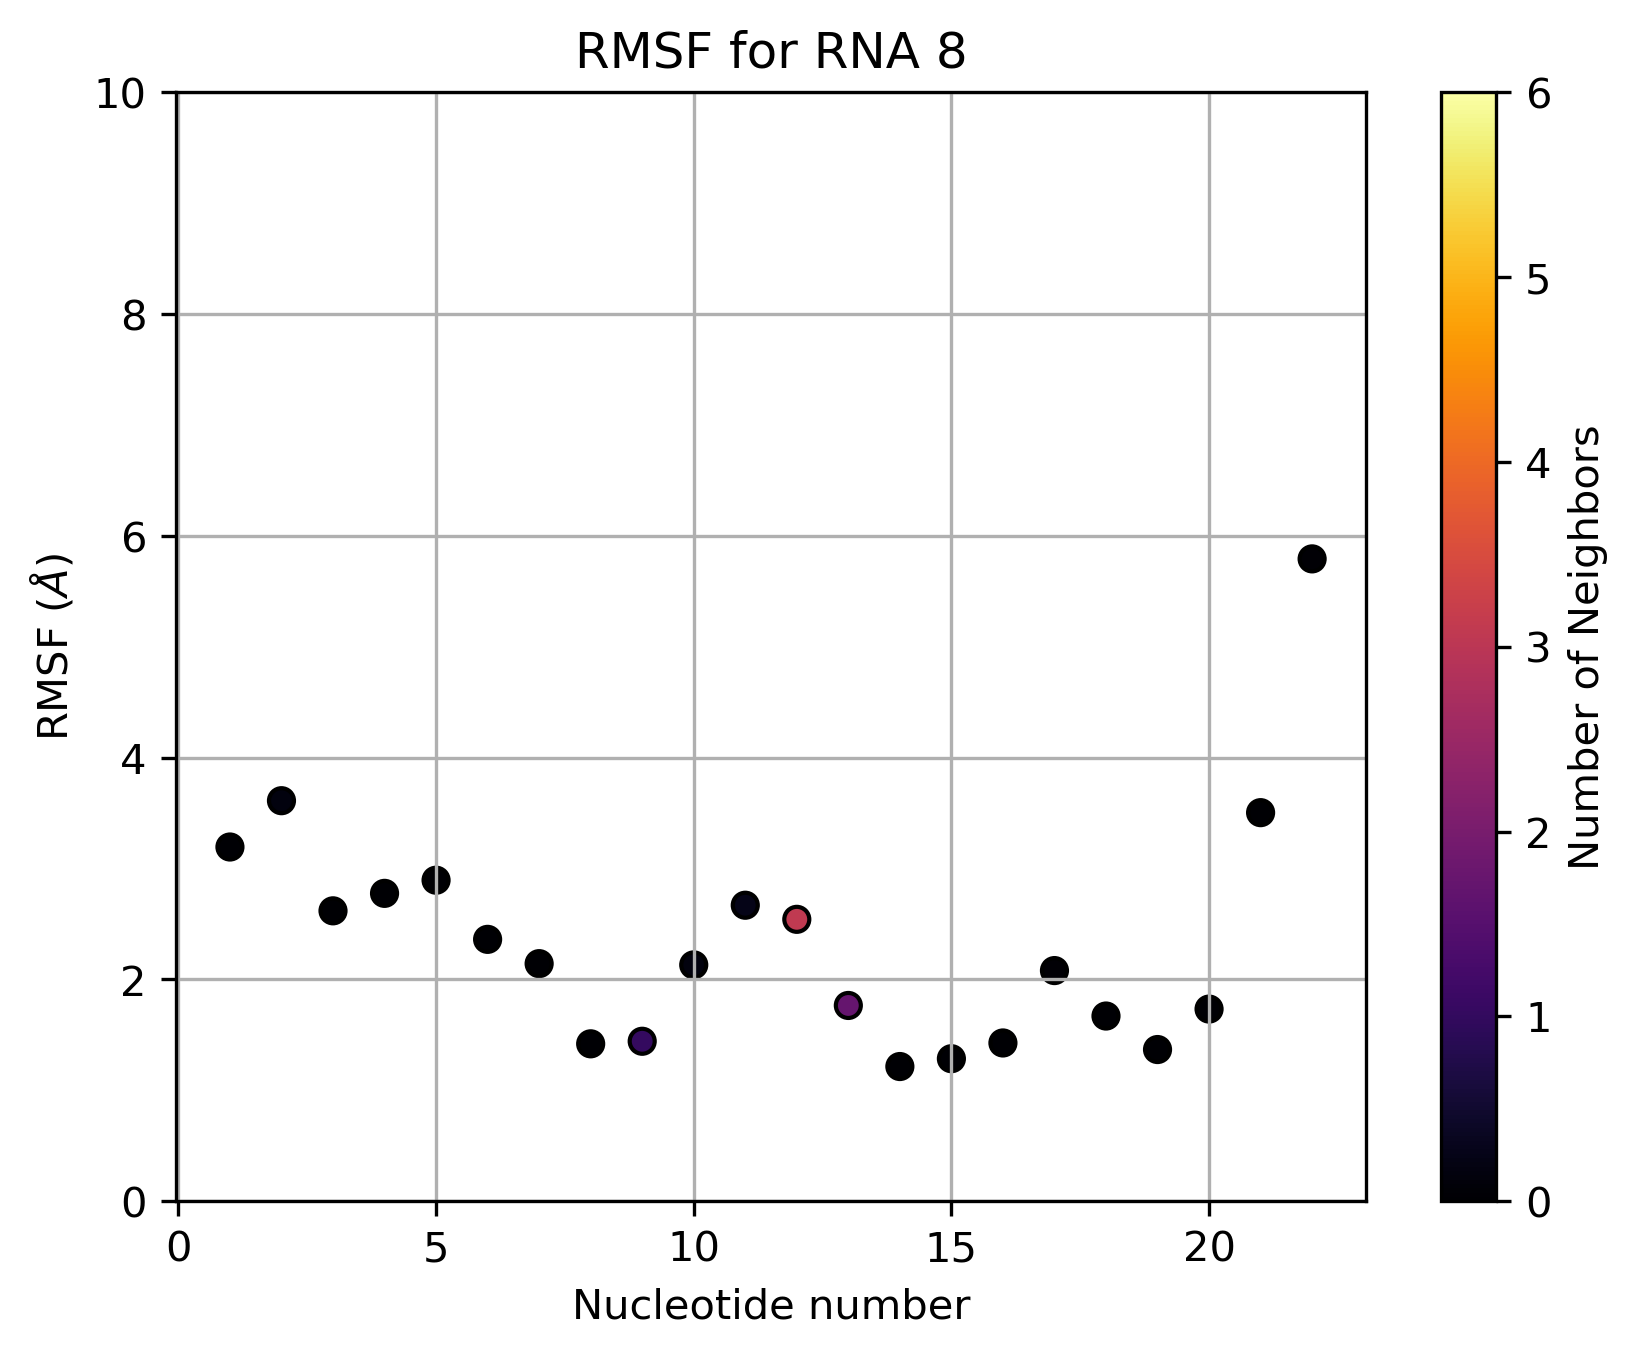

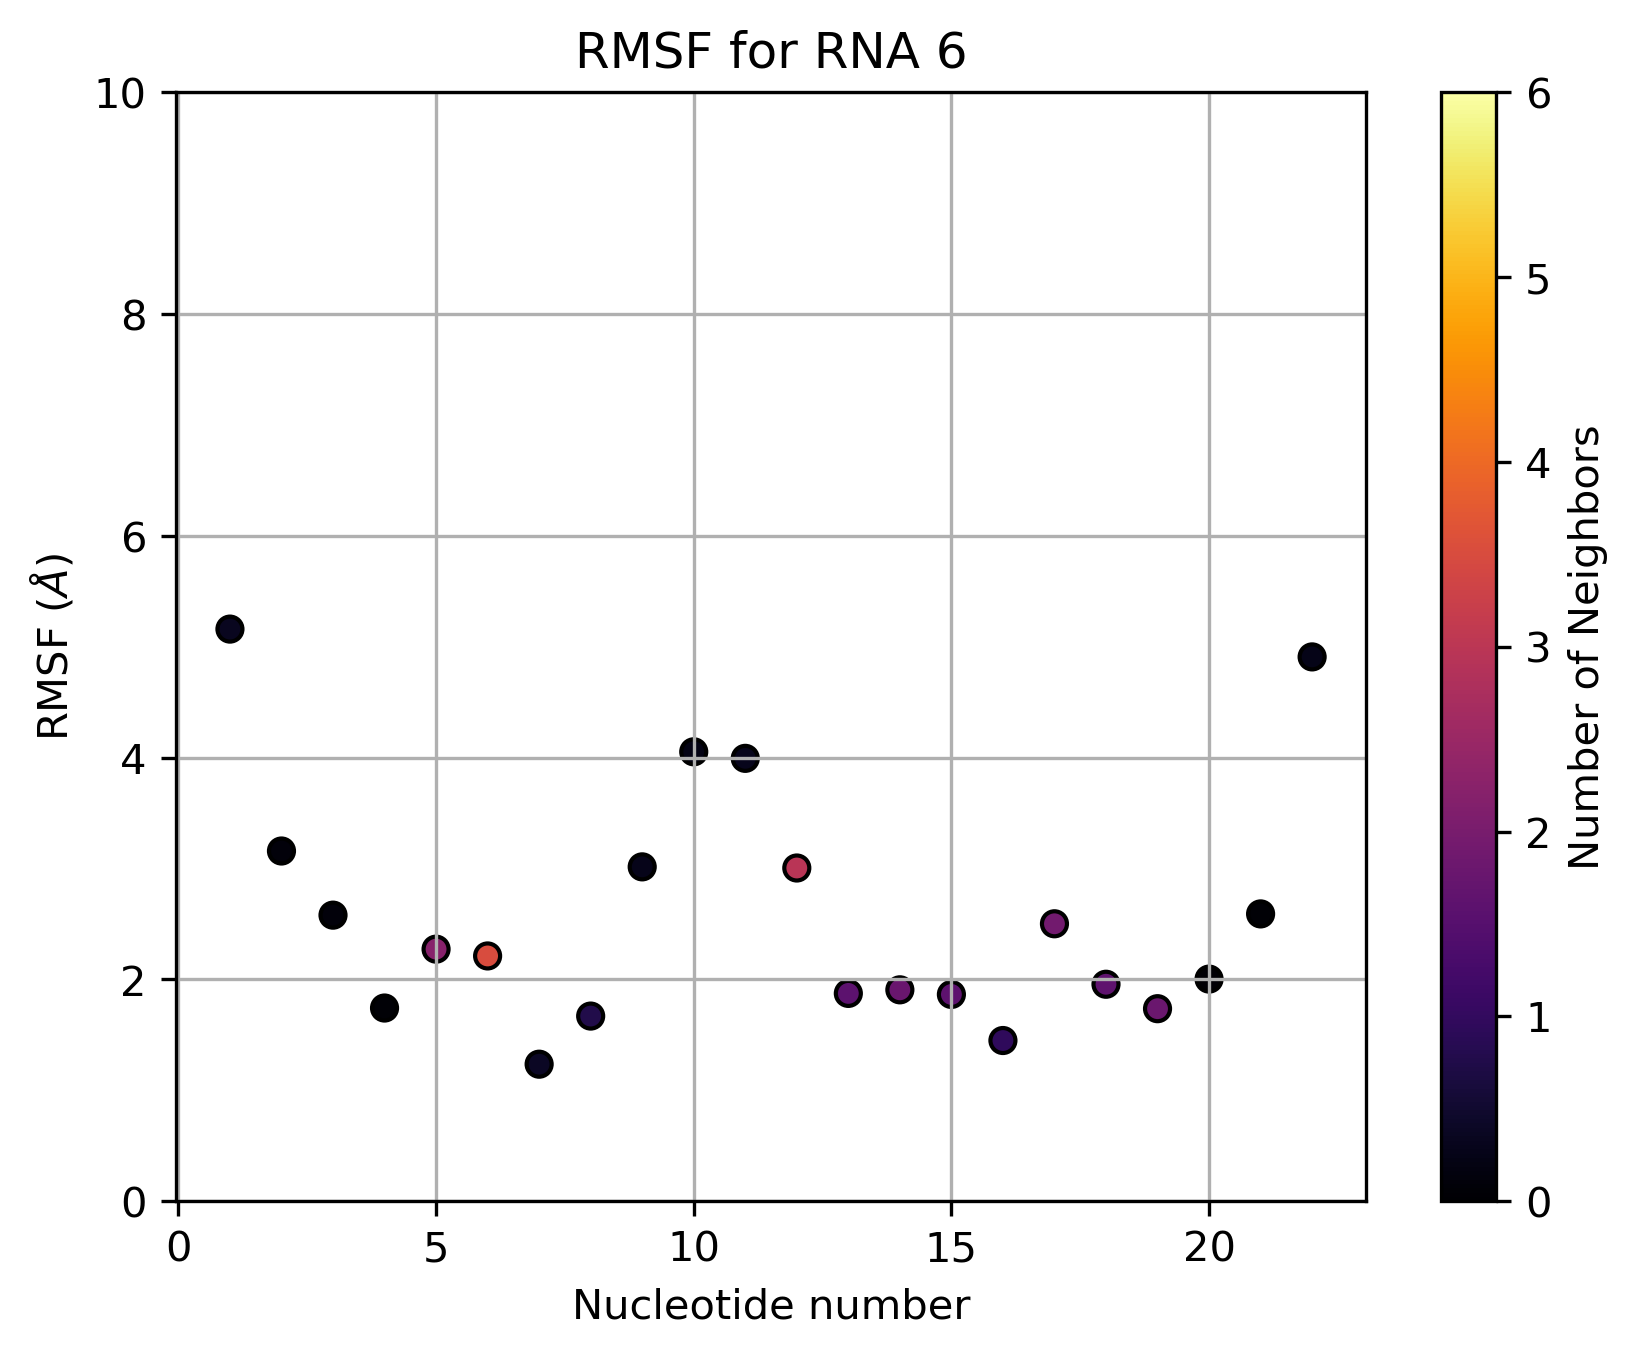

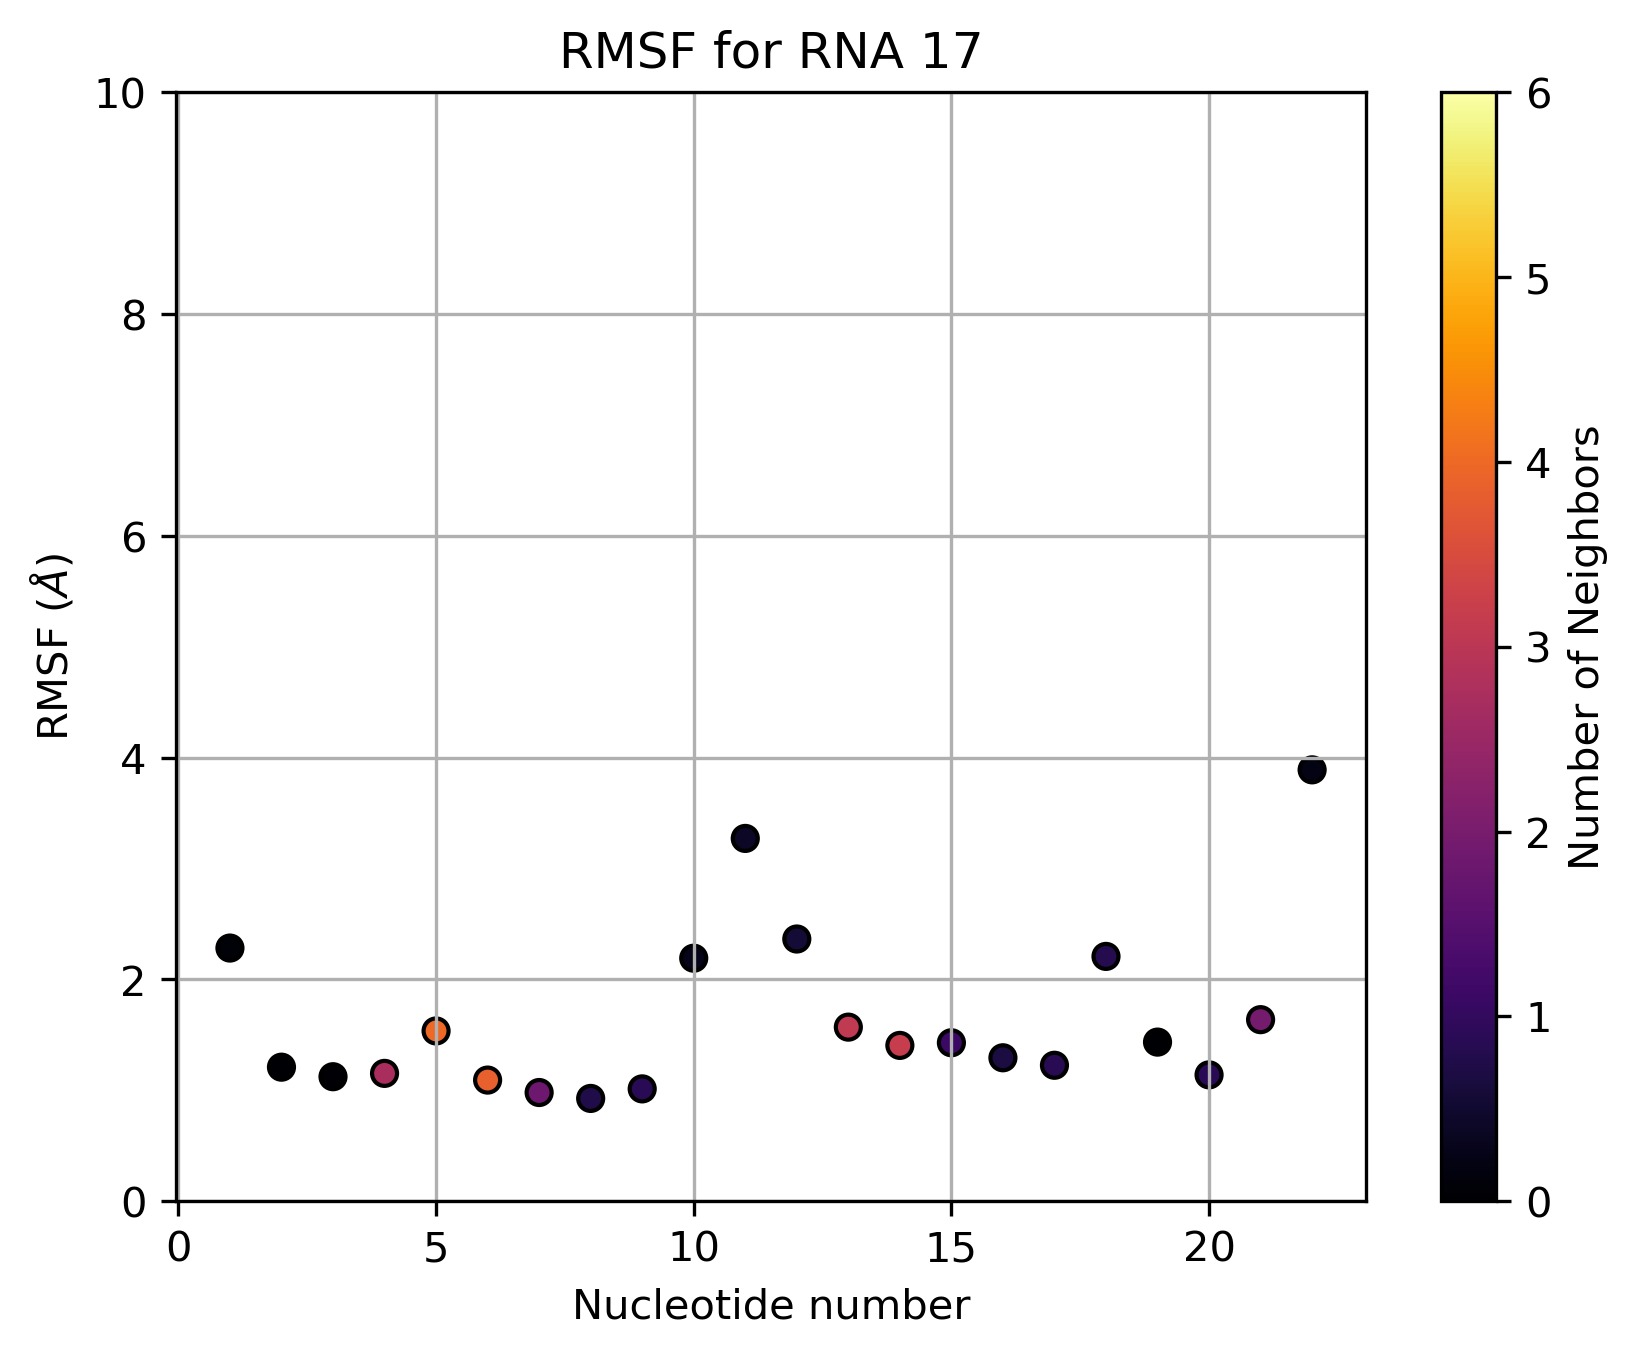

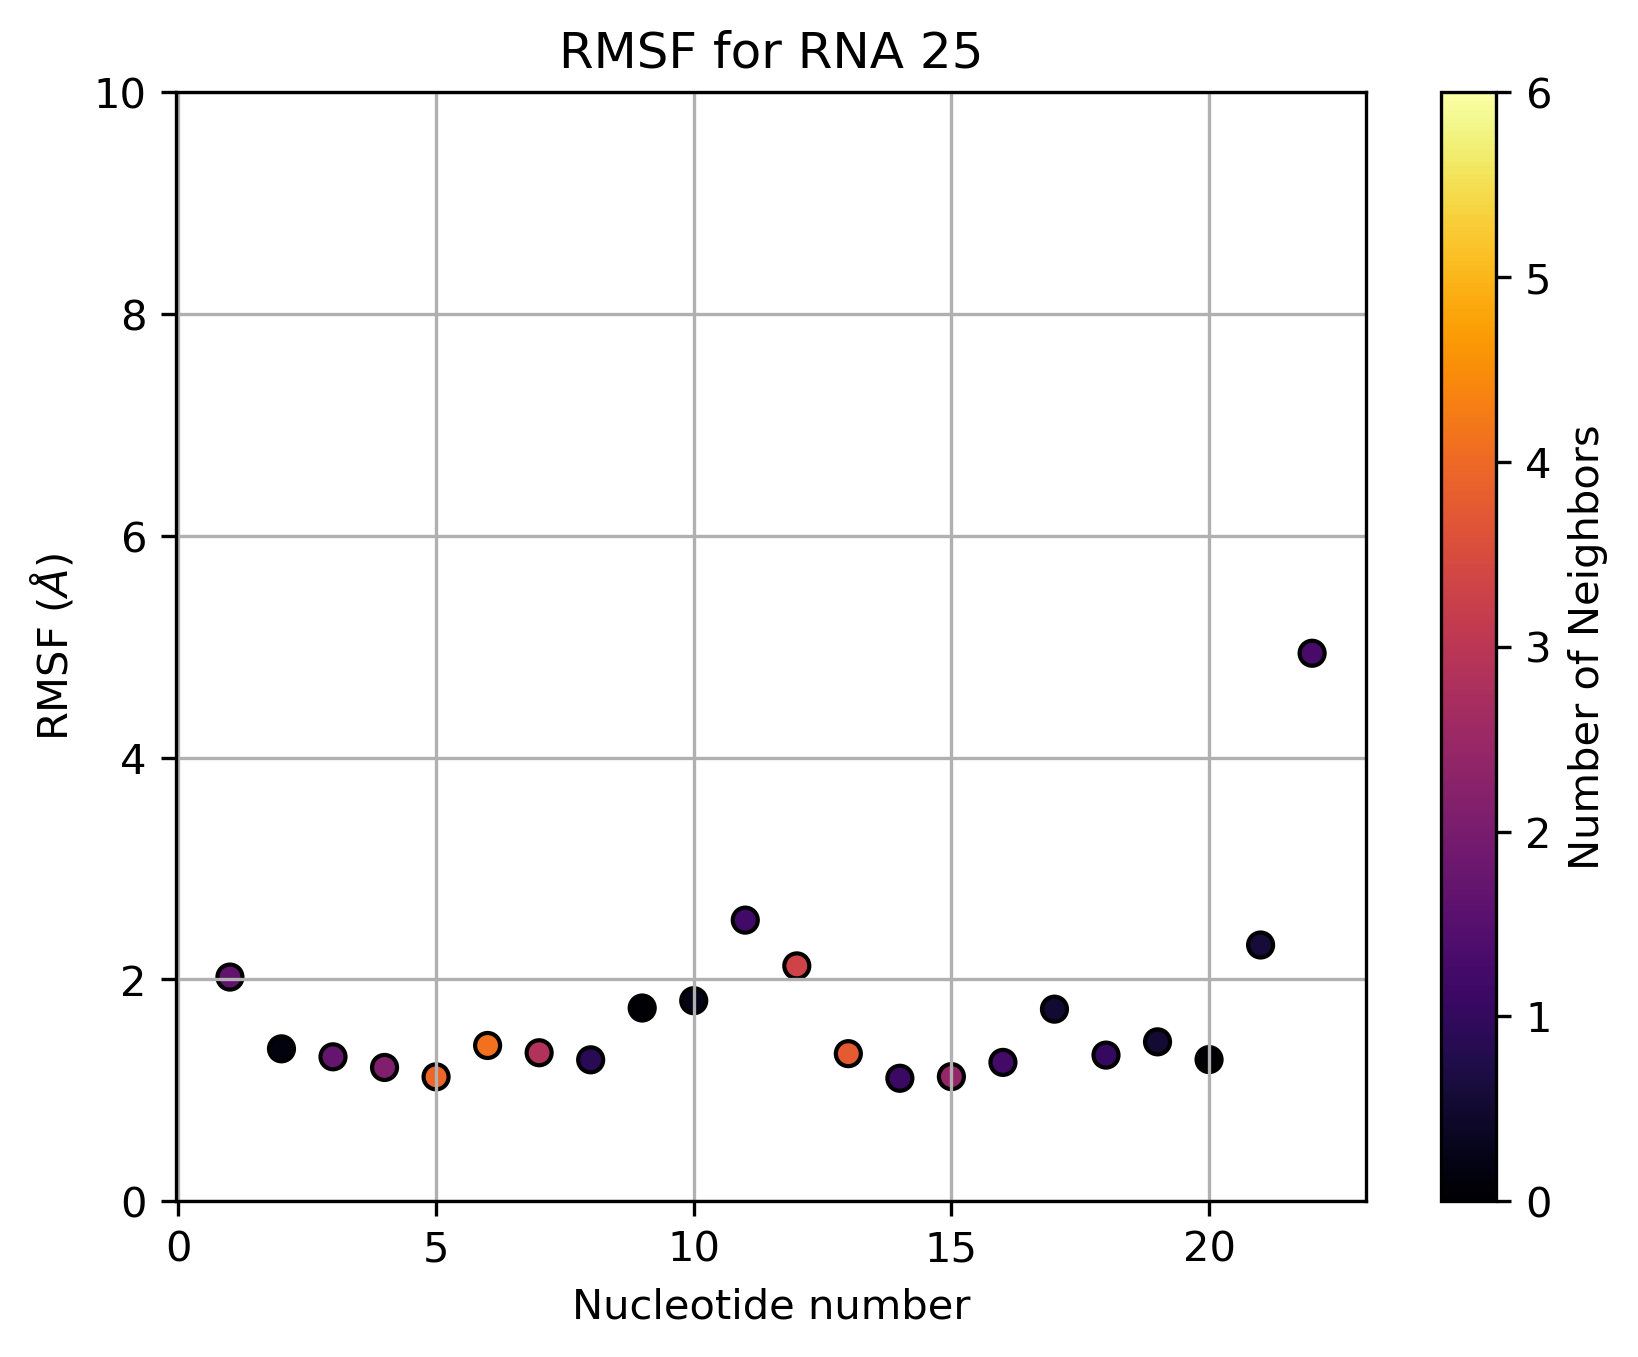

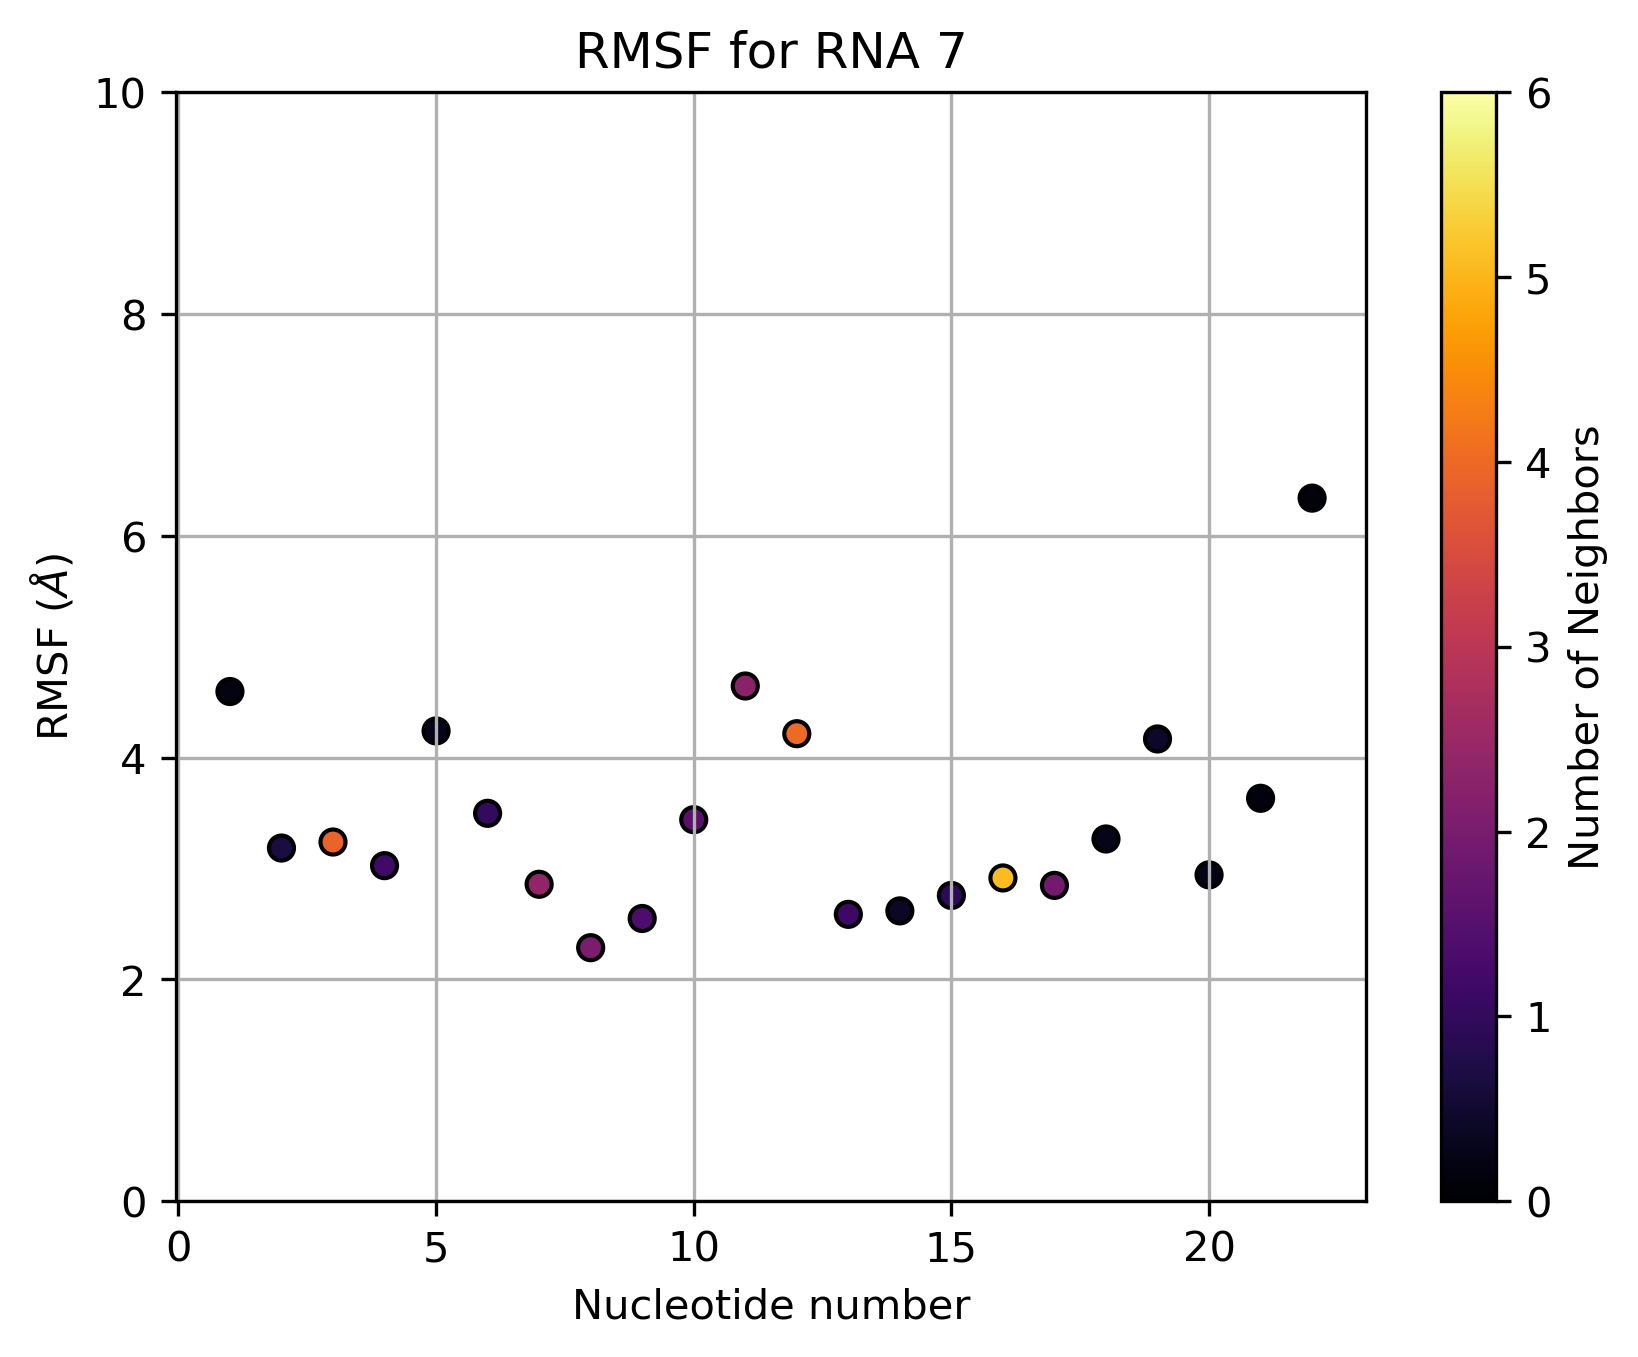

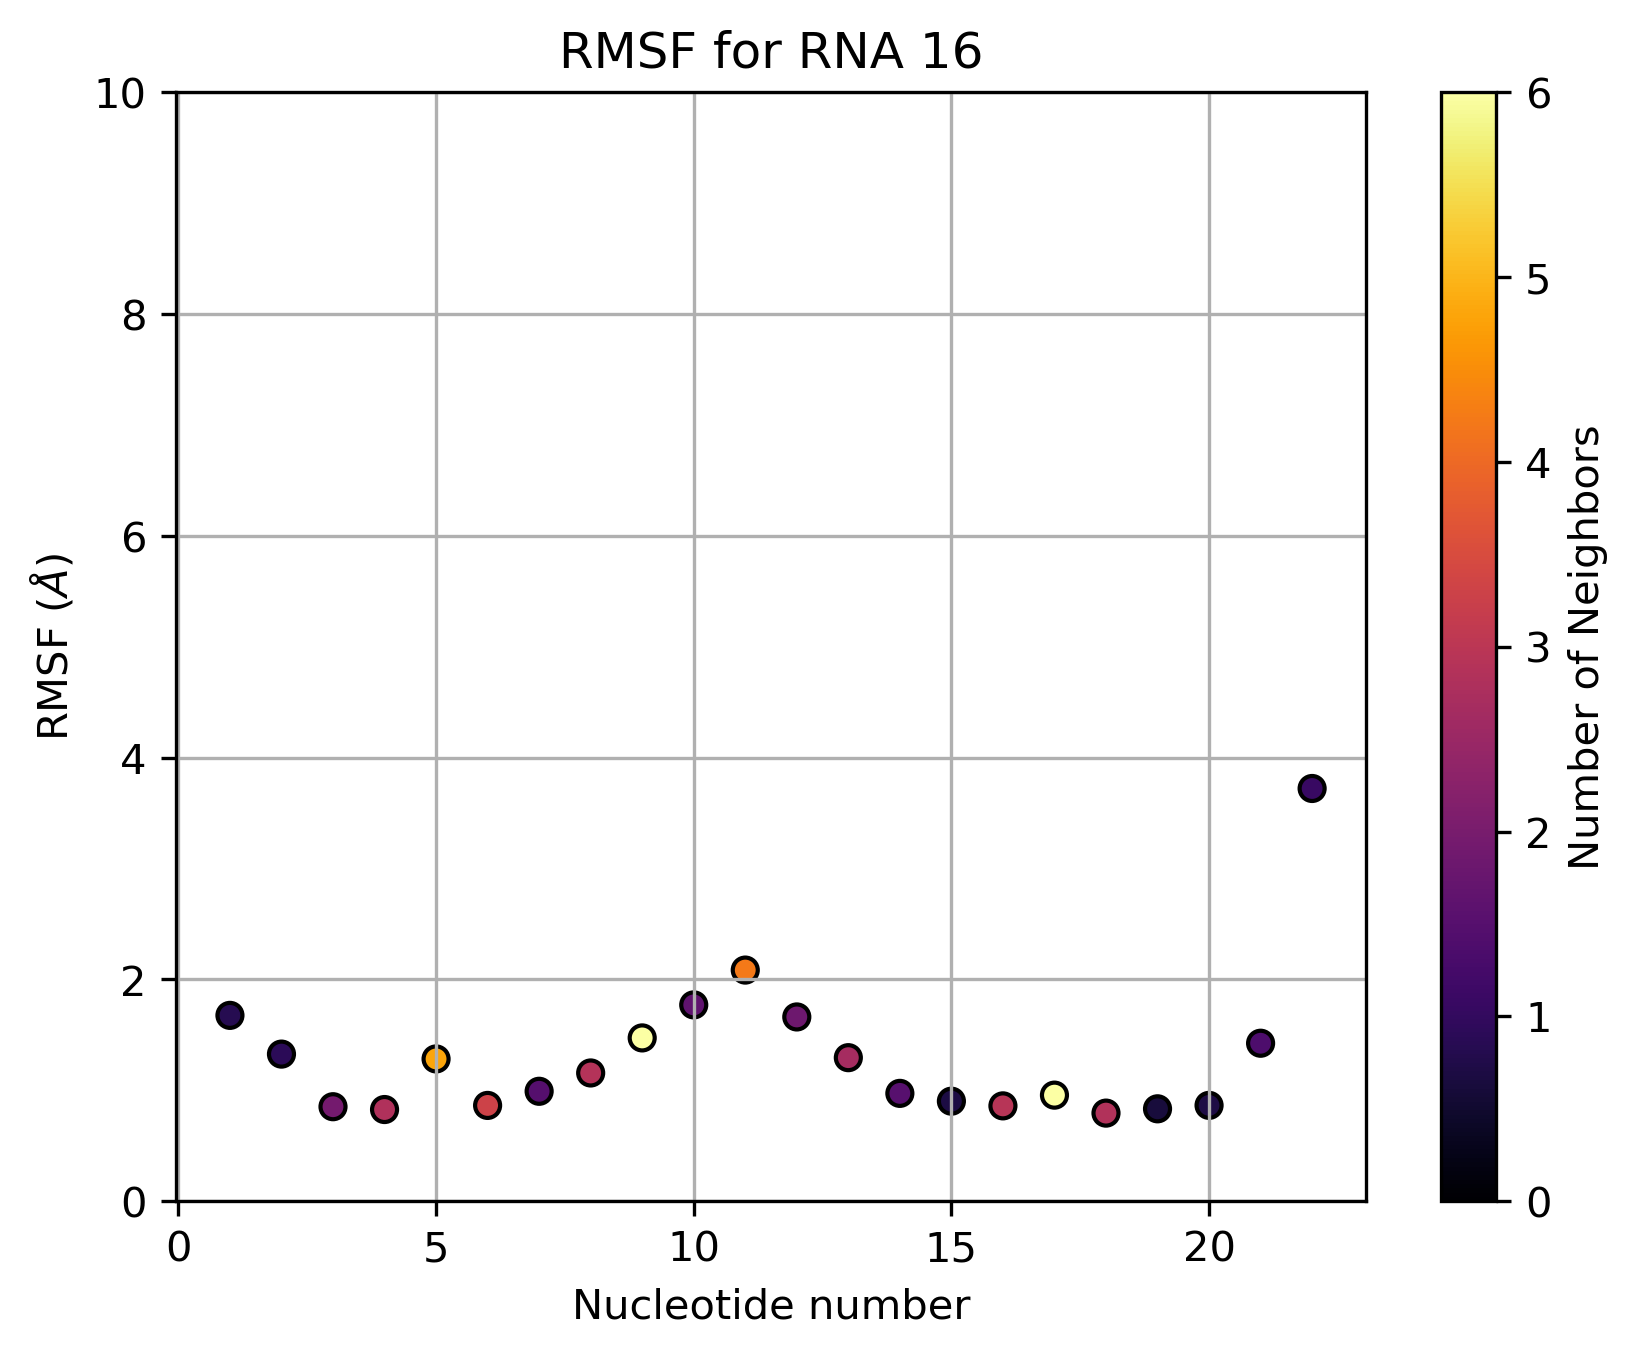

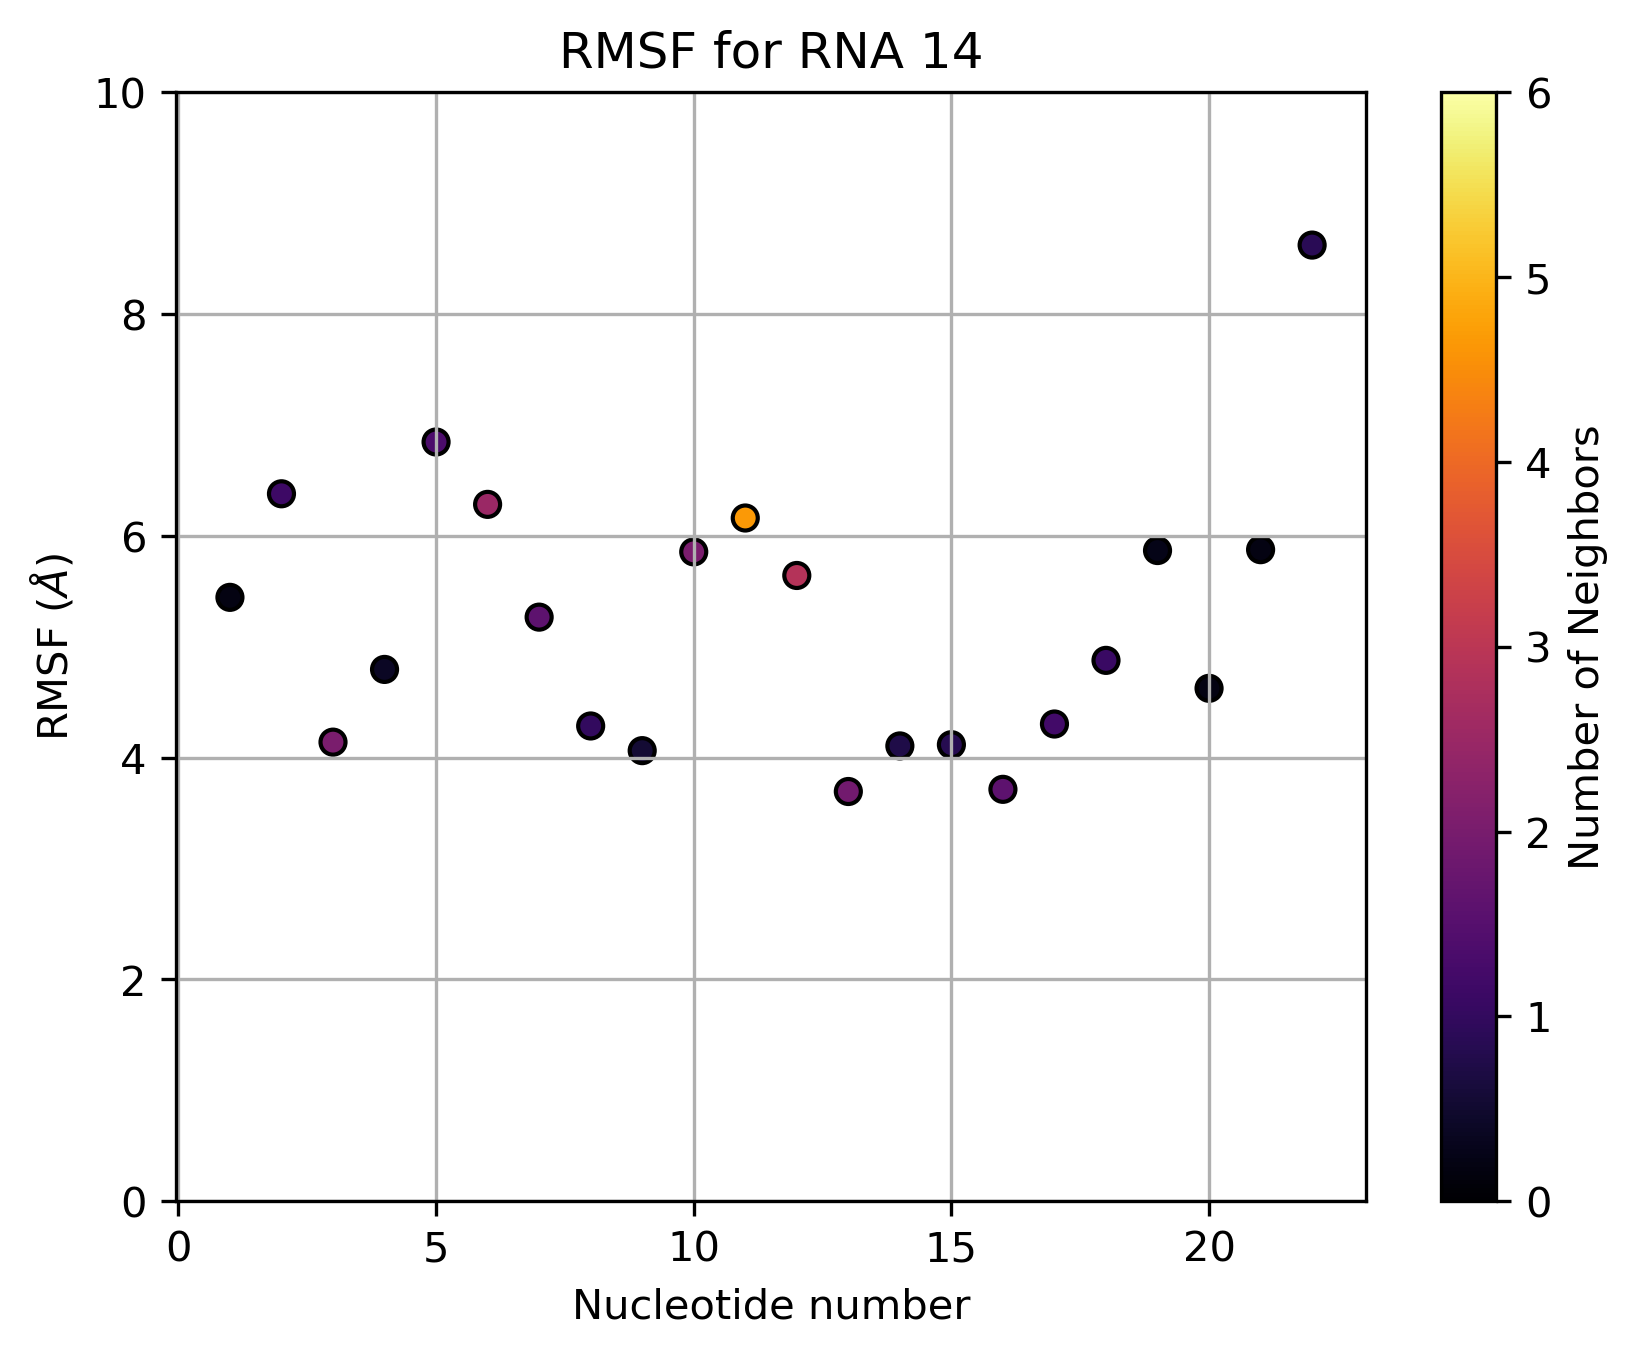

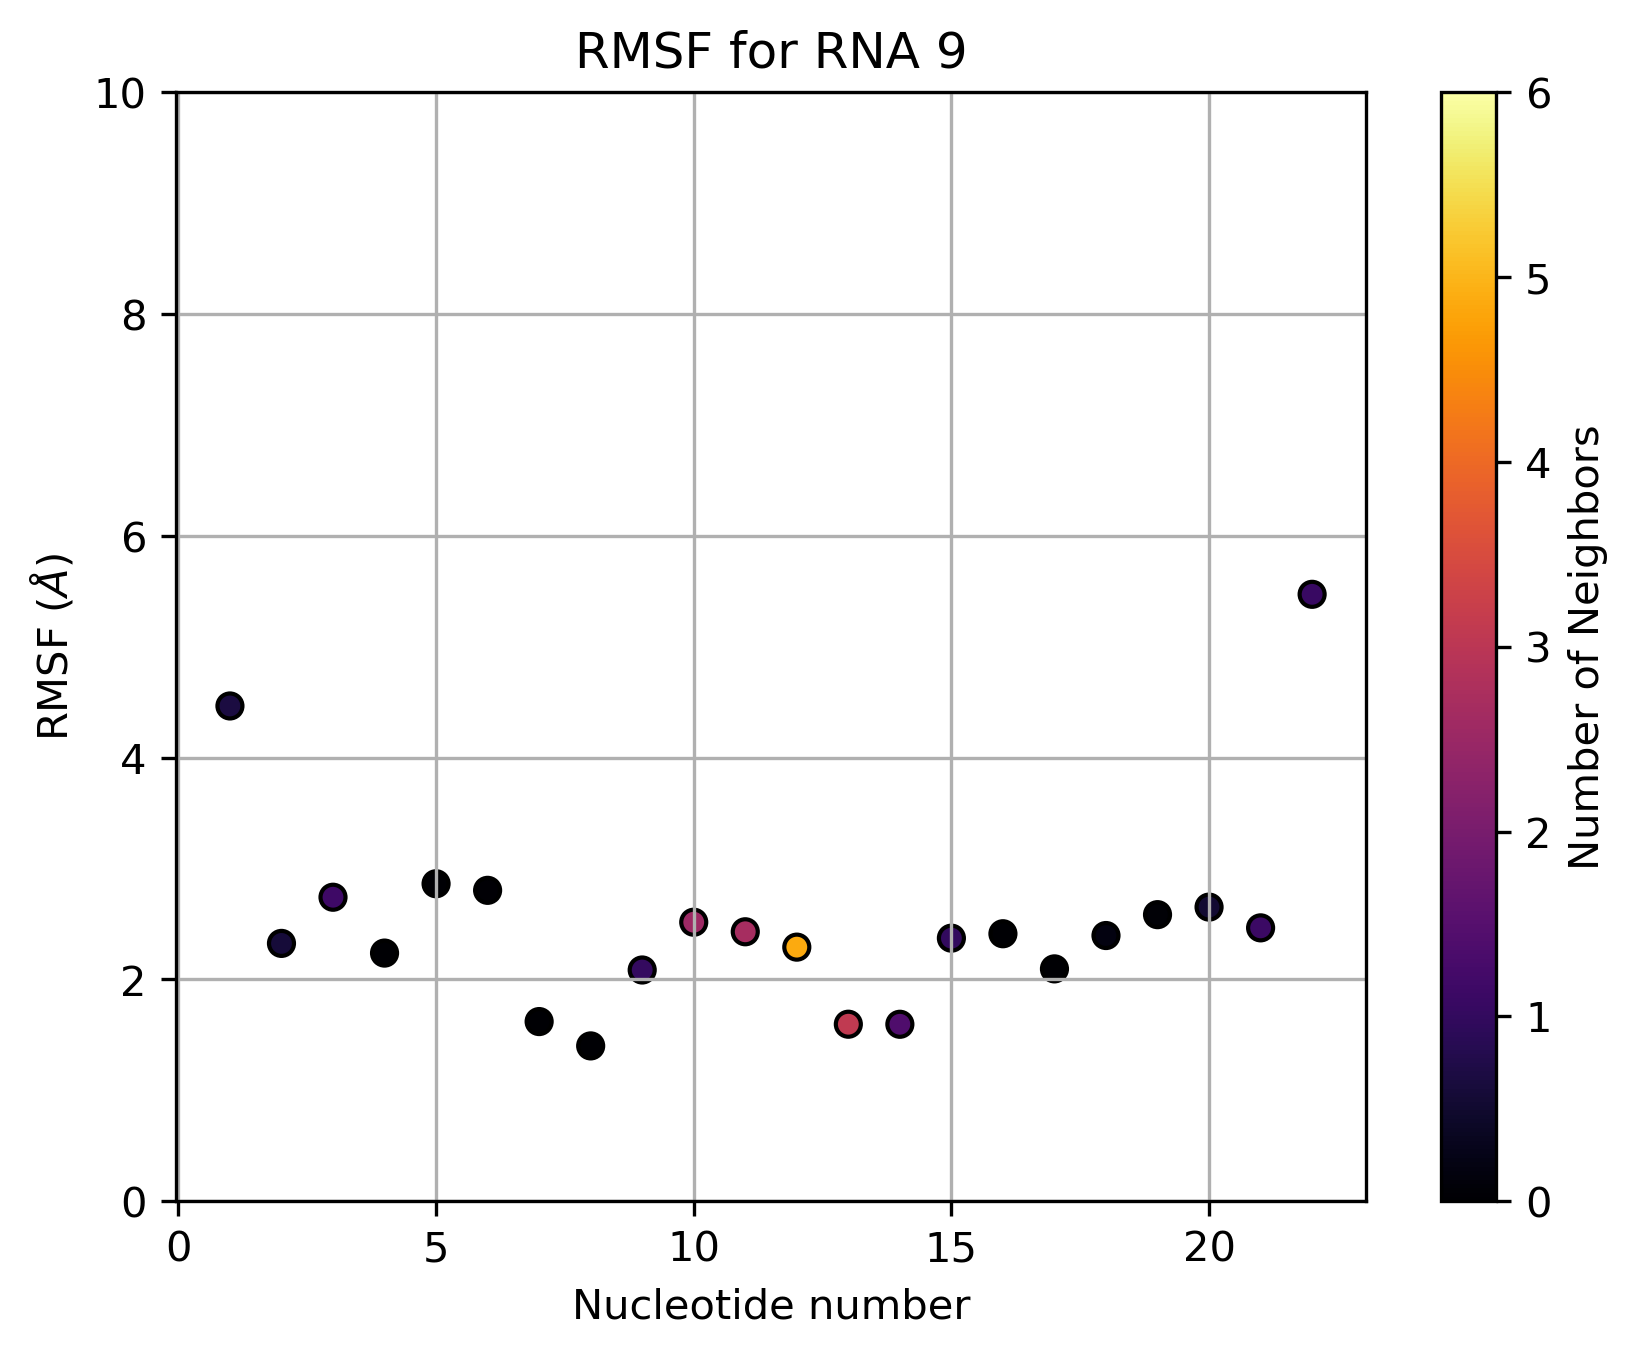

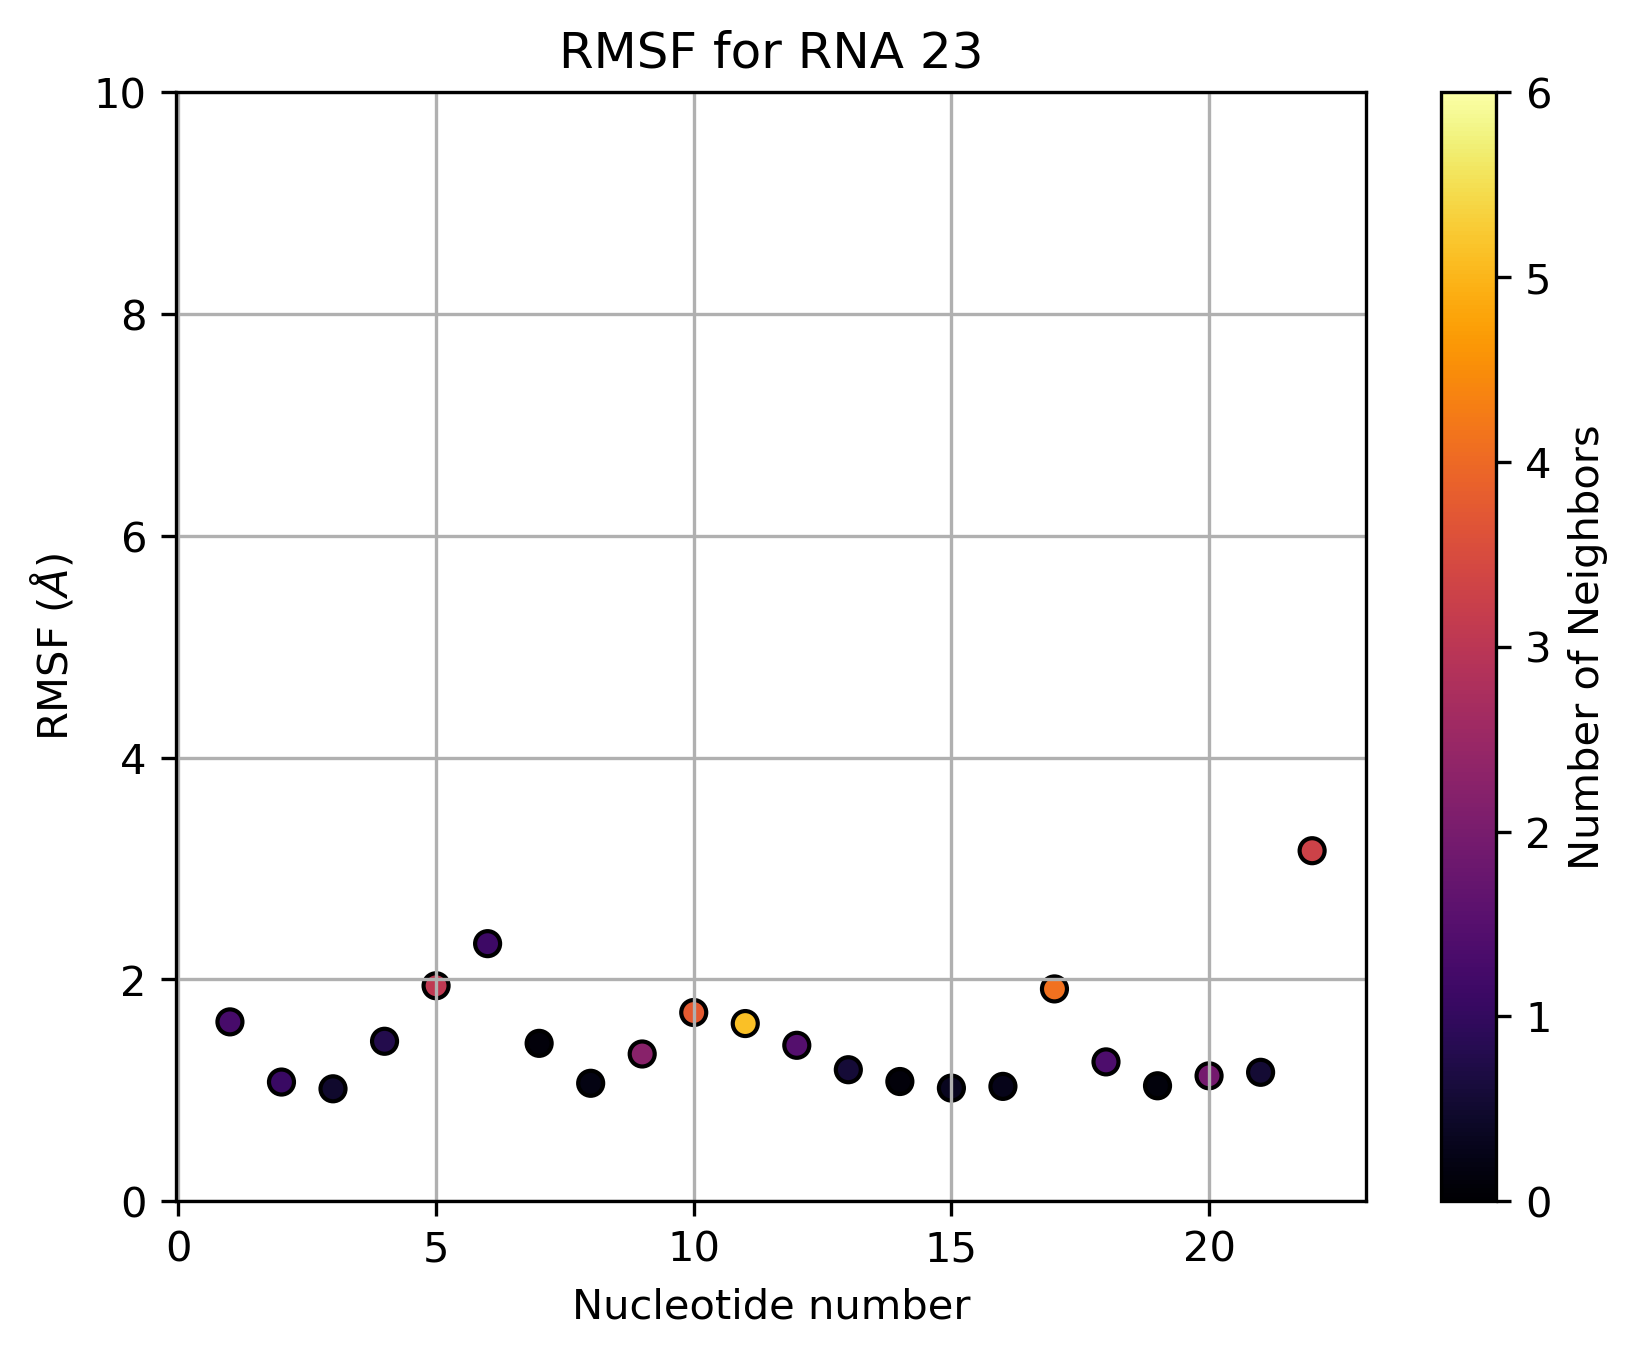

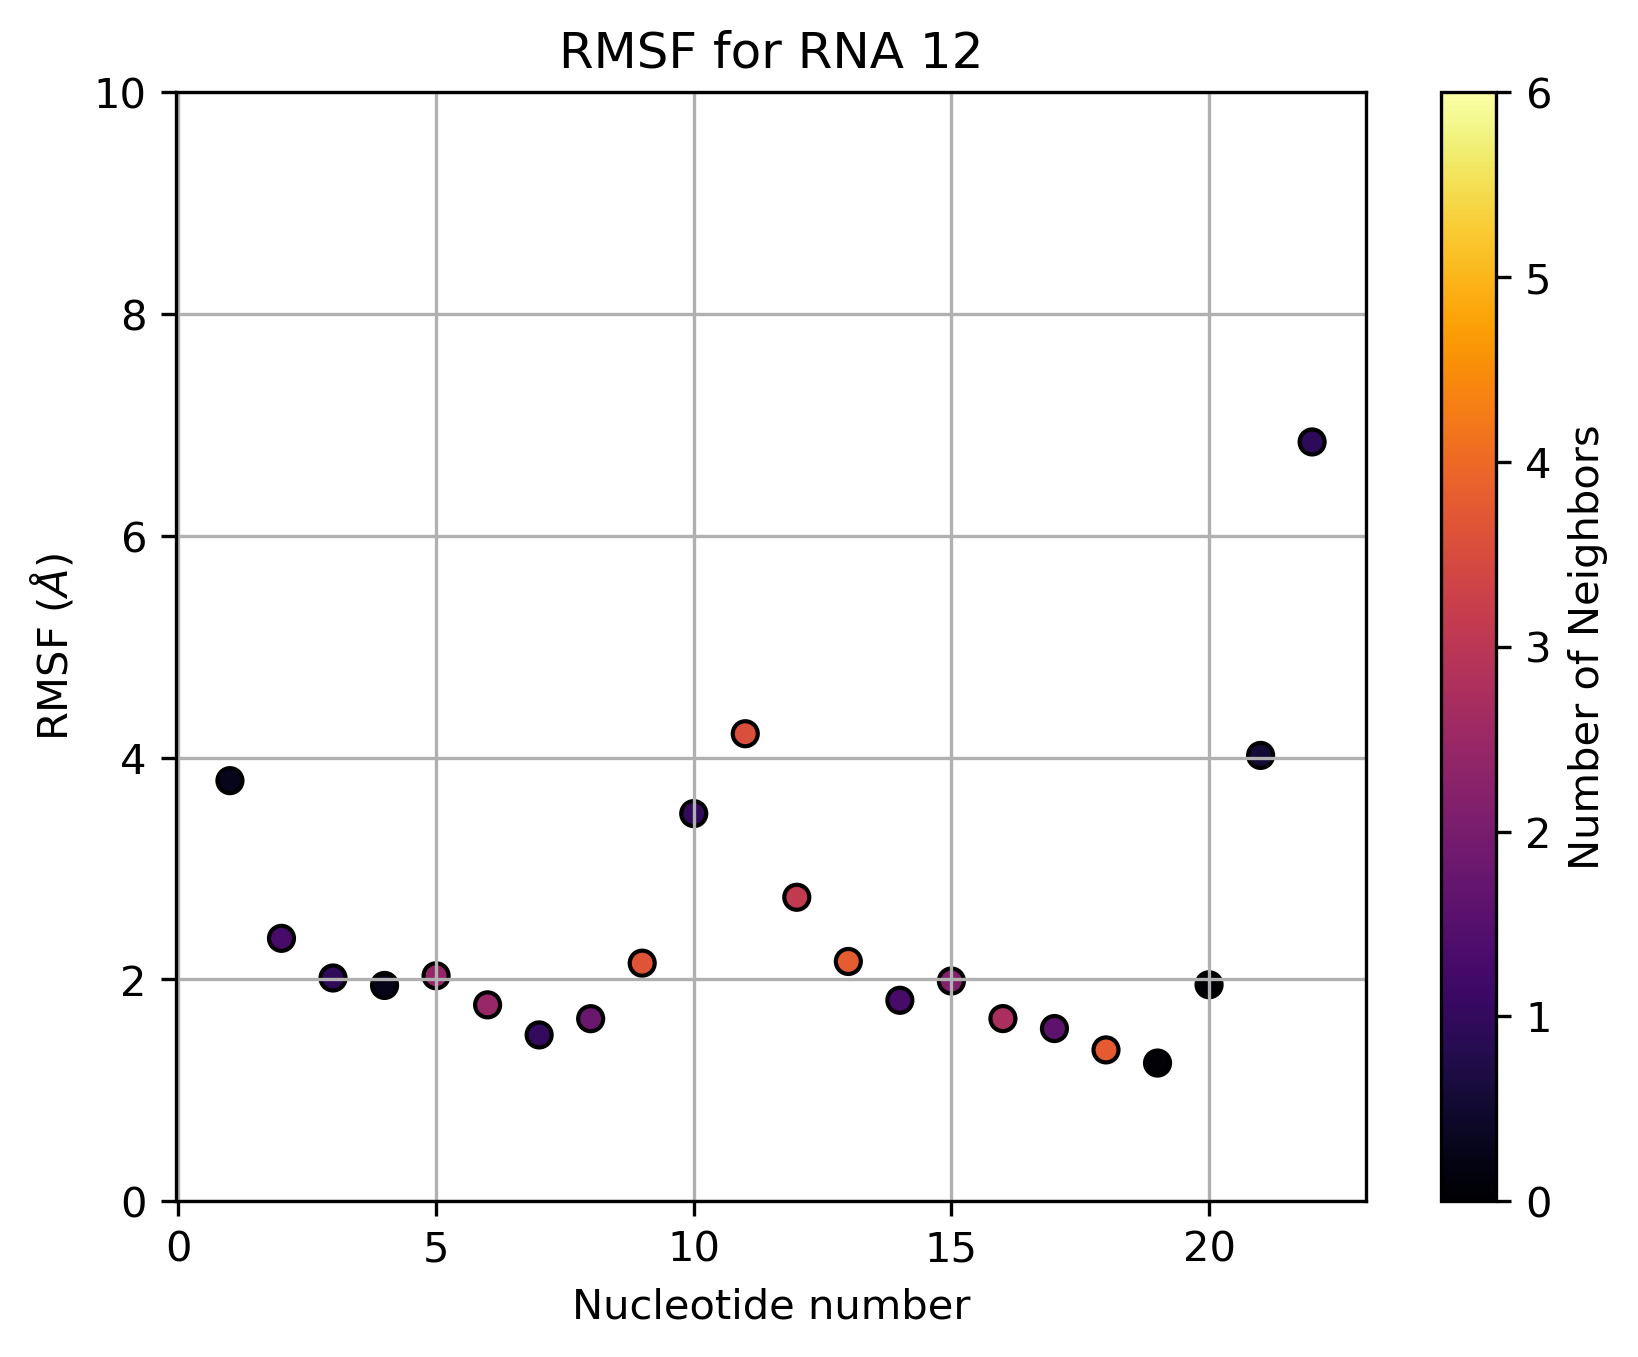

In [6]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import matplotlib.pyplot as plt
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor

i = 10
# def rmsf_for_rna(i):
#     extract_rna(i)
#     # Load trajectory
#     gro_file = f"vars/cleaned_rna{i}.gro"
#     xtc_file = f"vars/cleaned_rna{i}.xtc"
#     u = mda.Universe(gro_file, xtc_file)
    
#     # Define selection for RNA backbone
#     backbone_sel = f"(name P O5' C5' C4' C3' O3' C1' C2')"
#     # Compute the average structure for the RNA backbone
#     average = align.AverageStructure(u, u, select=backbone_sel, ref_frame=2000).run()
#     ref_u = average.results.universe  # Static reference structure

#     # Align trajectory to the reference structure (only RNA backbone)
#     aligner = align.AlignTraj(u, ref_u, select=backbone_sel, in_memory=True).run()

#     # Compute RMSF for the RNA backbone
#     c_alphas = u.select_atoms(backbone_sel)

#     R = rms.RMSF(c_alphas, compound='residues').run()
#      # Assuming rna_protein_neighbors[i] is an array with neighbor counts for each residue:
#     neighbors = rna_protein_neighbors[i]
#     # Optionally, ensure that neighbors is a NumPy array:
#     import numpy as np
#     neighbors = np.asarray(neighbors)
#     sc = plt.scatter(c_alphas.resids, R.results.rmsf)
#     #sc = plt.scatter(c_alphas.resids, R.results.rmsf, c=neighbors, cmap='viridis', edgecolor='k')
#     #plt.plot(c_alphas.resids, R.results.rmsf)
#     plt.xlabel('Residue number')
#     plt.ylabel('RMSF ($\AA$)')
#     plt.title(f"RMSF for RNA {i}")
#     plt.grid(True)
#     plt.legend()
#     plt.show()
    
#     # or something more useful
#     return 1

def rmsf_for_rna(i):
    extract_rna(i)
    # Load trajectory
    gro_file = f"vars/cleaned_rna{i}.gro"
    xtc_file = f"vars/cleaned_rna{i}.xtc"
    u = mda.Universe(gro_file, xtc_file)
    
    # Define selection for RNA backbone
    backbone_sel = "(name P O5' C5' C4' C3' O3' C1' C2')"
    # Compute the average structure for the RNA backbone
    average = align.AverageStructure(u, u, select=backbone_sel, ref_frame=2000).run()
    ref_u = average.results.universe  # Static reference structure

    # Align trajectory to the reference structure (only RNA backbone)
    aligner = align.AlignTraj(u, ref_u, select=backbone_sel, in_memory=True).run()

    # Select the atoms and compute RMSF
    atoms = u.select_atoms(backbone_sel)
    R = rms.RMSF(atoms).run()
    
    # Now, we have R.results.rmsf for each atom.
    # Group these by residue:
    resids = atoms.resids  # this gives an array of residue numbers for each atom
    unique_resids, inv = np.unique(resids, return_inverse=True)
    
    # For each residue, average the RMSF of its atoms.
    averaged_rmsf = np.zeros(len(unique_resids))
    for idx in range(len(unique_resids)):
        averaged_rmsf[idx] = np.mean(R.results.rmsf[inv == idx])
    
    # Now averaged_rmsf is one value per residue.
    # Assuming rna_protein_neighbors[i] is an array of neighbor counts with length equal to number of residues:
    neighbors = np.asarray(rna_protein_neighbors[i])
    
    # Plot using scatter, coloring by the neighbor count.
    import matplotlib.pyplot as plt
    plt.figure(dpi=300)
    sc = plt.scatter(unique_resids, averaged_rmsf, c=neighbors, 
                     cmap='inferno', #'viridis', 'plasma'
                     edgecolor='k', vmin=0, vmax=6)
    plt.xlabel('Nucleotide number')
    plt.ylabel('RMSF ($\AA$)')
    plt.title(f"RMSF for RNA {i}")
    plt.ylim(0, 10)  # Set y-axis limits
    plt.grid(True)
    cbar = plt.colorbar(sc)
    cbar.set_label('Number of Neighbors')
    plt.show()
    
    return 1


with ProcessPoolExecutor(max_workers=32) as executor:
    futures = []
    ress = 0
    for i in range(NUM_RNA):
        futures.append(executor.submit(rmsf_for_rna, i))
    for future in concurrent.futures.as_completed(futures):
        ress = ress + future.result()
    

<>:54: SyntaxWarning: invalid escape sequence '\A'
<>:54: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_459226/3675195436.py:54: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/pytho

30


/tmp/ipykernel_459226/3675195436.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


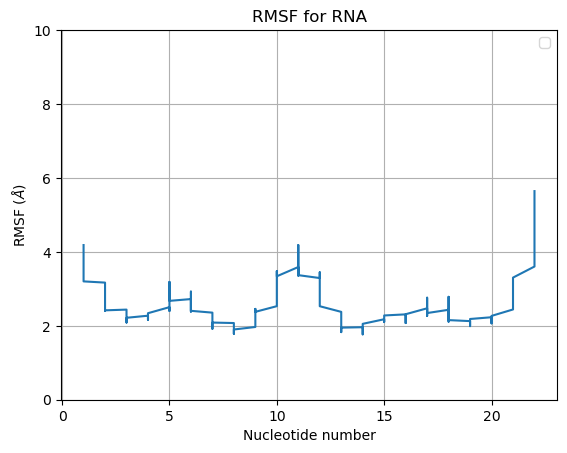

In [7]:
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import matplotlib.pyplot as plt
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor
import numpy as np

def rmsf_for_rna(i):
    extract_rna(i)
    # Load trajectory
    gro_file = f"vars/cleaned_rna{i}.gro"
    xtc_file = f"vars/cleaned_rna{i}.xtc"
    u = mda.Universe(gro_file, xtc_file)
    
    # Define selection for RNA backbone
    backbone_sel = f"(name P O5' C5' C4' C3' O3' C1' C2')"
    # Compute the average structure for the RNA backbone
    average = align.AverageStructure(u, u, select=backbone_sel, ref_frame=2000).run()
    ref_u = average.results.universe  # Static reference structure

    # Align trajectory to the reference structure (only RNA backbone)
    aligner = align.AlignTraj(u, ref_u, select=backbone_sel, in_memory=True).run()

    # Compute RMSF for the RNA backbone
    c_alphas = u.select_atoms(backbone_sel)

    R = rms.RMSF(c_alphas).run()


    # or something more useful
    return R.results.rmsf

ress = []
with ProcessPoolExecutor(max_workers=32) as executor:
    futures = []
    for i in range(NUM_RNA):
        futures.append(executor.submit(rmsf_for_rna, i))
    for future in concurrent.futures.as_completed(futures):
        ress.append(future.result())
    
    
print(len(ress))

average_array = np.mean(ress, axis=0)
gro_file = f"vars/cleaned_rna{i}.gro"
xtc_file = f"vars/cleaned_rna{i}.xtc"
u = mda.Universe(gro_file, xtc_file)
backbone_sel = f"(name P O5' C5' C4' C3' O3' C1' C2')"
c_alphas = u.select_atoms(backbone_sel)

average_neighbors = np.mean(rna_protein_neighbors, axis=0)
plt.plot(c_alphas.resids, average_array)
plt.xlabel('Nucleotide number')
plt.ylabel('RMSF ($\AA$)')
plt.title(f"RMSF for RNA")
plt.ylim(0, 10)  # Set y-axis limits
plt.grid(True)
plt.legend()
plt.show()


<>:64: SyntaxWarning: invalid escape sequence '\A'
<>:64: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_459226/2738752754.py:64: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('RMSF ($\AA$)')
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/python3.12/site-packages/MDAnalysis/coordinates/GRO.py:479: UserWarning: missing dimension - setting unit cell to zeroed box [0., 0., 0.]
  warnings.warn(wmsg)
/opt/conda/envs/gromacs/lib/pytho

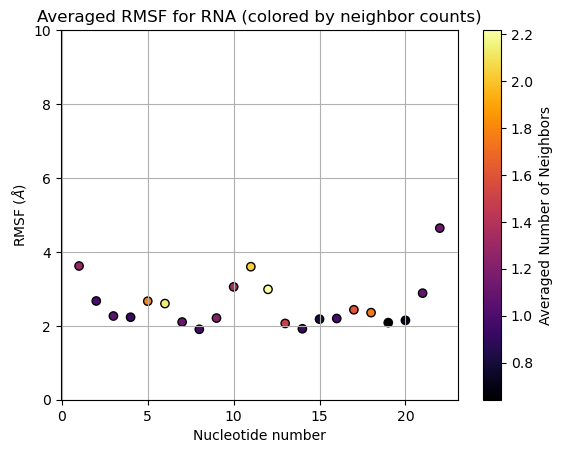

In [8]:
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

def rmsf_for_rna(i):
    extract_rna(i)
    # Load trajectory
    gro_file = f"vars/cleaned_rna{i}.gro"
    xtc_file = f"vars/cleaned_rna{i}.xtc"
    u = mda.Universe(gro_file, xtc_file)
    
    # Define selection for RNA backbone
    backbone_sel = "(name P O5' C5' C4' C3' O3' C1' C2')"
    
    # Compute the average structure for the RNA backbone
    average = align.AverageStructure(u, u, select=backbone_sel, ref_frame=2000).run()
    ref_u = average.results.universe  # Static reference structure

    # Align trajectory to the reference structure (only RNA backbone)
    aligner = align.AlignTraj(u, ref_u, select=backbone_sel, in_memory=True).run()

    # Compute RMSF for the RNA backbone (per atom)
    atoms = u.select_atoms(backbone_sel)
    R = rms.RMSF(atoms).run()
    
    # Group RMSF values by residue: average the RMSF of all atoms in the same residue
    resids = atoms.resids  # one residue id per atom
    unique_resids, inv = np.unique(resids, return_inverse=True)
    averaged_rmsf = np.zeros(len(unique_resids))
    for idx in range(len(unique_resids)):
        averaged_rmsf[idx] = np.mean(R.results.rmsf[inv == idx])
        
    # Return the unique residue numbers and the corresponding averaged RMSF values
    return unique_resids, averaged_rmsf

# Compute RMSF for each RNA in parallel
all_resids = []
all_rmsf = []
with ProcessPoolExecutor(max_workers=32) as executor:
    futures = []
    for i in range(NUM_RNA):
        futures.append(executor.submit(rmsf_for_rna, i))
    for future in as_completed(futures):
        unique_resids, averaged_rmsf = future.result()
        all_resids.append(unique_resids)
        all_rmsf.append(averaged_rmsf)

# If all RNAs have the same residue numbering, we can take the first as x-axis.
# all_rmsf is a list of arrays; average them element-wise:
all_rmsf = np.array(all_rmsf)
average_array = np.mean(all_rmsf, axis=0)
unique_resids = all_resids[0]  # assuming all are identical

# Now, average neighbor counts (assume rna_protein_neighbors is a 2D array where each row corresponds to an RNA)
average_neighbors = np.mean(rna_protein_neighbors, axis=0)

# Create a scatter plot with a high contrast colormap (e.g., inferno)
sc = plt.scatter(unique_resids, average_array,
                 c=average_neighbors, cmap='inferno', edgecolor='k',
                 vmin=average_neighbors.min(), vmax=average_neighbors.max())
plt.xlabel('Nucleotide number')
plt.ylabel('RMSF ($\AA$)')
plt.title("Averaged RMSF for RNA (colored by neighbor counts)")
plt.ylim(0, 10)  # Set y-axis limits
plt.grid(True)
cbar = plt.colorbar(sc)
cbar.set_label('Averaged Number of Neighbors')
plt.show()
